# Import data and packages

In [123]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import umap
import seaborn as sns
import statsmodels.api as sm
import math
import pyranges as pr
from sklearn.neighbors import NearestNeighbors
from intervaltree import Interval, IntervalTree
from collections import defaultdict
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.cluster.hierarchy import dendrogram
from lineage_colors import lineage_colors
import matplotlib.patches as mpatches
import matplotlib
from itertools import combinations
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
import pathlib, pandas as pd, numpy as np
from sklearn.decomposition import TruncatedSVD
import umap.umap_  as umap                       
from matplotlib.colors import Normalize
import re 
from matplotlib import patches
from scipy.stats import pearsonr
from matplotlib import cm
from scipy.stats import ttest_ind
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import zscore
!pip install intervaltree

RNA = pd.read_csv("data/converted_RNA_seq_info.csv", sep=";")
RNA_Bcells = pd.read_csv("data/RNA_Bcells.csv", index_col=0)
QC = pd.read_csv("data/ATAC_QCmatric.csv", sep=";")
QC_Bcells = pd.read_csv("data/ATAC_QC_Bcells.csv")


In [124]:
input_path = "data/ImmGenATAC18_AllOCRsInfo.csv"
output_path = "data/converted_ATAC_seq_info.csv"

df = pd.read_csv(input_path, sep=",", on_bad_lines='skip', engine="c")  # Robustere Einlesung

df.to_csv(output_path, sep=";", index=False)


print("converted")
ATAC = pd.read_csv("data/converted_ATAC_seq_info.CSV", sep=";")

converted


# Info about the data

In [125]:
ATAC.head()

ImmGenATAC1219.peakID chrom   Summit  mm10.60way.phastCons_scores  \
0  ImmGenATAC1219.peak_1  chr1  3020786                         0.00   
1  ImmGenATAC1219.peak_2  chr1  3087226                         0.00   
2  ImmGenATAC1219.peak_3  chr1  3120109                         0.07   
3  ImmGenATAC1219.peak_4  chr1  3121485                         0.15   
4  ImmGenATAC1219.peak_5  chr1  3372787                         0.03   

   _-log10_bestPvalue  Included.in.systematic.analysis  TSS  \
0                0.56                              NaN  NaN   
1                0.50                              NaN  NaN   
2               10.80                              1.0  NaN   
3                3.02                              1.0  NaN   
4                1.31                              NaN  NaN   

  genes.within.100Kb  LTHSC.34-.BM  LTHSC.34+.BM  ...  DC.4+.Sp  DC.8+.Sp  \
0                NaN          0.41          0.71  ...      0.10      0.10   
1                NaN          0.41          1.64  ...      1.70      0.10   
2                NaN          2.36          0.10  ...      0.87      0.54   
3                NaN          0.41          0.10  ...      0.44      1.83   
4                NaN          0.41          0.10  ...      0.44      0.10   

   DC.pDC.Sp  DC.103+11b+.SI  DC.103+11b-.SI  FRC.SLN  IAP.SLN  BEC.SLN  \
0       3.19            1.37            0.52     1.27     0.10     0.57   
1       1.41            0.47            0.11     0.92     0.98     2.16   
2       2.72            0.95            0.11    63.38     8.92     1.33   
3       0.66            0.11            0.92    13.50     0.98     1.28   
4       0.66            1.79            0.51     0.92     0.75     1.33   

   LEC.SLN  Ep.MEChi.Th  
0     3.27         1.41  
1     2.34         0.94  
2     1.04         0.11  
3     1.04         0.11  
4     1.61         4.50  

[5 rows x 98 columns]

In [126]:
ATAC.shape

(512595, 98)

In [127]:
ATAC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512595 entries, 0 to 512594
Data columns (total 98 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   ImmGenATAC1219.peakID            512595 non-null  object 
 1   chrom                            512595 non-null  object 
 2   Summit                           512595 non-null  int64  
 3   mm10.60way.phastCons_scores      512595 non-null  float64
 4   _-log10_bestPvalue               512595 non-null  float64
 5   Included.in.systematic.analysis  334879 non-null  float64
 6   TSS                              14292 non-null   object 
 7   genes.within.100Kb               427710 non-null  object 
 8   LTHSC.34-.BM                     512595 non-null  float64
 9   LTHSC.34+.BM                     512595 non-null  float64
 10  STHSC.150-.BM                    512595 non-null  float64
 11  MPP4.135+.BM                     512595 non-null  float64
 12  pr

In [128]:
ATAC.describe()

Summit  mm10.60way.phastCons_scores  _-log10_bestPvalue  \
count  5.125950e+05                512595.000000           512595.00   
mean   7.596866e+07                     0.164662                 inf   
std    4.450542e+07                     0.203403                 NaN   
min    1.430000e+02                     0.000000                0.00   
25%    3.802562e+07                     0.030000                1.16   
50%    7.364690e+07                     0.080000                2.32   
75%    1.091549e+08                     0.220000                5.28   
max    1.953715e+08                     1.000000                 inf   

       Included.in.systematic.analysis   LTHSC.34-.BM   LTHSC.34+.BM  \
count                         334879.0  512595.000000  512595.000000   
mean                               1.0       3.868438       4.005767   
std                                0.0      10.004101       9.986633   
min                                1.0       0.410000       0.100000   
25%                                1.0       0.410000       0.710000   
50%                                1.0       0.410000       1.640000   
75%                                1.0       2.360000       3.680000   
max                                1.0     727.420000     727.420000   

       STHSC.150-.BM   MPP4.135+.BM    proB.CLP.BM    proB.FrA.BM  ...  \
count  512595.000000  512595.000000  512595.000000  512595.000000  ...   
mean        4.001125       4.002324       4.008413       4.007382  ...   
std         9.991892       9.994831       9.772241       9.856476  ...   
min         0.110000       0.110000       0.110000       0.100000  ...   
25%         0.110000       0.110000       0.470000       0.630000  ...   
50%         0.900000       1.580000       1.260000       1.340000  ...   
75%         3.520000       3.490000       3.220000       3.290000  ...   
max       727.420000     727.420000     727.420000     727.420000  ...   

            DC.4+.Sp       DC.8+.Sp      DC.pDC.Sp  DC.103+11b+.SI  \
count  512595.000000  512595.000000  512595.000000   512595.000000   
mean        4.011853       3.997303       3.977888        3.999854   
std         9.854836       9.832034       9.807041        9.903564   
min         0.100000       0.100000       0.110000        0.110000   
25%         0.770000       0.540000       0.660000        0.530000   
50%         1.260000       1.390000       1.320000        1.370000   
75%         3.120000       3.000000       2.880000        3.080000   
max       727.420000     727.420000     727.420000      727.420000   

       DC.103+11b-.SI        FRC.SLN        IAP.SLN        BEC.SLN  \
count   512595.000000  512595.000000  512595.000000  512595.000000   
mean         3.995355       3.998828       3.987949       3.983416   
std          9.900401       9.808067       9.614775       9.709456   
min          0.110000       0.110000       0.100000       0.110000   
25%          0.520000       0.560000       0.720000       0.570000   
50%          1.360000       1.470000       1.400000       1.540000   
75%          3.230000       2.980000       3.120000       3.180000   
max        727.420000     727.420000     727.420000     727.420000   

             LEC.SLN    Ep.MEChi.Th  
count  512595.000000  512595.000000  
mean        3.976234       3.996922  
std         9.715224       9.837748  
min         0.110000       0.110000  
25%         0.640000       0.530000  
50%         1.570000       1.360000  
75%         3.270000       3.270000  
max       727.420000     727.420000  

[8 rows x 94 columns]

# Data Clean-up

In [129]:
#coloums with numerical datas 
float_cols = ATAC.select_dtypes(include=['float64']).columns
print(float_cols)
ATAC_num = ATAC.select_dtypes(include=['float64'])
ATAC_num.head()

Index(['mm10.60way.phastCons_scores', '_-log10_bestPvalue',
       'Included.in.systematic.analysis', 'LTHSC.34-.BM', 'LTHSC.34+.BM',
       'STHSC.150-.BM', 'MPP4.135+.BM', 'proB.CLP.BM', 'proB.FrA.BM',
       'proB.FrBC.BM', 'preB.FrD.BM', 'B.FrE.BM', 'B1b.PC', 'B.T1.Sp',
       'B.T2.Sp', 'B.T3.Sp', 'B.Sp', 'B.Fem.Sp', 'B.MZ.Sp', 'B.Fo.Sp',
       'B.mem.Sp', 'B.GC.CB.Sp', 'B.GC.CC.Sp', 'B.PB.Sp', 'B.PC.Sp', 'B.PC.BM',
       'preT.DN1.Th', 'preT.DN2a.Th', 'preT.DN2b.Th', 'preT.DN3.Th',
       'T.DN4.Th', 'T.ISP.Th', 'T.DP.Th', 'T.4.Th', 'T.8.Th', 'T.4.Nve.Sp',
       'T.4.Nve.Fem.Sp', 'T.8.Nve.Sp', 'T.4.Sp.aCD3+CD40.18hr',
       'Treg.4.FP3+.Nrplo.Co', 'Treg.4.25hi.Sp', 'T8.TN.P14.Sp',
       'T8.IEL.LCMV.d7.SI', 'T8.TE.LCMV.d7.Sp', 'T8.MP.LCMV.d7.Sp',
       'T8.Tcm.LCMV.d180.Sp', 'T8.Tem.LCMV.d180.Sp', 'NKT.Sp',
       'NKT.Sp.LPS.3hr', 'NKT.Sp.LPS.18hr', 'NKT.Sp.LPS.3d',
       'Tgd.g2+d17.24a+.Th', 'Tgd.g2+d17.LN', 'Tgd.g2+d1.24a+.Th',
       'Tgd.g2+d1.LN', 'Tgd.g1.1+d1.24a+.

mm10.60way.phastCons_scores  _-log10_bestPvalue  \
0                         0.00                0.56   
1                         0.00                0.50   
2                         0.07               10.80   
3                         0.15                3.02   
4                         0.03                1.31   

   Included.in.systematic.analysis  LTHSC.34-.BM  LTHSC.34+.BM  STHSC.150-.BM  \
0                              NaN          0.41          0.71           0.90   
1                              NaN          0.41          1.64           0.90   
2                              1.0          2.36          0.10           0.90   
3                              1.0          0.41          0.10           0.11   
4                              NaN          0.41          0.10           0.11   

   MPP4.135+.BM  proB.CLP.BM  proB.FrA.BM  proB.FrBC.BM  ...  DC.4+.Sp  \
0          0.11         1.94         0.10          0.11  ...      0.10   
1          0.83         0.47         0.34          0.82  ...      1.70   
2          0.11         0.47         0.10          0.50  ...      0.87   
3          0.11         0.79         0.40          0.50  ...      0.44   
4          0.11         0.47         0.34          1.78  ...      0.44   

   DC.8+.Sp  DC.pDC.Sp  DC.103+11b+.SI  DC.103+11b-.SI  FRC.SLN  IAP.SLN  \
0      0.10       3.19            1.37            0.52     1.27     0.10   
1      0.10       1.41            0.47            0.11     0.92     0.98   
2      0.54       2.72            0.95            0.11    63.38     8.92   
3      1.83       0.66            0.11            0.92    13.50     0.98   
4      0.10       0.66            1.79            0.51     0.92     0.75   

   BEC.SLN  LEC.SLN  Ep.MEChi.Th  
0     0.57     3.27         1.41  
1     2.16     2.34         0.94  
2     1.33     1.04         0.11  
3     1.28     1.04         0.11  
4     1.33     1.61         4.50  

[5 rows x 93 columns]

In [130]:
#remove col accoring to Included.in.systematic.analysis 
ATAC_included_values = ATAC_num.drop(columns=['Included.in.systematic.analysis'])
ATAC_included_values = ATAC_included_values.replace([np.inf, -np.inf], np.nan).dropna()
ATAC_included_values.head()

mm10.60way.phastCons_scores  _-log10_bestPvalue  LTHSC.34-.BM  \
0                         0.00                0.56          0.41   
1                         0.00                0.50          0.41   
2                         0.07               10.80          2.36   
3                         0.15                3.02          0.41   
4                         0.03                1.31          0.41   

   LTHSC.34+.BM  STHSC.150-.BM  MPP4.135+.BM  proB.CLP.BM  proB.FrA.BM  \
0          0.71           0.90          0.11         1.94         0.10   
1          1.64           0.90          0.83         0.47         0.34   
2          0.10           0.90          0.11         0.47         0.10   
3          0.10           0.11          0.11         0.79         0.40   
4          0.10           0.11          0.11         0.47         0.34   

   proB.FrBC.BM  preB.FrD.BM  ...  DC.4+.Sp  DC.8+.Sp  DC.pDC.Sp  \
0          0.11         1.69  ...      0.10      0.10       3.19   
1          0.82         0.13  ...      1.70      0.10       1.41   
2          0.50         1.17  ...      0.87      0.54       2.72   
3          0.50         2.23  ...      0.44      1.83       0.66   
4          1.78         1.17  ...      0.44      0.10       0.66   

   DC.103+11b+.SI  DC.103+11b-.SI  FRC.SLN  IAP.SLN  BEC.SLN  LEC.SLN  \
0            1.37            0.52     1.27     0.10     0.57     3.27   
1            0.47            0.11     0.92     0.98     2.16     2.34   
2            0.95            0.11    63.38     8.92     1.33     1.04   
3            0.11            0.92    13.50     0.98     1.28     1.04   
4            1.79            0.51     0.92     0.75     1.33     1.61   

   Ep.MEChi.Th  
0         1.41  
1         0.94  
2         0.11  
3         0.11  
4         4.50  

[5 rows x 92 columns]

In [131]:
# standardizing the values 
scaler = StandardScaler()
ATAC_scaled = scaler.fit_transform(ATAC_included_values)
ATAC_scaled = pd.DataFrame(ATAC_scaled, columns=ATAC_included_values.columns)
ATAC_scaled.head()

mm10.60way.phastCons_scores  _-log10_bestPvalue  LTHSC.34-.BM  \
0                    -0.809539           -0.559121     -0.347680   
1                    -0.809539           -0.566819     -0.347680   
2                    -0.465393            0.754803     -0.151497   
3                    -0.072084           -0.243471     -0.347680   
4                    -0.662048           -0.462886     -0.347680   

   LTHSC.34+.BM  STHSC.150-.BM  MPP4.135+.BM  proB.CLP.BM  proB.FrA.BM  \
0     -0.332134      -0.312326     -0.392148    -0.212971    -0.399112   
1     -0.238330      -0.312326     -0.319552    -0.364538    -0.374580   
2     -0.393661      -0.312326     -0.392148    -0.364538    -0.399112   
3     -0.393661      -0.391963     -0.392148    -0.331544    -0.368447   
4     -0.393661      -0.391963     -0.392148    -0.364538    -0.374580   

   proB.FrBC.BM  preB.FrD.BM  ...  DC.4+.Sp  DC.8+.Sp  DC.pDC.Sp  \
0     -0.398442    -0.233379  ... -0.399737 -0.398901  -0.080700   
1     -0.325777    -0.393567  ... -0.236112 -0.398901  -0.263836   
2     -0.358528    -0.286775  ... -0.320992 -0.353833  -0.129056   
3     -0.358528    -0.177929  ... -0.364966 -0.221703  -0.341000   
4     -0.227526    -0.286775  ... -0.364966 -0.398901  -0.341000   

   DC.103+11b+.SI  DC.103+11b-.SI   FRC.SLN   IAP.SLN   BEC.SLN   LEC.SLN  \
0       -0.267259       -0.353273 -0.279969 -0.407153 -0.353697 -0.072970   
1       -0.358823       -0.394984 -0.315912 -0.314928 -0.188821 -0.169477   
2       -0.309989       -0.394984  6.098422  0.517198 -0.274888 -0.304379   
3       -0.395449       -0.312579  0.975992 -0.314928 -0.280073 -0.304379   
4       -0.224528       -0.354290 -0.315912 -0.339032 -0.274888 -0.245229   

   Ep.MEChi.Th  
0    -0.264709  
1    -0.312857  
2    -0.397884  
3    -0.397884  
4     0.051840  

[5 rows x 92 columns]

In [132]:
# check if standardization worked
print("mean (should be ~0):", np.mean(ATAC_scaled, axis=0))
print("sd (should be ~1):", np.std(ATAC_scaled, axis=0))

mean (should be ~0): mm10.60way.phastCons_scores   -1.188789e-16
_-log10_bestPvalue            -1.055716e-16
LTHSC.34-.BM                  -8.971366e-17
LTHSC.34+.BM                  -8.938098e-17
STHSC.150-.BM                  1.723301e-16
                                   ...     
FRC.SLN                       -3.426640e-17
IAP.SLN                        5.655620e-17
BEC.SLN                       -9.581286e-17
LEC.SLN                        1.541434e-17
Ep.MEChi.Th                    2.240069e-17
Length: 92, dtype: float64
sd (should be ~1): mm10.60way.phastCons_scores    1.0
_-log10_bestPvalue             1.0
LTHSC.34-.BM                   1.0
LTHSC.34+.BM                   1.0
STHSC.150-.BM                  1.0
                              ... 
FRC.SLN                        1.0
IAP.SLN                        1.0
BEC.SLN                        1.0
LEC.SLN                        1.0
Ep.MEChi.Th                    1.0
Length: 92, dtype: float64


## ATAC transposed dataset - B-cell specific

In [133]:
# of scaled values
ATAC_scaled_Peaks_Bcells = ATAC_scaled.iloc[:, 2:31]
ATAC_T_scaled_Bcells = ATAC_scaled_Peaks_Bcells.T
ATAC_T_scaled_Bcells.head()

0         1         2         3         4         5       \
LTHSC.34-.BM  -0.347680 -0.347680 -0.151497 -0.347680 -0.347680 -0.151497   
LTHSC.34+.BM  -0.332134 -0.238330 -0.393661 -0.393661 -0.393661 -0.238330   
STHSC.150-.BM -0.312326 -0.312326 -0.312326 -0.391963 -0.391963 -0.216561   
MPP4.135+.BM  -0.392148 -0.319552 -0.392148 -0.392148 -0.392148 -0.243931   
proB.CLP.BM   -0.212971 -0.364538 -0.364538 -0.331544 -0.364538 -0.297518   

                 6         7         8         9       ...    512580  \
LTHSC.34-.BM  -0.347680 -0.151497  0.050723  0.315319  ...  0.050723   
LTHSC.34+.BM  -0.393661 -0.332134 -0.393661 -0.393661  ...  0.944810   
STHSC.150-.BM -0.391963 -0.312326 -0.312326 -0.391963  ...  0.863070   
MPP4.135+.BM  -0.392148 -0.392148 -0.392148 -0.392148  ...  0.743176   
proB.CLP.BM   -0.401656 -0.251120 -0.369693 -0.364538  ...  1.657383   

                 512581    512582    512583    512584    512585    512586  \
LTHSC.34-.BM  -0.347680 -0.347680 -0.347680 -0.151497  0.050723 -0.347680   
LTHSC.34+.BM  -0.144526  0.631121  0.343658  0.482850  0.482850  0.343658   
STHSC.150-.BM -0.131884 -0.048215 -0.216561 -0.312326 -0.048215 -0.048215   
MPP4.135+.BM  -0.143103 -0.186459 -0.051349 -0.186459 -0.143103 -0.096722   
proB.CLP.BM    0.059231 -0.115020  0.180896 -0.077901  0.021081  0.253071   

                 512587    512588    512589  
LTHSC.34-.BM  -0.347680 -0.347680 -0.347680  
LTHSC.34+.BM  -0.332134 -0.238330 -0.332134  
STHSC.150-.BM -0.391963 -0.391963 -0.312326  
MPP4.135+.BM  -0.319552 -0.319552 -0.051349  
proB.CLP.BM   -0.320202 -0.320202 -0.119144  

[5 rows x 512590 columns]

In [134]:
# included in systematic analysis - makes more sense because we only look at B-cells anyway
ATAC_included_values_Bcells = ATAC_included_values.iloc[:, 2:25]
ATAC_T_included_values_Bcells = ATAC_included_values_Bcells.T
ATAC_T_included_values_Bcells.head()

0       1       2       3       4       5       6       7       \
LTHSC.34-.BM     0.41    0.41    2.36    0.41    0.41    2.36    0.41    2.36   
LTHSC.34+.BM     0.71    1.64    0.10    0.10    0.10    1.64    0.10    0.71   
STHSC.150-.BM    0.90    0.90    0.90    0.11    0.11    1.85    0.11    0.90   
MPP4.135+.BM     0.11    0.83    0.11    0.11    0.11    1.58    0.11    0.11   
proB.CLP.BM      1.94    0.47    0.47    0.79    0.47    1.12    0.11    1.57   

               8       9       ...  512585  512586  512587  512588  512589  \
LTHSC.34-.BM     4.37    7.00  ...    4.37    0.41    0.41    0.41    2.36   
LTHSC.34+.BM     0.10    0.10  ...   13.37    2.57   10.26    7.41    8.79   
STHSC.150-.BM    0.90    0.11  ...   12.56    2.69    3.52    1.85    0.90   
MPP4.135+.BM     0.11    0.11  ...   11.37    2.58    2.15    3.49    2.15   
proB.CLP.BM      0.42    0.47  ...   20.08    4.58    2.89    5.76    3.25   

               512590  512591  512592  512593  512594  
LTHSC.34-.BM     4.37    0.41    0.41    0.41    0.41  
LTHSC.34+.BM     8.79    7.41    0.71    1.64    0.71  
STHSC.150-.BM    3.52    3.52    0.11    0.11    0.90  
MPP4.135+.BM     2.58    3.04    0.83    0.83    3.49  
proB.CLP.BM      4.21    6.46    0.90    0.90    2.85  

[5 rows x 512590 columns]

In [135]:
#reduce ATAC_scaled to cell-type only columns
non_signal_cols = ['mm10.60way.phastCons_scores', '_-log10_bestPvalue']
ATAC_scaled_ct = ATAC_scaled.drop(columns=non_signal_cols)
ATAC_scaled_ct.to_csv("data/ATAC_scaled.ct.csv", index=False) 
ATAC_scaled_ct.head()

LTHSC.34-.BM  LTHSC.34+.BM  STHSC.150-.BM  MPP4.135+.BM  proB.CLP.BM  \
0     -0.347680     -0.332134      -0.312326     -0.392148    -0.212971   
1     -0.347680     -0.238330      -0.312326     -0.319552    -0.364538   
2     -0.151497     -0.393661      -0.312326     -0.392148    -0.364538   
3     -0.347680     -0.393661      -0.391963     -0.392148    -0.331544   
4     -0.347680     -0.393661      -0.391963     -0.392148    -0.364538   

   proB.FrA.BM  proB.FrBC.BM  preB.FrD.BM  B.FrE.BM    B1b.PC  ...  DC.4+.Sp  \
0    -0.399112     -0.398442    -0.233379 -0.350951 -0.396931  ... -0.399737   
1    -0.374580     -0.325777    -0.393567 -0.398344 -0.314389  ... -0.236112   
2    -0.399112     -0.358528    -0.286775 -0.376708 -0.396931  ... -0.320992   
3    -0.368447     -0.358528    -0.177929 -0.327254 -0.396931  ... -0.364966   
4    -0.374580     -0.227526    -0.286775 -0.376708 -0.348869  ... -0.364966   

   DC.8+.Sp  DC.pDC.Sp  DC.103+11b+.SI  DC.103+11b-.SI   FRC.SLN   IAP.SLN  \
0 -0.398901  -0.080700       -0.267259       -0.353273 -0.279969 -0.407153   
1 -0.398901  -0.263836       -0.358823       -0.394984 -0.315912 -0.314928   
2 -0.353833  -0.129056       -0.309989       -0.394984  6.098422  0.517198   
3 -0.221703  -0.341000       -0.395449       -0.312579  0.975992 -0.314928   
4 -0.398901  -0.341000       -0.224528       -0.354290 -0.315912 -0.339032   

    BEC.SLN   LEC.SLN  Ep.MEChi.Th  
0 -0.353697 -0.072970    -0.264709  
1 -0.188821 -0.169477    -0.312857  
2 -0.274888 -0.304379    -0.397884  
3 -0.280073 -0.304379    -0.397884  
4 -0.274888 -0.245229     0.051840  

[5 rows x 90 columns]

### Significance vs. conservation - Scatter plot

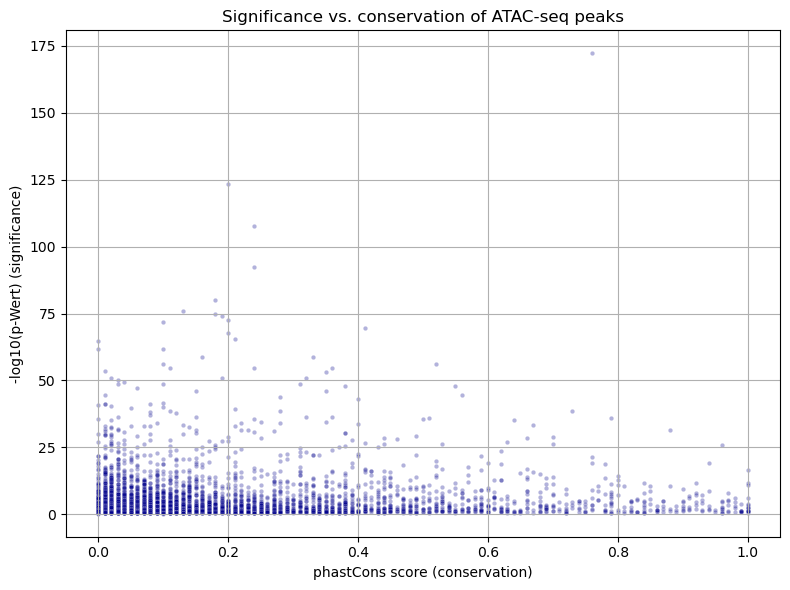

In [137]:
# selection of the two columns

ATAC_filtered = ATAC[["_-log10_bestPvalue", "mm10.60way.phastCons_scores"]].dropna()

# scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=ATAC_filtered.sample(n=5000, random_state=42),  # optional: nur 5000 Punkte für bessere Performance
    x="mm10.60way.phastCons_scores",
    y="_-log10_bestPvalue",
    alpha=0.3,
    s=10,
    color="darkblue"
)
plt.xlabel("phastCons score (conservation)")
plt.ylabel("-log10(p-Wert) (significance)")
plt.title("Significance vs. conservation of ATAC-seq peaks")
plt.grid(True)
plt.tight_layout()
plt.show()


### Hexplots

In [138]:
ATAC_stat = ATAC.copy()

ATAC_values = ATAC.iloc[:, 8:]

# statistics per peak (row)
ATAC_stat['mean_peak'] = ATAC_values.mean(axis=1)
ATAC_stat['median_peak'] = ATAC_values.median(axis=1)
ATAC_stat['var_peak'] = ATAC_values.var(axis=1)
ATAC_stat['std_peak'] = ATAC_values.std(axis=1)
ATAC_stat['min_peak'] = ATAC_values.min(axis=1)
ATAC_stat['max_peak'] = ATAC_values.max(axis=1)

print(ATAC_stat[['mean_peak', 'median_peak', 'var_peak', 'std_peak', 'min_peak', 'max_peak']].head())


   mean_peak  median_peak   var_peak  std_peak  min_peak  max_peak
0   1.053556        0.710   1.013886  1.006919       0.1      5.15
1   0.929000        0.765   0.748142  0.864952       0.1      3.87
2   1.521000        0.495  45.111153  6.716484       0.1     63.38
3   0.874556        0.530   2.352263  1.533709       0.1     13.50
4   0.882111        0.630   0.666815  0.816587       0.1      4.50


In [139]:
print(ATAC_stat.columns.tolist())


['ImmGenATAC1219.peakID', 'chrom', 'Summit', 'mm10.60way.phastCons_scores', '_-log10_bestPvalue', 'Included.in.systematic.analysis', 'TSS', 'genes.within.100Kb', 'LTHSC.34-.BM', 'LTHSC.34+.BM', 'STHSC.150-.BM', 'MPP4.135+.BM', 'proB.CLP.BM', 'proB.FrA.BM', 'proB.FrBC.BM', 'preB.FrD.BM', 'B.FrE.BM', 'B1b.PC', 'B.T1.Sp', 'B.T2.Sp', 'B.T3.Sp', 'B.Sp', 'B.Fem.Sp', 'B.MZ.Sp', 'B.Fo.Sp', 'B.mem.Sp', 'B.GC.CB.Sp', 'B.GC.CC.Sp', 'B.PB.Sp', 'B.PC.Sp', 'B.PC.BM', 'preT.DN1.Th', 'preT.DN2a.Th', 'preT.DN2b.Th', 'preT.DN3.Th', 'T.DN4.Th', 'T.ISP.Th', 'T.DP.Th', 'T.4.Th', 'T.8.Th', 'T.4.Nve.Sp', 'T.4.Nve.Fem.Sp', 'T.8.Nve.Sp', 'T.4.Sp.aCD3+CD40.18hr', 'Treg.4.FP3+.Nrplo.Co', 'Treg.4.25hi.Sp', 'T8.TN.P14.Sp', 'T8.IEL.LCMV.d7.SI', 'T8.TE.LCMV.d7.Sp', 'T8.MP.LCMV.d7.Sp', 'T8.Tcm.LCMV.d180.Sp', 'T8.Tem.LCMV.d180.Sp', 'NKT.Sp', 'NKT.Sp.LPS.3hr', 'NKT.Sp.LPS.18hr', 'NKT.Sp.LPS.3d', 'Tgd.g2+d17.24a+.Th', 'Tgd.g2+d17.LN', 'Tgd.g2+d1.24a+.Th', 'Tgd.g2+d1.LN', 'Tgd.g1.1+d1.24a+.Th', 'Tgd.g1.1+d1.LN', 'Tgd.Sp'

In [140]:
ATAC_stat.head(20)

ImmGenATAC1219.peakID chrom   Summit  mm10.60way.phastCons_scores  \
0    ImmGenATAC1219.peak_1  chr1  3020786                         0.00   
1    ImmGenATAC1219.peak_2  chr1  3087226                         0.00   
2    ImmGenATAC1219.peak_3  chr1  3120109                         0.07   
3    ImmGenATAC1219.peak_4  chr1  3121485                         0.15   
4    ImmGenATAC1219.peak_5  chr1  3372787                         0.03   
5    ImmGenATAC1219.peak_6  chr1  3399217                         0.06   
6    ImmGenATAC1219.peak_7  chr1  3400115                         0.44   
7    ImmGenATAC1219.peak_8  chr1  3416260                         0.01   
8    ImmGenATAC1219.peak_9  chr1  3434092                         0.18   
9   ImmGenATAC1219.peak_10  chr1  3434378                         0.15   
10  ImmGenATAC1219.peak_11  chr1  3445768                         0.00   
11  ImmGenATAC1219.peak_12  chr1  3446022                         0.00   
12  ImmGenATAC1219.peak_13  chr1  3505885                         0.01   
13  ImmGenATAC1219.peak_14  chr1  3514761                         0.07   
14  ImmGenATAC1219.peak_15  chr1  3515024                         0.22   
15  ImmGenATAC1219.peak_16  chr1  3535704                         0.03   
16  ImmGenATAC1219.peak_17  chr1  3600878                         0.09   
17  ImmGenATAC1219.peak_18  chr1  3611363                         0.16   
18  ImmGenATAC1219.peak_19  chr1  3670859                         0.76   
19  ImmGenATAC1219.peak_20  chr1  3671114                         0.94   

    _-log10_bestPvalue  Included.in.systematic.analysis  TSS  \
0                 0.56                              NaN  NaN   
1                 0.50                              NaN  NaN   
2                10.80                              1.0  NaN   
3                 3.02                              1.0  NaN   
4                 1.31                              NaN  NaN   
5                 2.39                              1.0  NaN   
6                 2.57                              1.0  NaN   
7                 2.57                              1.0  NaN   
8                 1.34                              NaN  NaN   
9                 1.83                              1.0  NaN   
10                0.84                              NaN  NaN   
11                2.23                              1.0  NaN   
12                0.62                              NaN  NaN   
13                1.83                              1.0  NaN   
14                6.45                              1.0  NaN   
15                1.09                              NaN  NaN   
16                0.36                              NaN  NaN   
17                3.32                              1.0  NaN   
18                1.74                              1.0  NaN   
19                2.02                              1.0  NaN   

   genes.within.100Kb  LTHSC.34-.BM  LTHSC.34+.BM  ...  IAP.SLN  BEC.SLN  \
0                 NaN          0.41          0.71  ...     0.10     0.57   
1                 NaN          0.41          1.64  ...     0.98     2.16   
2                 NaN          2.36          0.10  ...     8.92     1.33   
3                 NaN          0.41          0.10  ...     0.98     1.28   
4                 NaN          0.41          0.10  ...     0.75     1.33   
5                 NaN          2.36          1.64  ...     1.40     0.90   
6                 NaN          0.41          0.10  ...     0.75     2.30   
7                 NaN          2.36          0.71  ...     0.98     1.33   
8                 NaN          4.37          0.10  ...     0.50     1.92   
9                 NaN          7.00          0.10  ...     0.75     2.59   
10                NaN          0.41          0.10  ...     0.98     1.12   
11                NaN          2.36          0.10  ...     0.50     2.69   
12                NaN          0.41          0.71  ...     2.23     1.33   
13                NaN          0.41      

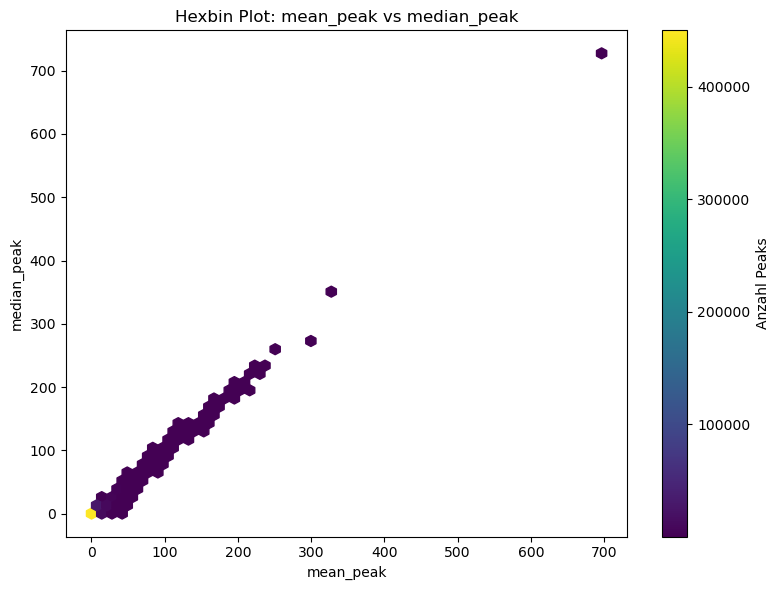

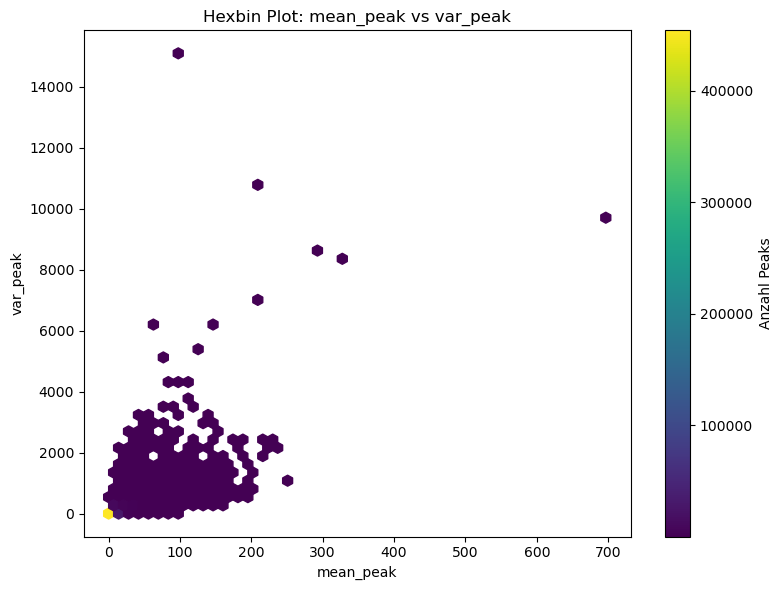

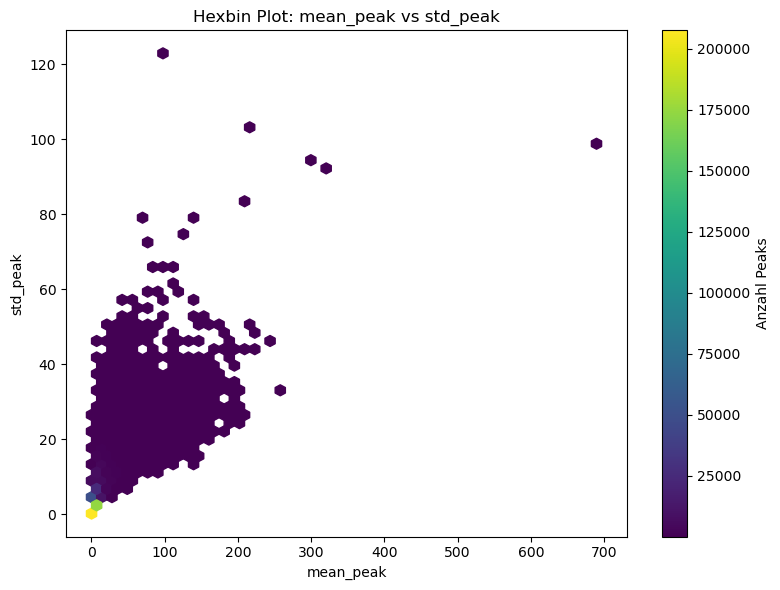

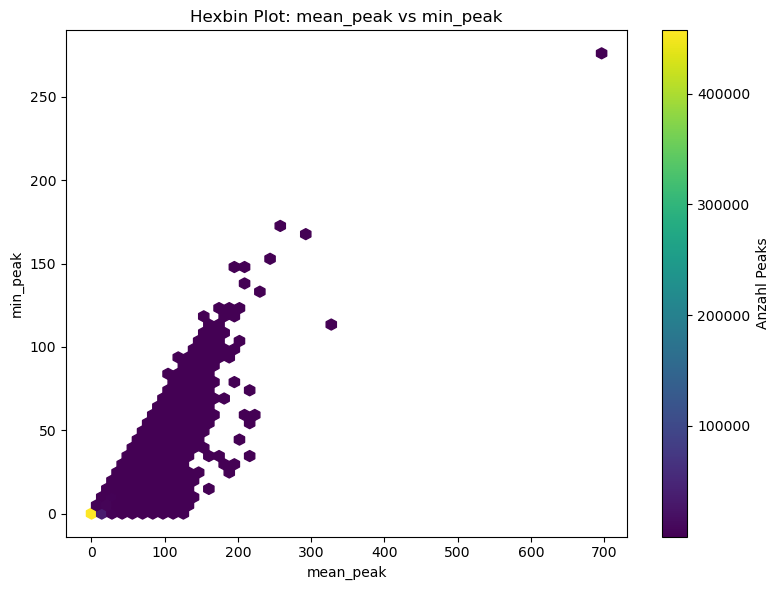

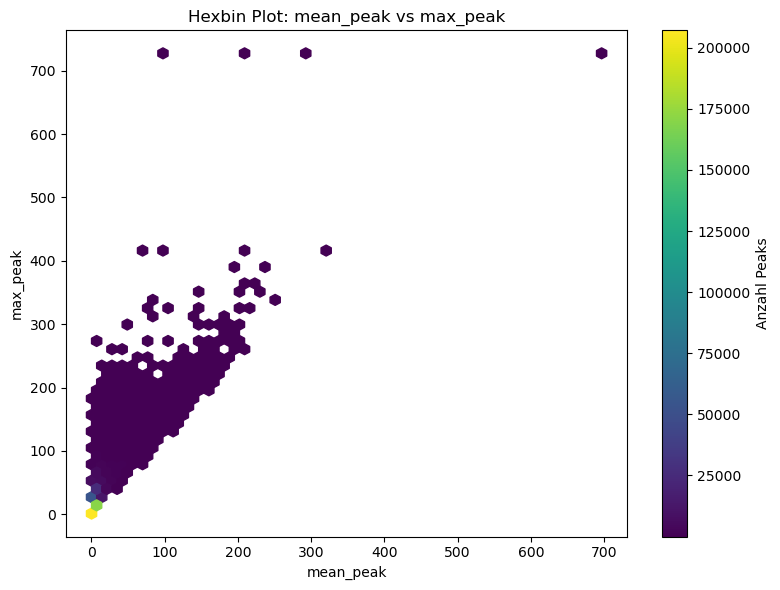

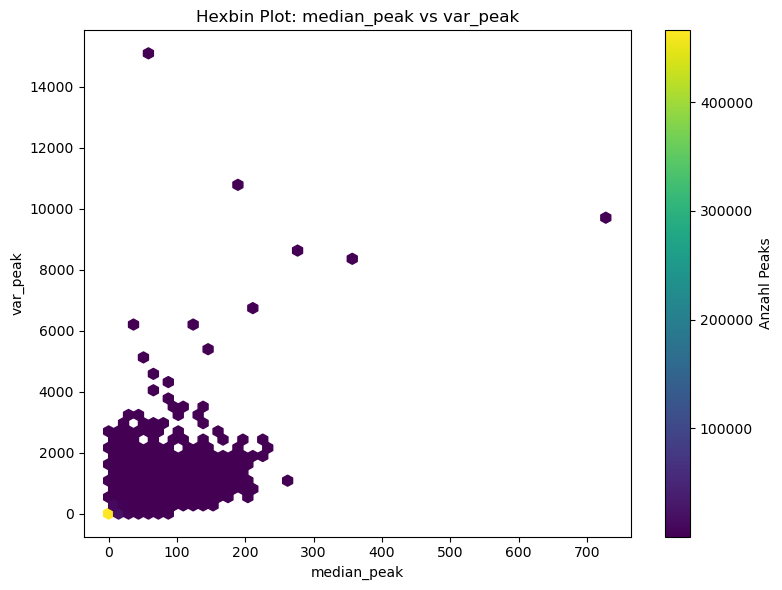

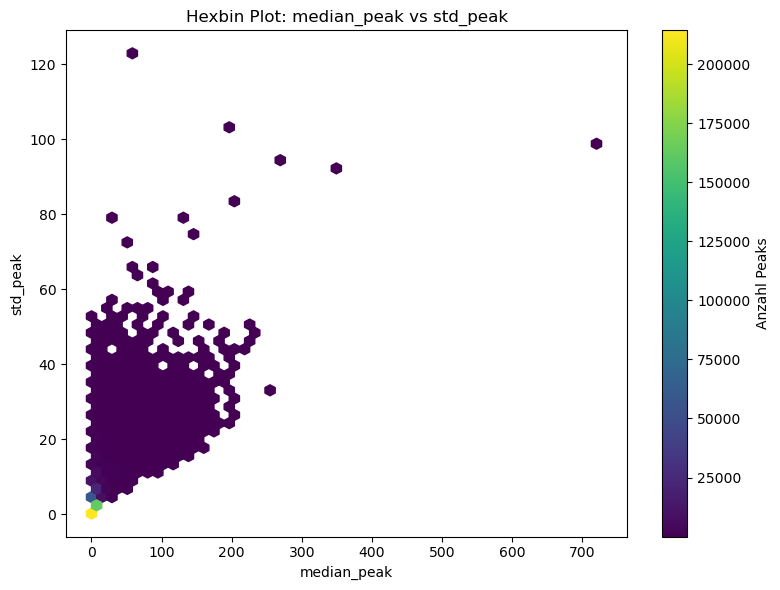

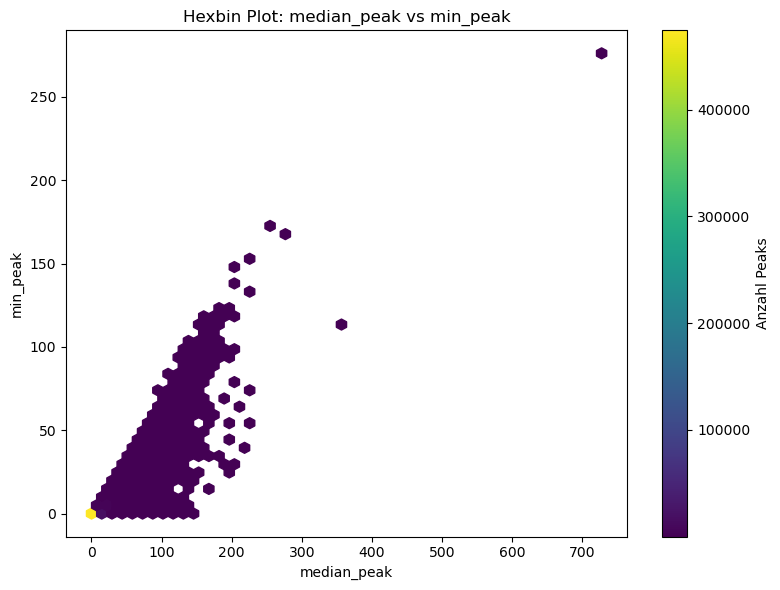

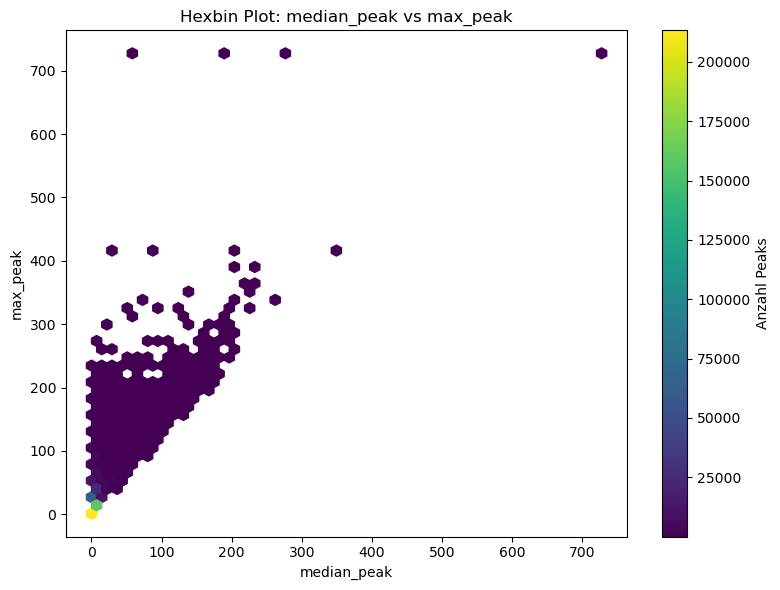

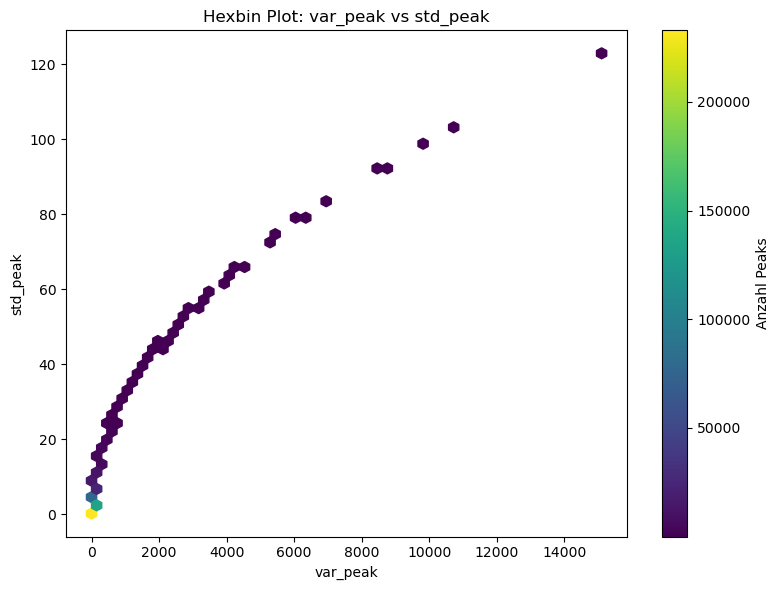

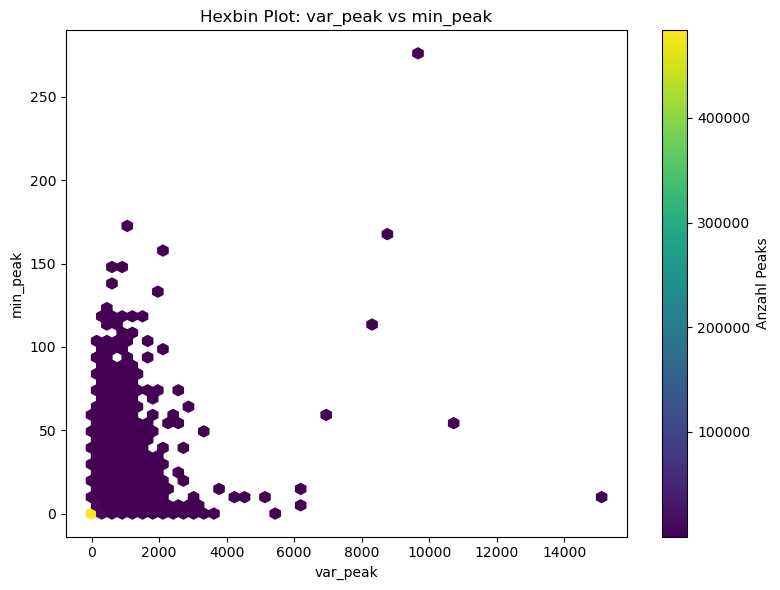

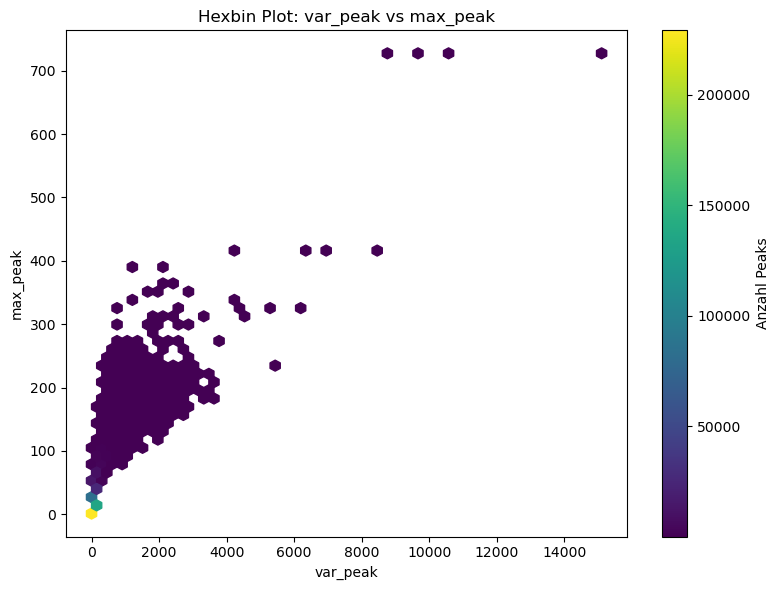

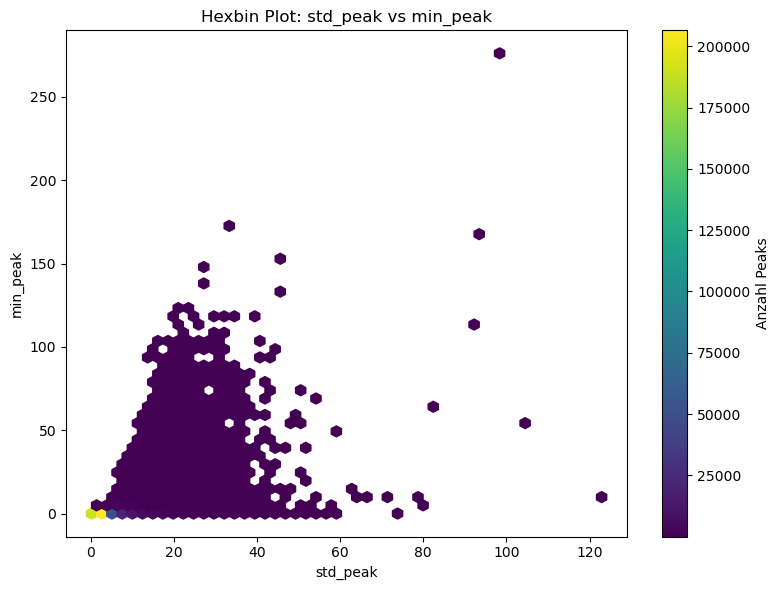

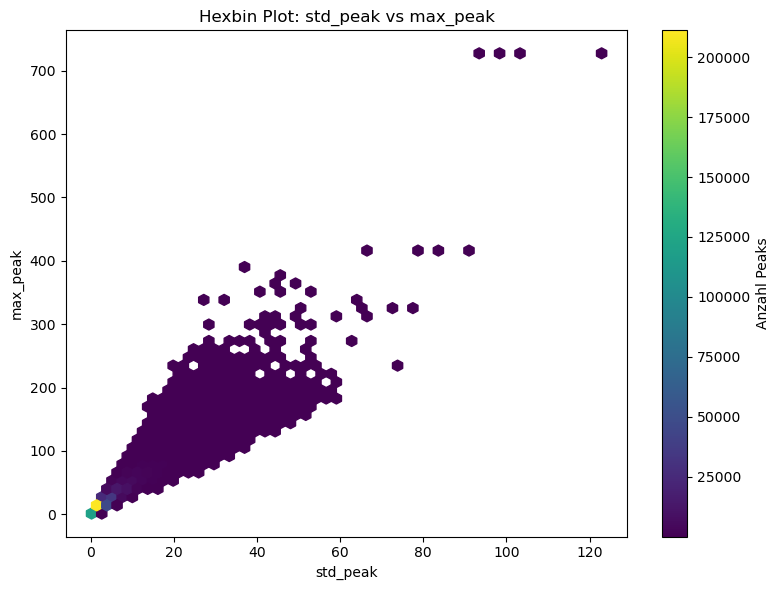

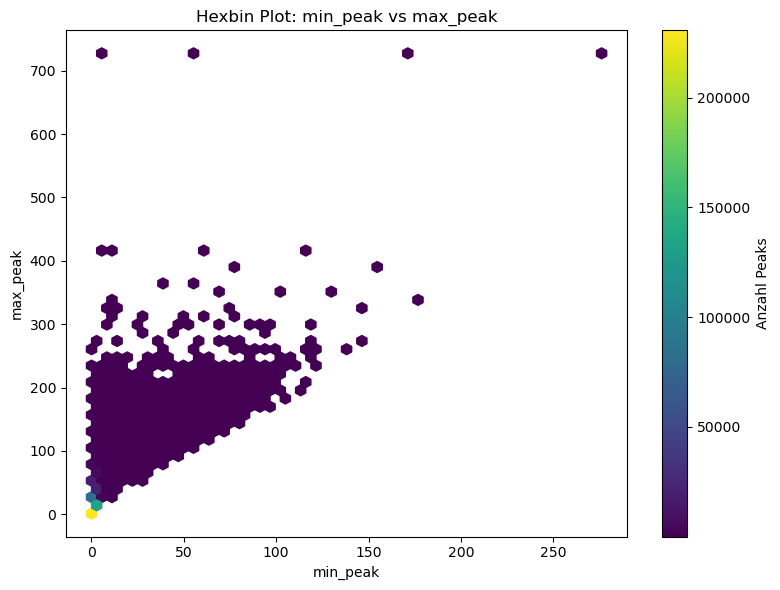

In [141]:
stat_cols = ['mean_peak', 'median_peak', 'var_peak', 'std_peak', 'min_peak', 'max_peak']

for x_col, y_col in combinations(stat_cols, 2):
    plt.figure(figsize=(8, 6))
    plt.hexbin(ATAC_stat[x_col], ATAC_stat[y_col], gridsize=50, cmap='viridis', mincnt=1)
    plt.colorbar(label='Anzahl Peaks')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f'Hexbin Plot: {x_col} vs {y_col}')
    plt.tight_layout()
    plt.show()


# 1. Differences and similarities of the chromatin landscape between immune cells

## i. How variable is the chromatin signal within cells?

### a) Is the signal dependent on sequencing depth, number of input cells, QC metric?

For that we first calculated the mean signal for all peaks per cell type.
Afterwards we linked the QC data with the signal. A scatterplot shows the Signal vs.different aspects. Then we calculated the correlation and visualized it. 

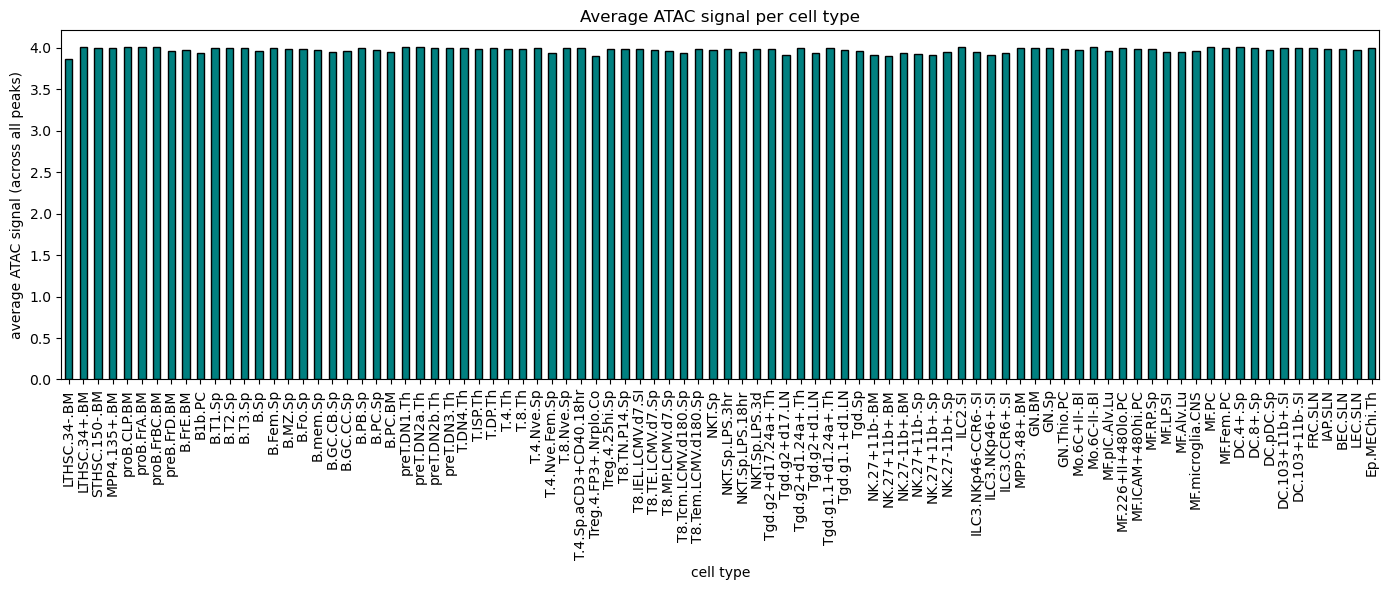

In [142]:
# matrix with all cell types and corresponding ATAC-seq peaks
celltype_columns = ATAC_scaled.columns[2:92] 

# mean per cell type (across all peaks)
celltype_means = ATAC[celltype_columns].mean()

# plot
plt.figure(figsize=(14, 6))
celltype_means.plot(kind="bar", color="teal", edgecolor="black")
plt.ylabel("average ATAC signal (across all peaks)")
plt.xlabel("cell type")
plt.title("Average ATAC signal per cell type")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



In [143]:
# load the converted QC matric 
QC_conv_num = pd.read_csv("data/QC_converted_numerical.CSV")
QC_conv_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Data columns (total 7 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   CellType                                    181 non-null    object 
 1   InputCellNumber                             181 non-null    int64  
 2   PF.reads                                    181 non-null    int64  
 3   %chrM.mapped                                181 non-null    float64
 4   Paired.read.after.removing.PCR.duplication  181 non-null    int64  
 5   %fragment.1Kb_TSS                           181 non-null    float64
 6   Replicate.cor                               176 non-null    float64
dtypes: float64(3), int64(3), object(1)
memory usage: 10.0+ KB


In [144]:
#stats per celltype 
celltype_columns = ATAC.columns[8:]  

ATAC_stats_per_celltype = pd.DataFrame({
    'ATAC_mean':   ATAC[celltype_columns].mean(axis=0),
    'ATAC_median': ATAC[celltype_columns].median(axis=0),
    'ATAC_std':    ATAC[celltype_columns].std(axis=0),
    'ATAC_var':    ATAC[celltype_columns].var(axis=0),
    'ATAC_min':    ATAC[celltype_columns].min(axis=0),
    'ATAC_max':    ATAC[celltype_columns].max(axis=0)})


ATAC_stats_per_celltype = ATAC_stats_per_celltype.reset_index().rename(columns={'index': 'CellType'})

In [145]:
# merge
QC_stats = pd.merge(QC_conv_num, ATAC_stats_per_celltype, on='CellType', how='inner')
print(QC_stats.head())

        CellType  InputCellNumber  PF.reads  %chrM.mapped  \
0   LTHSC.34-.BM              677  22287984          4.58   
1   LTHSC.34+.BM             2483  28588536          3.17   
2  STHSC.150-.BM             3660  22170346          3.25   
3   MPP4.135+.BM            10000  24003590         13.83   
4    proB.CLP.BM            10000  23578208          7.67   

   Paired.read.after.removing.PCR.duplication  %fragment.1Kb_TSS  \
0                                     2470102              10.60   
1                                     7675501               7.70   
2                                     6060045              11.13   
3                                     6128252              18.96   
4                                     6588564              13.21   

   Replicate.cor  ATAC_mean  ATAC_median   ATAC_std    ATAC_var  ATAC_min  \
0            NaN   3.868438         0.41  10.004101  100.082044      0.41   
1            NaN   4.005767         1.64   9.986633   99.732838      0

In [146]:
QC_stats.head()

CellType  InputCellNumber  PF.reads  %chrM.mapped  \
0   LTHSC.34-.BM              677  22287984          4.58   
1   LTHSC.34+.BM             2483  28588536          3.17   
2  STHSC.150-.BM             3660  22170346          3.25   
3   MPP4.135+.BM            10000  24003590         13.83   
4    proB.CLP.BM            10000  23578208          7.67   

   Paired.read.after.removing.PCR.duplication  %fragment.1Kb_TSS  \
0                                     2470102              10.60   
1                                     7675501               7.70   
2                                     6060045              11.13   
3                                     6128252              18.96   
4                                     6588564              13.21   

   Replicate.cor  ATAC_mean  ATAC_median   ATAC_std    ATAC_var  ATAC_min  \
0            NaN   3.868438         0.41  10.004101  100.082044      0.41   
1            NaN   4.005767         1.64   9.986633   99.732838      0.10   
2            NaN   4.001125         0.90   9.991892   99.837909      0.11   
3            NaN   4.002324         1.58   9.994831   99.896643      0.11   
4          0.868   4.008413         1.26   9.772241   95.496691      0.11   

   ATAC_max  
0    727.42  
1    727.42  
2    727.42  
3    727.42  
4    727.42

In [147]:

#ATAC means into data frame
ATAC_mean_df = celltype_means.reset_index()
ATAC_mean_df.columns = ['CellType', 'ATAC_mean']

#group QC/ 
QC_mean = QC_conv_num.groupby("CellType").mean()

#link mean values with the QC data
ATAC_combined = pd.merge(ATAC_mean_df, QC_mean, on='CellType')
ATAC_combined = ATAC_combined.rename(columns={0: "ATAC_mean"})

ATAC_combined.head()


CellType  ATAC_mean  InputCellNumber    PF.reads  %chrM.mapped  \
0   LTHSC.34-.BM   3.868438            677.0  22287984.0         4.580   
1   LTHSC.34+.BM   4.005767           2483.0  28588536.0         3.170   
2  STHSC.150-.BM   4.001125           3660.0  22170346.0         3.250   
3   MPP4.135+.BM   4.002324          10000.0  24003590.0        13.830   
4    proB.CLP.BM   4.008413          10000.0  21903414.0         9.035   

   Paired.read.after.removing.PCR.duplication  %fragment.1Kb_TSS  \
0                                   2470102.0             10.600   
1                                   7675501.0              7.700   
2                                   6060045.0             11.130   
3                                   6128252.0             18.960   
4                                   6347376.5             15.605   

   Replicate.cor  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4          0.868

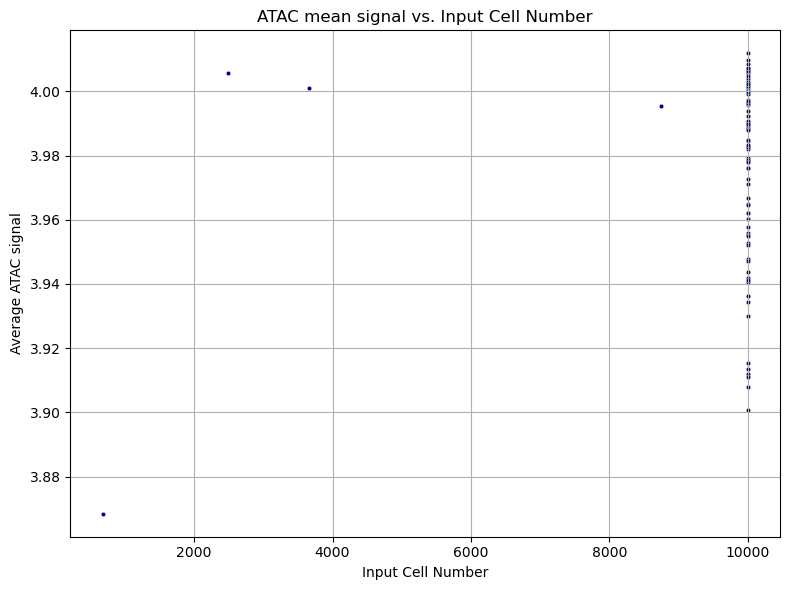

In [148]:
#scatterplot of ATAC-Signal vs. Input Cell number
plt.figure(figsize=(8, 6))
sns.scatterplot(data=ATAC_combined, x="InputCellNumber", y="ATAC_mean", alpha=1.0, s=10, color="darkblue")

plt.xlabel("Input Cell Number")
plt.ylabel("Average ATAC signal")
plt.title("ATAC mean signal vs. Input Cell Number")
plt.grid(True)
plt.tight_layout()
plt.show()

In [149]:
# does input cell number really just contain 10.000?
ATAC_combined["InputCellNumber"].value_counts()

InputCellNumber
10000.0    85
677.0       1
2483.0      1
3660.0      1
8750.0      1
Name: count, dtype: int64

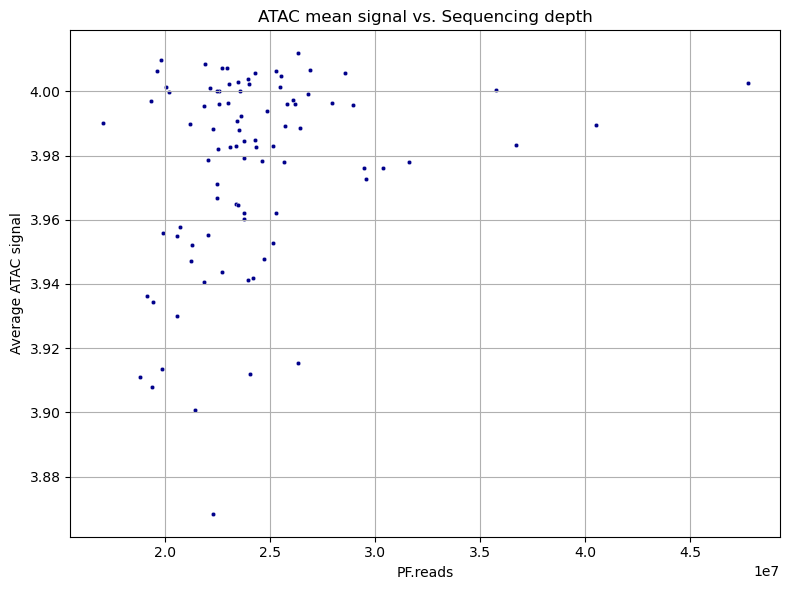

In [150]:
#scatterplot of ATAC-Signal vs. Sequencing depth
plt.figure(figsize=(8, 6))
sns.scatterplot(data=ATAC_combined, x="PF.reads", y="ATAC_mean", alpha=1.0, s=10, color="darkblue")

plt.xlabel("PF.reads")
plt.ylabel("Average ATAC signal")
plt.title("ATAC mean signal vs. Sequencing depth")
plt.grid(True)
plt.tight_layout()
plt.show()

#says how many reads there are -> more mean better information 
# do you only look at strongly open parts (low sequencing depth) or also at weakly open parts (high depth)

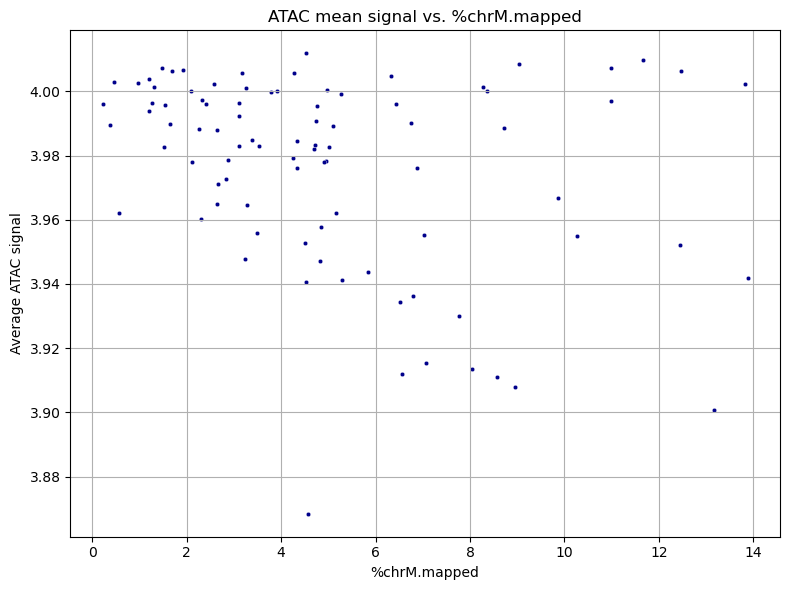

In [151]:
#scatterplot of ATAC-Signal vs. %chrM.mapped
plt.figure(figsize=(8, 6))
sns.scatterplot(data=ATAC_combined, x="%chrM.mapped", y="ATAC_mean", alpha=1.0, s=10, color="darkblue")

plt.xlabel("%chrM.mapped")
plt.ylabel("Average ATAC signal")
plt.title("ATAC mean signal vs. %chrM.mapped")
plt.grid(True)
plt.tight_layout()
plt.show()

#how many reads are from mitochondria (not useful)

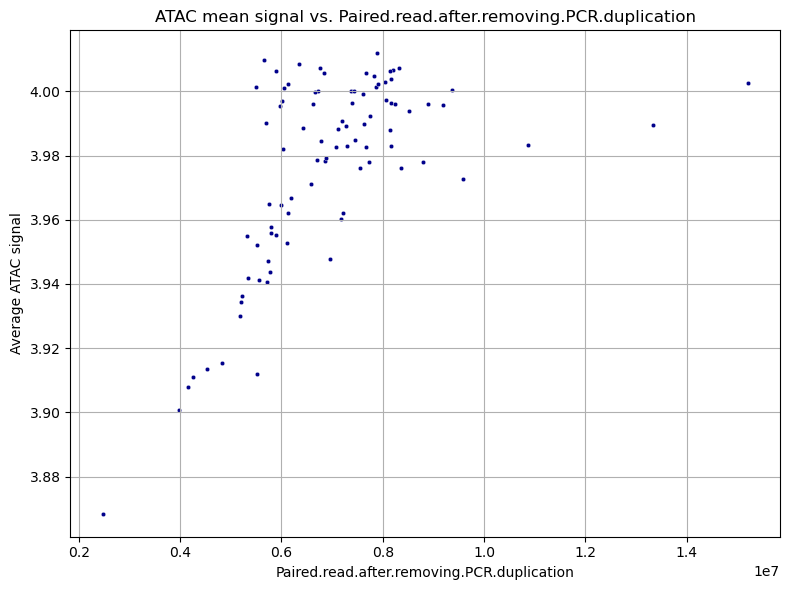

In [152]:
#scatterplot of ATAC-Signal vs. Paired.read.after.removing.PCR.duplication
plt.figure(figsize=(8, 6))
sns.scatterplot(data=ATAC_combined, x="Paired.read.after.removing.PCR.duplication", y="ATAC_mean", alpha=1.0, s=10, color="darkblue")

plt.xlabel("Paired.read.after.removing.PCR.duplication")
plt.ylabel("Average ATAC signal")
plt.title("ATAC mean signal vs. Paired.read.after.removing.PCR.duplication")
plt.grid(True)
plt.tight_layout()
plt.show()

#how many unique reads after removing duplications 

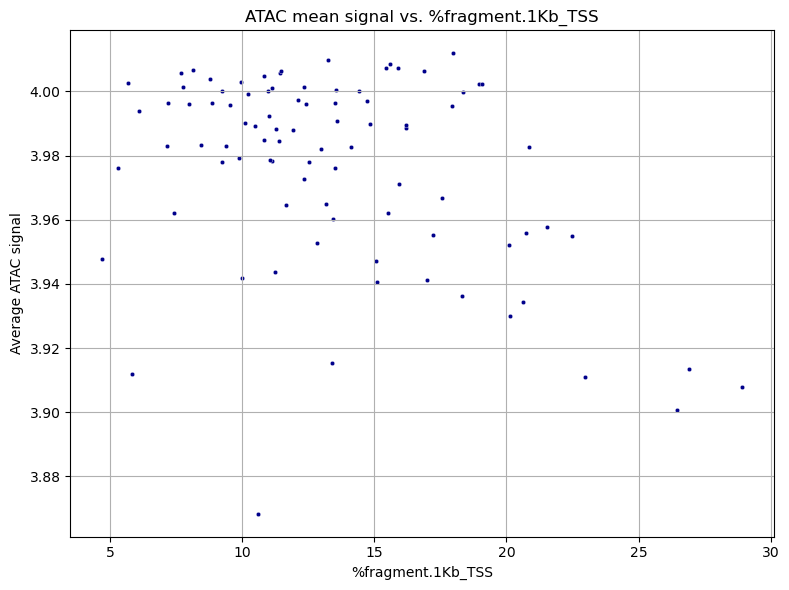

In [153]:
#scatterplot of ATAC-Signal vs. %fragment.1Kb_TSS
plt.figure(figsize=(8, 6))
sns.scatterplot(data=ATAC_combined, x="%fragment.1Kb_TSS", y="ATAC_mean", alpha=1.0, s=10, color="darkblue")

plt.xlabel("%fragment.1Kb_TSS")
plt.ylabel("Average ATAC signal")
plt.title("ATAC mean signal vs. %fragment.1Kb_TSS")
plt.grid(True)
plt.tight_layout()
plt.show()

#how many reads are close to start of gene

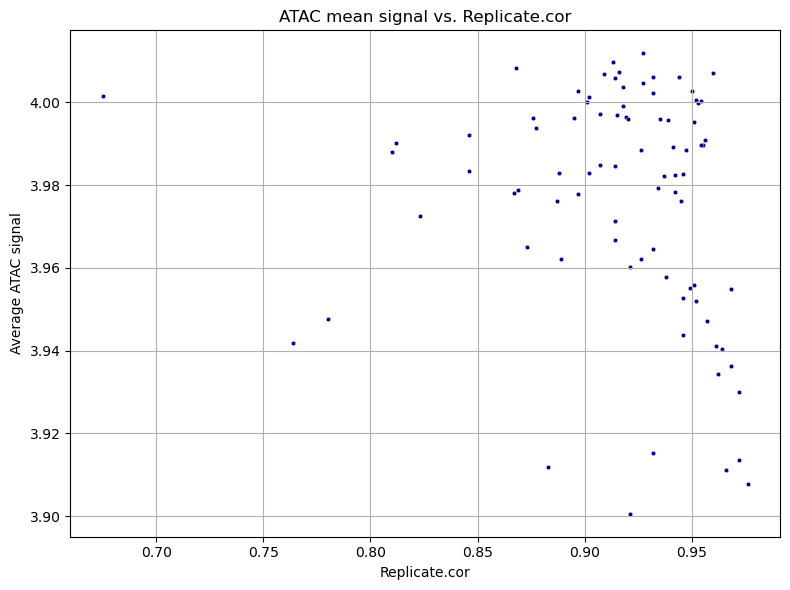

In [154]:
#scatterplot of ATAC-Signal vs. Replicate.cor
plt.figure(figsize=(8, 6))
sns.scatterplot(data=ATAC_combined, x="Replicate.cor", y="ATAC_mean", alpha=1.0, s=10, color="darkblue")

plt.xlabel("Replicate.cor")
plt.ylabel("Average ATAC signal")
plt.title("ATAC mean signal vs. Replicate.cor")
plt.grid(True)
plt.tight_layout()
plt.show()

#how similar was the experiment when doing it multiple times 

In [155]:
ATAC_combined.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 8 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   CellType                                    89 non-null     object 
 1   ATAC_mean                                   89 non-null     float64
 2   InputCellNumber                             89 non-null     float64
 3   PF.reads                                    89 non-null     float64
 4   %chrM.mapped                                89 non-null     float64
 5   Paired.read.after.removing.PCR.duplication  89 non-null     float64
 6   %fragment.1Kb_TSS                           89 non-null     float64
 7   Replicate.cor                               84 non-null     float64
dtypes: float64(7), object(1)
memory usage: 5.7+ KB


In [156]:
#ATAC combined nur float 
ATAC_combined_num = ATAC_combined.iloc[:, 1:8]
ATAC_combined_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 7 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   ATAC_mean                                   89 non-null     float64
 1   InputCellNumber                             89 non-null     float64
 2   PF.reads                                    89 non-null     float64
 3   %chrM.mapped                                89 non-null     float64
 4   Paired.read.after.removing.PCR.duplication  89 non-null     float64
 5   %fragment.1Kb_TSS                           89 non-null     float64
 6   Replicate.cor                               84 non-null     float64
dtypes: float64(7)
memory usage: 5.0 KB


In [157]:
QC_cols = ['InputCellNumber', 'PF.reads', '%chrM.mapped',
           'Paired.read.after.removing.PCR.duplication',
           '%fragment.1Kb_TSS', 'Replicate.cor']

ATAC_stat_cols = ['ATAC_mean', 'ATAC_median', 'ATAC_std', 'ATAC_var', 'ATAC_min', 'ATAC_max']

corr_matrix = QC_stats[QC_cols + ATAC_stat_cols].corr()

corr_sub = corr_matrix.loc[QC_cols, ATAC_stat_cols]

In [158]:
corr_matrix

InputCellNumber  PF.reads  \
InputCellNumber                                    1.000000  0.007069   
PF.reads                                           0.007069  1.000000   
%chrM.mapped                                       0.041585 -0.310952   
Paired.read.after.removing.PCR.duplication         0.125232  0.857731   
%fragment.1Kb_TSS                                  0.071093 -0.359143   
Replicate.cor                                     -0.075082 -0.107591   
ATAC_mean                                          0.116010  0.209994   
ATAC_median                                        0.364180  0.228306   
ATAC_std                                          -0.239902 -0.176406   
ATAC_var                                          -0.242660 -0.177782   
ATAC_min                                          -0.397420 -0.198695   
ATAC_max                                          -0.036634 -0.113948   

                                            %chrM.mapped  \
InputCellNumber                                 0.041585   
PF.reads                                       -0.310952   
%chrM.mapped                                    1.000000   
Paired.read.after.removing.PCR.duplication     -0.542430   
%fragment.1Kb_TSS                               0.463512   
Replicate.cor                                   0.078228   
ATAC_mean                                      -0.306152   
ATAC_median                                    -0.301310   
ATAC_std                                        0.236212   
ATAC_var                                        0.237437   
ATAC_min                                        0.304521   
ATAC_max                                        0.229303   

                                            Paired.read.after.removing.PCR.duplication  \
InputCellNumber                                                               0.125232   
PF.reads                                                                      0.857731   
%chrM.mapped                                                                 -0.542430   
Paired.read.after.removing.PCR.duplication                                    1.000000   
%fragment.1Kb_TSS                                                            -0.455219   
Replicate.cor                                                                -0.155149   
ATAC_mean                                                                     0.496486   
ATAC_median                                                                   0.347703   
ATAC_std                                                                     -0.272233   
ATAC_var                                                                     -0.274299   
ATAC_min                                                                     -0.479955   
ATAC_max                                                                     -0.184996   

                                            %fragment.1Kb_TSS  Replicate.cor  \
InputCellNumber                                      0.071093      -0.075082   
PF.reads                                            -0.359143      -0.107591   
%chrM.mapped                                         0.463512       0.078228   
Paired.read.after.removing.PCR.duplication          -0.455219      -0.155149   
%fragment.1Kb_TSS                                    1.000000       0.451359   
Replicate.cor                                        0.451359       1.000000   
ATAC_mean                                           -0.355557      -0.169903   
ATAC_median                                         -0.452421      -0.385020   
ATAC_std                                             0.514303       0.932964   
ATAC_var                                             0.515786       0.932046   
ATAC_min                                             0.371925       0.242631   
ATAC_max                                             0.025782       0.013104   

                                            ATAC_mean  ATAC_median  ATAC_std  \
InputCellNumber      

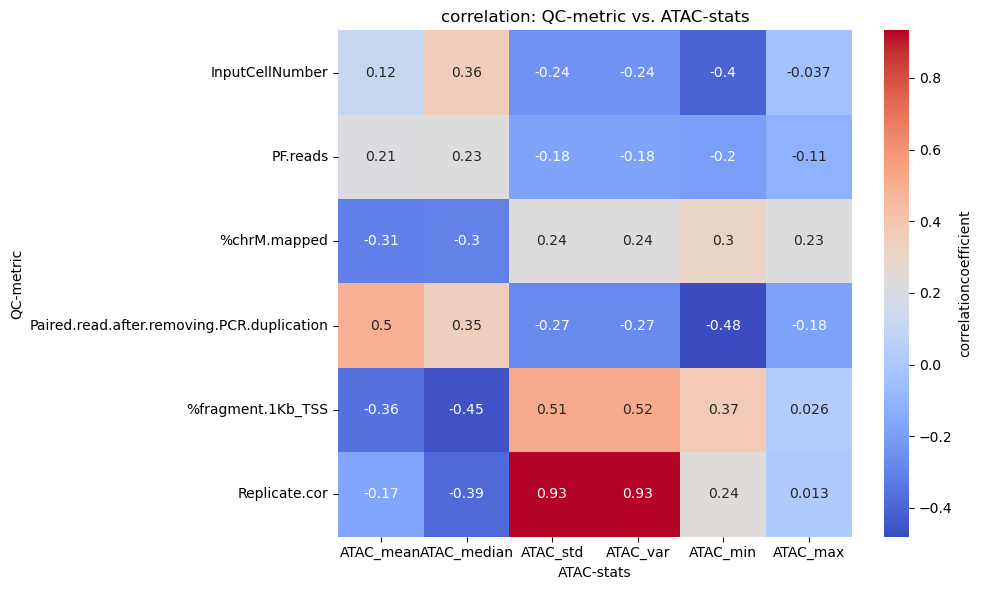

In [159]:
plt.figure(figsize=(10, 6))
sns.heatmap(corr_sub, annot=True, cmap='coolwarm', cbar_kws={'label': 'correlationcoefficient'})
plt.title("correlation: QC-metric vs. ATAC-stats")
plt.xlabel("ATAC-stats")
plt.ylabel("QC-metric")
plt.tight_layout()
plt.savefig("figures/Heatmap_QC_vs_ATAC.png", dpi=300, bbox_inches='tight')
plt.show()

### b) Should some cell types be removed or normalized?

In [160]:
#ATAC means into data frame
ATAC_mean_df = celltype_means.reset_index()
ATAC_mean_df.columns = ['CellType', 'ATAC_mean']

#group QC/ 
QC_mean = QC_conv_num.groupby("CellType").mean()

#link mean values with the QC data
ATAC_combined = pd.merge(ATAC_mean_df, QC_mean, on='CellType')
ATAC_combined = ATAC_combined.rename(columns={0: "ATAC_mean"})

ATAC_combined.head()


CellType  ATAC_mean  InputCellNumber    PF.reads  %chrM.mapped  \
0   LTHSC.34-.BM   3.868438            677.0  22287984.0         4.580   
1   LTHSC.34+.BM   4.005767           2483.0  28588536.0         3.170   
2  STHSC.150-.BM   4.001125           3660.0  22170346.0         3.250   
3   MPP4.135+.BM   4.002324          10000.0  24003590.0        13.830   
4    proB.CLP.BM   4.008413          10000.0  21903414.0         9.035   

   Paired.read.after.removing.PCR.duplication  %fragment.1Kb_TSS  \
0                                   2470102.0             10.600   
1                                   7675501.0              7.700   
2                                   6060045.0             11.130   
3                                   6128252.0             18.960   
4                                   6347376.5             15.605   

   Replicate.cor  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4          0.868

In [161]:
ATAC_mean_df = celltype_means.reset_index()
ATAC_mean_df.columns = ['CellType', 'ATAC_mean']
ATAC_mean_df.head()

CellType  ATAC_mean
0   LTHSC.34-.BM   3.868438
1   LTHSC.34+.BM   4.005767
2  STHSC.150-.BM   4.001125
3   MPP4.135+.BM   4.002324
4    proB.CLP.BM   4.008413

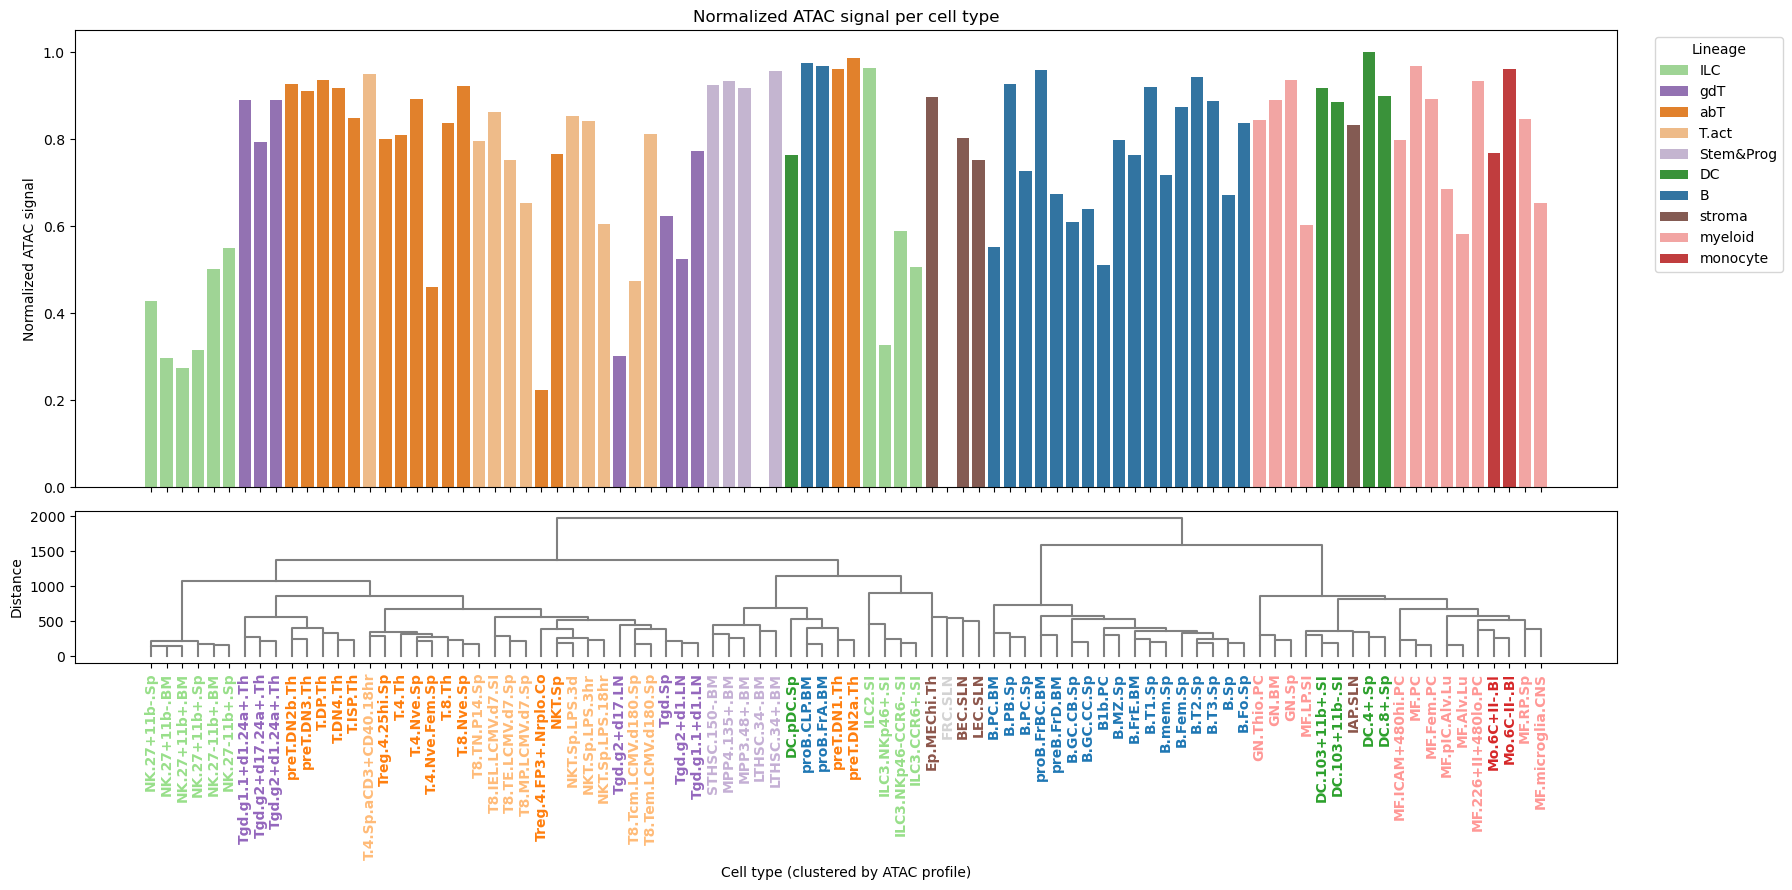

In [162]:
#ATAC means into data frame
ATAC_mean_df = celltype_means.reset_index()
ATAC_mean_df.columns = ['CellType', 'ATAC_mean']

# Min-Max normalization (0–1 scaling)
min_val = ATAC_mean_df["ATAC_mean"].min()
max_val = ATAC_mean_df["ATAC_mean"].max()
ATAC_mean_df["ATAC_mean_norm"] = (ATAC_mean_df["ATAC_mean"] - min_val) / (max_val - min_val)

QC = pd.read_csv("data/ATAC_QCmatric.csv", sep=";")
QC.columns = QC.columns.str.strip()
QC["CellType"] = QC["CellType"].str.strip()
QC["Lineage"] = QC["Lineage"].str.strip()
celltype_to_lineage = QC.drop_duplicates("CellType").set_index("CellType")["Lineage"]

# making a list first
atac_by_celltype = ATAC_scaled_ct.drop(columns="cluster", errors='ignore').T
atac_celltypes = atac_by_celltype.index.tolist()

# mapping cell types to lineage colors
celltype_to_color = {
    ct: lineage_colors.get(celltype_to_lineage.get(ct, "Unassigned"), "black")
    for ct in atac_celltypes
}

# Hierarchical clustering using Ward linkage
linkage = sch.linkage(pdist(atac_by_celltype), method="ward")

# getting dendrogram order 
ddata = sch.dendrogram(linkage, labels=atac_celltypes, no_plot=True)
ordered_celltypes = ddata['ivl']

# sorting dataframe according to dendrogram order
ATAC_mean_df_sorted = ATAC_mean_df.set_index("CellType").loc[ordered_celltypes].reset_index()
ATAC_mean_df_sorted["Lineage"] = ATAC_mean_df_sorted["CellType"].map(celltype_to_lineage)

# making plot

fig, (ax_bar, ax_den) = plt.subplots(2, 1, figsize=(18, 9), gridspec_kw={"height_ratios": [3, 1]}, sharex=True)

# Barplot with sorted cell types
sns.barplot(data=ATAC_mean_df_sorted, x="CellType", y="ATAC_mean_norm", hue="Lineage", palette=lineage_colors, dodge=False, ax=ax_bar)
ax_bar.set(title="Normalized ATAC signal per cell type", ylabel="Normalized ATAC signal", xlabel="")
ax_bar.tick_params(axis="x", rotation=90)
ax_bar.legend(bbox_to_anchor=(1.02, 1), loc="upper left", title="Lineage")

# Dendrogram coordinates
icoord = np.array(ddata['icoord'])
dcoord = np.array(ddata['dcoord'])
leaves = ddata['leaves']

# mapping dendrogram x coords to barplot tick positions
x_pos = np.arange(len(ordered_celltypes))

# drawing dendrogram lines all in the same gray color
for xs, ys in zip(icoord, dcoord):
    xs_scaled = [x_pos[int((x - 5) / 10)] for x in xs]
    ax_den.plot(xs_scaled, ys, color='gray', lw=1.5)

# making colored labels 
ax_den.set_xticks(x_pos)
ax_den.set_xticklabels(ordered_celltypes, rotation=90)
for label in ax_den.get_xticklabels():
    ct = label.get_text()
    label.set_color(celltype_to_color.get(ct, "black"))
    label.set_fontweight("bold")

ax_den.set_ylabel("Distance")
ax_den.set_xlabel("Cell type (clustered by ATAC profile)")

plt.tight_layout()
plt.savefig("figures/mean_ATAC_peaks_with_dendrogramm.png", dpi=300, bbox_inches="tight")
plt.show()


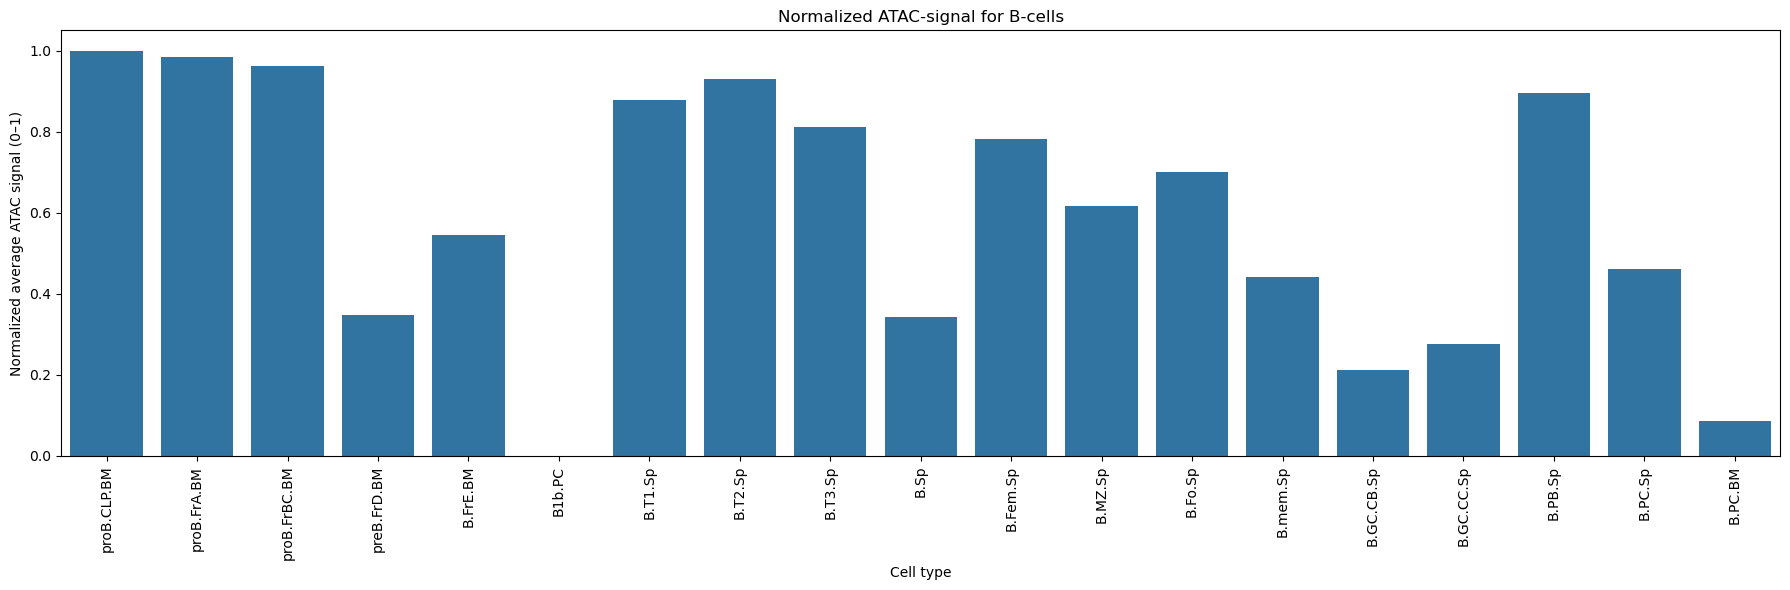

In [163]:
# Load and prepare QC matrix
QC = pd.read_csv("data/ATAC_QCmatric.csv", sep=";")
QC.columns = QC.columns.str.strip()
QC["CellType"] = QC["CellType"].str.strip()
QC["Lineage"] = QC["Lineage"].str.strip()

# Isolate only B-cell types from QC matrix
b_cell_types = QC[QC["Lineage"] == "B"]["CellType"].tolist()

# Isolate only B-cell types from ATAC_mean_df
b_cells = ATAC_mean_df[ATAC_mean_df["CellType"].isin(b_cell_types)].copy()

# Min-Max normalization (0–1 scaling) for B-cells
min_val = b_cells["ATAC_mean"].min()
max_val = b_cells["ATAC_mean"].max()
b_cells["ATAC_mean_norm"] = (b_cells["ATAC_mean"] - min_val) / (max_val - min_val)

# Plot
plt.figure(figsize=(18, 6))

sns.barplot(
    data=b_cells,
    x="CellType",
    y="ATAC_mean_norm",
    color=(0.121569, 0.466667, 0.705882)
)

plt.xticks(rotation=90)
plt.title("Normalized ATAC-signal for B-cells")
plt.ylabel("Normalized average ATAC signal (0–1)")
plt.xlabel("Cell type")
plt.tight_layout()
plt.show()


Celltypes containing a very low signal: LTHSC.34-BM
->should be removed/normalized

### ii. How variable is the chromatin signal for CREs across cells?

c:\Users\annal\miniconda3\envs\envBCells1\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


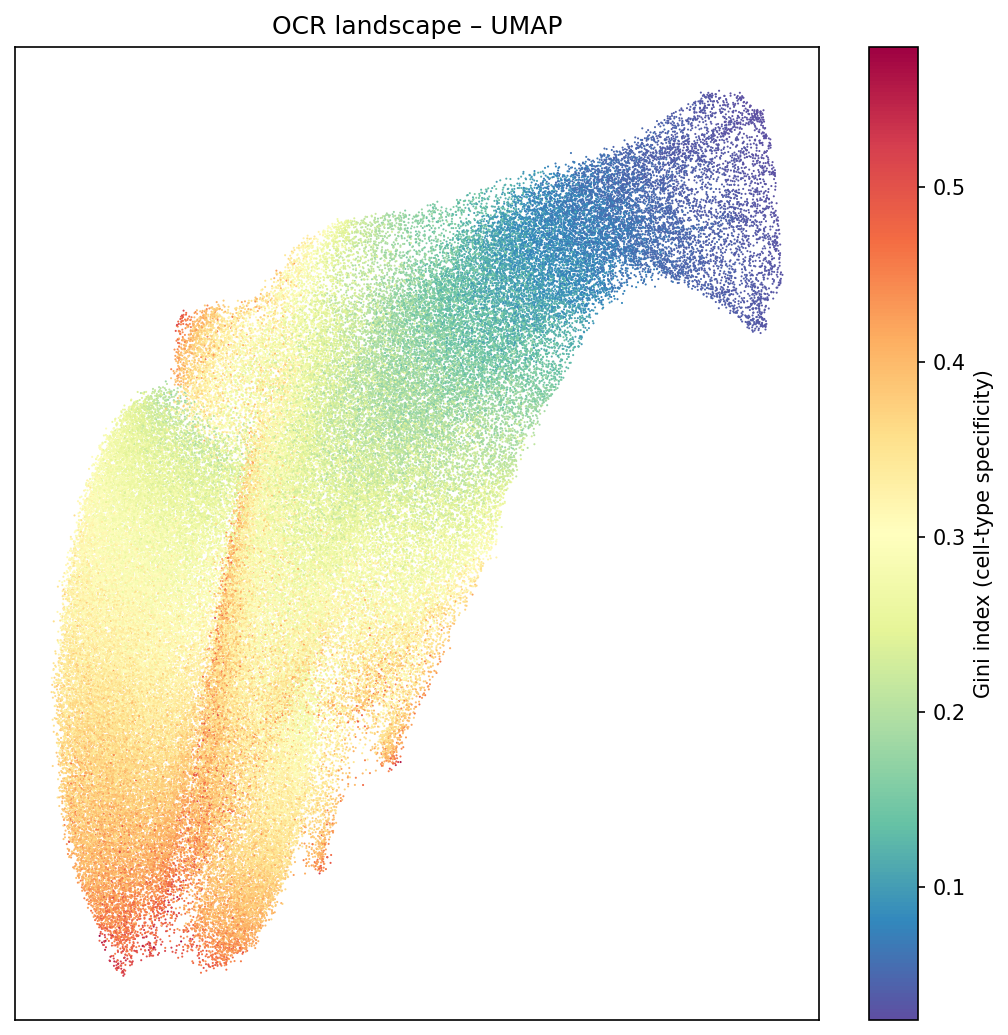

In [165]:
mat = ATAC.copy()

# adjusting the matrix: no columns with "unnamed", all cells are numbers, no infinites
mat = mat.loc[:, ~mat.columns.str.startswith("Unnamed")]
mat = (
    mat.apply(pd.to_numeric, errors="coerce")
       .replace([np.inf, -np.inf], np.nan)
       .fillna(0.0)
       .astype(np.float64) 
)

# processing: no values = 0, quantile normalization of columns
mat = np.log2(mat + 0.1)            
mat = (mat.rank(axis=0) / (len(mat) - 1)).astype(np.float32)  

# limit: 120,000 rows, safed in mat_s
MAX_PTS = 120_000                    
if len(mat) > MAX_PTS:
    rng   = np.random.default_rng(0)
    keep  = rng.choice(mat.index, size=MAX_PTS, replace=False)
    mat_s = mat.loc[keep]
else:
    mat_s = mat

# computing Gini (measure of ineaquality), applies it to mat_s: 1D array "gini_scores"
def gini(row):
    x = np.sort(row.values)
    i = np.arange(1, x.size + 1)
    return ((2 * i - x.size - 1) * x).sum() / (x.size * x.sum())
gini_scores = mat_s.apply(gini, axis=1)

# truncuated SVD reduces mat_s to 25 dimensions
svd    = TruncatedSVD(n_components=25, random_state=0)
pca_25 = svd.fit_transform(mat_s)

# reducer makes visualization in 2D possible
reducer = umap.UMAP(
    n_components=2,
    n_neighbors =30,        
    min_dist    =0.3,
    metric      ="euclidean",
    random_state=0
)
xy = reducer.fit_transform(pca_25)
fig, ax = plt.subplots(figsize=(7, 7), dpi=150)

# normalization  
norm = Normalize(gini_scores.min(), gini_scores.max())
scat = ax.scatter(
    xy[:, 0], xy[:, 1],
    c=gini_scores,
    cmap="Spectral_r",
    s=1, lw=0
)

ax.set(
    xticks=[],
    yticks=[],
    title="OCR landscape – UMAP"
)
fig.colorbar(scat, ax=ax, label="Gini index (cell-type specificity)")
plt.tight_layout()
plt.savefig("figures/OCR landscape - UMAP", dpi=300, bbox_inches="tight")
plt.show()


25,630 peaks after Gini ≥ 0.413
18,802 peaks retained after FC ≥ 3.0 & top_val ≥ 0.6
18,802 peaks retained (Gini ≥ 0.413, FC ≥ 3.0)


c:\Users\annal\miniconda3\envs\envBCells1\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


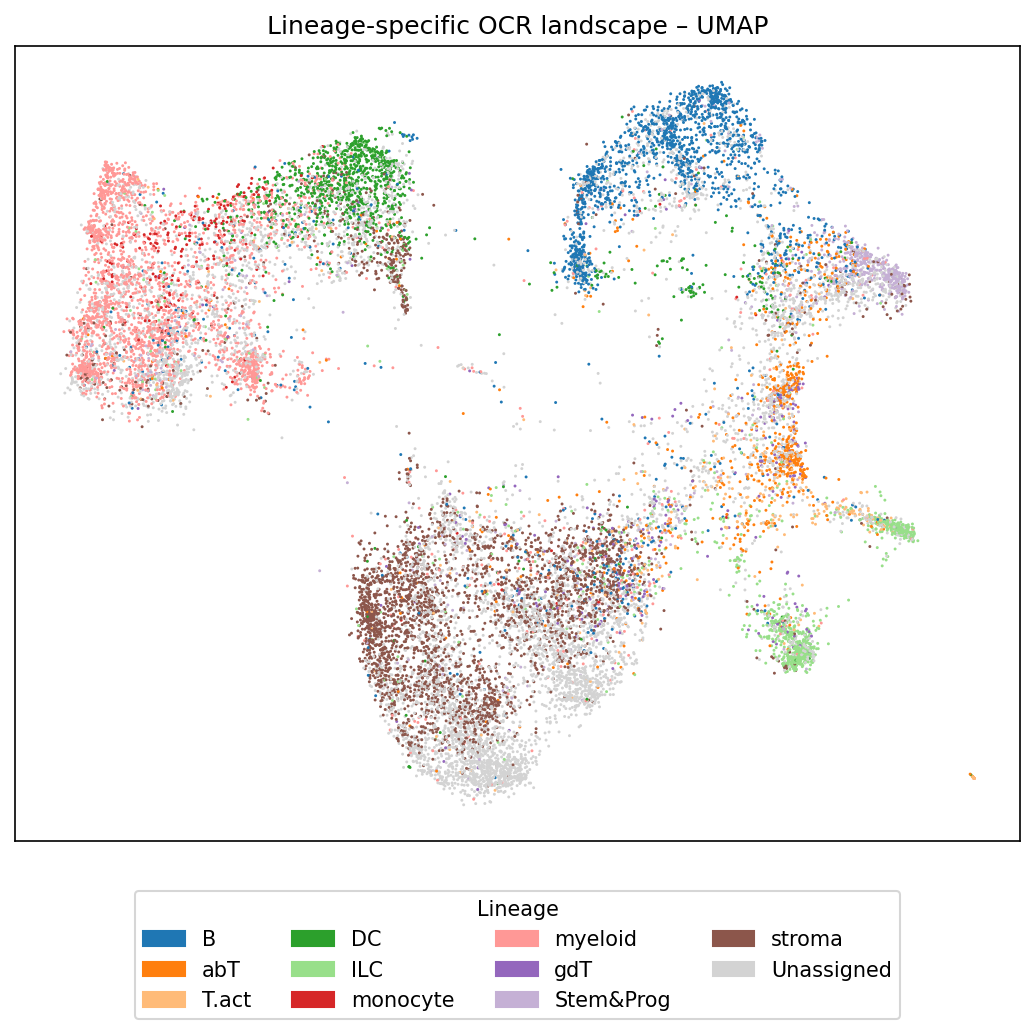

In [166]:
qc = QC.copy()

# adapted the gini function
def gini(arr):
    if arr.sum() == 0:
        return 0.0
    sorted_ = np.sort(arr)
    n       = sorted_.size
    return (2*np.arange(1, n+1)*sorted_).sum()/(n*sorted_.sum()) - (n+1)/n

gini_scores = pd.Series(
    np.apply_along_axis(gini, 1, mat.values),
    index=mat.index, name="Gini"
)

# gini cut-off and quantile filter
GINI_Q = 0.95          
FC_CUT = 3.0           
MIN_ACCESS  = 0.6      
gini_cut    = gini_scores.quantile(GINI_Q)
idx_gini    = gini_scores[gini_scores >= gini_cut].index
print(f"{len(idx_gini):,} peaks after Gini ≥ {gini_cut:.3f}")

best_ct     = mat.loc[idx_gini].idxmax(axis=1)
top_val     = mat.loc[idx_gini].max(axis=1)
other_val   = (mat.loc[idx_gini].sum(axis=1) - top_val) / (mat.shape[1] - 1)
fold_change = (top_val + 1e-6) / (other_val + 1e-6)

mask_fc     = fold_change >= FC_CUT
if MIN_ACCESS is not None:
    mask_fc &= (top_val >= MIN_ACCESS)

specific    = idx_gini[mask_fc]
print(f"{len(specific):,} peaks retained after FC ≥ {FC_CUT}"
      + (f" & top_val ≥ {MIN_ACCESS}" if MIN_ACCESS is not None else ""))

# stop execution if threshold to strict
if len(specific) == 0:
    raise ValueError("No peaks passed the chosen filters – "
                     "relax GINI_Q / FC_CUT / MIN_ACCESS.")

# map cell types to lineages
qc   = ( QC.copy()
         .drop_duplicates("CellType")
          .assign(CellType=lambda df: df["CellType"].str.strip(),
                  Lineage=lambda df: df["Lineage"].str.strip()))
celltype_to_lineage = qc.set_index("CellType")["Lineage"]

best_ct    = mat.loc[specific].idxmax(axis=1)
top_val    = mat.loc[specific].max(axis=1)
other_val  = (mat.loc[specific].sum(axis=1) - top_val) / (mat.shape[1]-1)
fold_change = (top_val+1e-6) / (other_val+1e-6)
specific    = specific[fold_change >= FC_CUT]

print(f"{len(specific):,} peaks retained (Gini ≥ {gini_cut:.3f}, FC ≥ {FC_CUT})")

# reduced matrix
mat_ls  = mat.loc[specific]

# amplifies highly specific peaks
w       = (gini_scores.loc[specific] / gini_scores.loc[specific].mean())**1.5
mat_ls  = mat_ls.mul(w, axis=0)

# dimension reduction
pca50   = TruncatedSVD(50, random_state=0).fit_transform(mat_ls)
xy      = umap.UMAP(metric="cosine", n_neighbors=10,
                    min_dist=0.05, random_state=0).fit_transform(pca50)

# align peaks with lineage
peak_max_cell = mat_ls.idxmax(axis=1)  
peak_lineage = peak_max_cell.map(celltype_to_lineage).fillna("Unassigned")

fig, ax = plt.subplots(figsize=(7,7), dpi=150)
ax.scatter(
    xy[:,0], xy[:,1],
    c=peak_lineage.map(lineage_colors).fillna("gray"),
    s=2, lw=0
)
ax.set(xticks=[], yticks=[], title="Lineage-specific OCR landscape – UMAP")

handles = [mpatches.Patch(color=c, label=l)
           for l,c in lineage_colors.items() if l in peak_lineage.values]
ax.legend(handles=handles, title="Lineage", loc="upper center",
          bbox_to_anchor=(0.5, -0.05), ncol=4)

plt.tight_layout()
plt.savefig("figures/OCR_landscape_lineage_specific.png", dpi=300)
plt.show()


### a) Should peaks be removed due to lack of signal?

In [167]:
#stats per celltype 

ATAC_stat.head()

ImmGenATAC1219.peakID chrom   Summit  mm10.60way.phastCons_scores  \
0  ImmGenATAC1219.peak_1  chr1  3020786                         0.00   
1  ImmGenATAC1219.peak_2  chr1  3087226                         0.00   
2  ImmGenATAC1219.peak_3  chr1  3120109                         0.07   
3  ImmGenATAC1219.peak_4  chr1  3121485                         0.15   
4  ImmGenATAC1219.peak_5  chr1  3372787                         0.03   

   _-log10_bestPvalue  Included.in.systematic.analysis  TSS  \
0                0.56                              NaN  NaN   
1                0.50                              NaN  NaN   
2               10.80                              1.0  NaN   
3                3.02                              1.0  NaN   
4                1.31                              NaN  NaN   

  genes.within.100Kb  LTHSC.34-.BM  LTHSC.34+.BM  ...  IAP.SLN  BEC.SLN  \
0                NaN          0.41          0.71  ...     0.10     0.57   
1                NaN          0.41          1.64  ...     0.98     2.16   
2                NaN          2.36          0.10  ...     8.92     1.33   
3                NaN          0.41          0.10  ...     0.98     1.28   
4                NaN          0.41          0.10  ...     0.75     1.33   

   LEC.SLN  Ep.MEChi.Th  mean_peak  median_peak   var_peak  std_peak  \
0     3.27         1.41   1.053556        0.710   1.013886  1.006919   
1     2.34         0.94   0.929000        0.765   0.748142  0.864952   
2     1.04         0.11   1.521000        0.495  45.111153  6.716484   
3     1.04         0.11   0.874556        0.530   2.352263  1.533709   
4     1.61         4.50   0.882111        0.630   0.666815  0.816587   

   min_peak  max_peak  
0       0.1      5.15  
1       0.1      3.87  
2       0.1     63.38  
3       0.1     13.50  
4       0.1      4.50  

[5 rows x 104 columns]

- no need to remove peaks

### b) Do promoters exhibit specific signals vs enhancers?

In [168]:
Annotation = pd.read_csv("data/Transcript, Coding, and Exon Start and End Positions.CSV", sep=";")
Annotation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47382 entries, 0 to 47381
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gene Name               47382 non-null  object
 1   Transcript Name         47382 non-null  object
 2   Chromosome              47382 non-null  object
 3   Strand                  47382 non-null  object
 4   5' transcript Start     47382 non-null  int64 
 5   3' Transcript Start     47382 non-null  int64 
 6   Coding Region 5' Start  47382 non-null  int64 
 7   Coding Region 3' Start  47382 non-null  int64 
 8   Exon Count              47382 non-null  int64 
 9   Exon Starts             47382 non-null  object
 10  Exon Ends               47382 non-null  object
dtypes: int64(5), object(6)
memory usage: 4.0+ MB


In [169]:
Annotation.head()

Gene Name Transcript Name Chromosome Strand  5' transcript Start  \
0    Wdsub1    NM_001159636       chr2      -             59855193   
1     Rbm18    NM_001159635       chr2      -             36116078   
2    Prrc2b    NM_001159634       chr2      +             32151147   
3     Ildr2    NM_001164528       chr1      +            166254138   
4     Perm1       NM_172417       chr4      +            156215926   

   3' Transcript Start   Coding Region 5' Start  Coding Region 3' Start  \
0              59882606                59855270                59878527   
1              36136704                36117814                36134247   
2              32234537                32182511                32230742   
3             166316832               166254375               166310795   
4             156221307               156217000               156220222   

   Exon Count                                       Exon Starts   \
0          11  59855193,59858609,59861560,59862619,59862816,5...   
1           6  36116078,36120812,36122851,36127214,36134134,3...   
2          32  32151147,32182457,32183122,32185344,32187480,3...   
3          10  166254138,166269304,166270498,166291415,166294...   
4           4           156215926,156216716,156219740,156220109,   

                                           Exon Ends  
0  59855275,59858750,59861737,59862726,59862857,5...  
1  36117974,36120898,36122938,36127251,36134263,3...  
2  32151291,32182626,32183300,32185447,32187553,3...  
3  166254466,166269637,166270618,166291472,166294...  
4           156215975,156219185,156219866,156221307,

In [170]:
#names of coloumns
for col in Annotation.columns:
    print(repr(col))

'Gene Name'
'Transcript Name'
'Chromosome'
'Strand'
"5' transcript Start"
"3' Transcript Start "
"Coding Region 5' Start"
"Coding Region 3' Start"
'Exon Count'
'Exon Starts '
'Exon Ends'


In [171]:
# TSS (difference between 5´ and 3´)

def get_tss(row):
    if row['Strand'] == '+':
        return row["5' transcript Start"]
    else:
        return row["3' Transcript Start "]
    
    
Annotation['TSS'] = Annotation.apply(get_tss, axis=1)
Annotation.head()

Gene Name Transcript Name Chromosome Strand  5' transcript Start  \
0    Wdsub1    NM_001159636       chr2      -             59855193   
1     Rbm18    NM_001159635       chr2      -             36116078   
2    Prrc2b    NM_001159634       chr2      +             32151147   
3     Ildr2    NM_001164528       chr1      +            166254138   
4     Perm1       NM_172417       chr4      +            156215926   

   3' Transcript Start   Coding Region 5' Start  Coding Region 3' Start  \
0              59882606                59855270                59878527   
1              36136704                36117814                36134247   
2              32234537                32182511                32230742   
3             166316832               166254375               166310795   
4             156221307               156217000               156220222   

   Exon Count                                       Exon Starts   \
0          11  59855193,59858609,59861560,59862619,59862816,5...   
1           6  36116078,36120812,36122851,36127214,36134134,3...   
2          32  32151147,32182457,32183122,32185344,32187480,3...   
3          10  166254138,166269304,166270498,166291415,166294...   
4           4           156215926,156216716,156219740,156220109,   

                                           Exon Ends        TSS  
0  59855275,59858750,59861737,59862726,59862857,5...   59882606  
1  36117974,36120898,36122938,36127251,36134263,3...   36136704  
2  32151291,32182626,32183300,32185447,32187553,3...   32151147  
3  166254466,166269637,166270618,166291472,166294...  166254138  
4           156215975,156219185,156219866,156221307,  156215926

In [172]:
tss_dict = {}
for chrom in Annotation['Chromosome'].unique():
    tss_positions = Annotation.loc[Annotation['Chromosome'] == chrom, 'TSS'].values
    tss_positions = np.sort(tss_positions)
    tss_dict[chrom] = tss_positions

In [173]:
def nearest_tss_distance(row):
    chrom = row['chrom']
    peak_pos = row['Summit']
    
    if chrom not in tss_dict:
        return np.nan  
    
    tss_positions = tss_dict[chrom]
    idx = np.searchsorted(tss_positions, peak_pos)
    
    left = tss_positions[idx-1] if idx > 0 else None
    right = tss_positions[idx] if idx < len(tss_positions) else None
    
    dist_left = peak_pos - left if left is not None else np.inf
    dist_right = right - peak_pos if right is not None else np.inf
    
    if abs(dist_left) <= abs(dist_right):
        return dist_left  
    else:
        return -dist_right

In [174]:
ATAC_with_TSS = ATAC.copy()
ATAC_with_TSS['distance_to_nearest_TSS'] = ATAC_with_TSS.apply(nearest_tss_distance, axis=1)
ATAC_with_TSS.head()


ImmGenATAC1219.peakID chrom   Summit  mm10.60way.phastCons_scores  \
0  ImmGenATAC1219.peak_1  chr1  3020786                         0.00   
1  ImmGenATAC1219.peak_2  chr1  3087226                         0.00   
2  ImmGenATAC1219.peak_3  chr1  3120109                         0.07   
3  ImmGenATAC1219.peak_4  chr1  3121485                         0.15   
4  ImmGenATAC1219.peak_5  chr1  3372787                         0.03   

   _-log10_bestPvalue  Included.in.systematic.analysis  TSS  \
0                0.56                              NaN  NaN   
1                0.50                              NaN  NaN   
2               10.80                              1.0  NaN   
3                3.02                              1.0  NaN   
4                1.31                              NaN  NaN   

  genes.within.100Kb  LTHSC.34-.BM  LTHSC.34+.BM  ...  DC.8+.Sp  DC.pDC.Sp  \
0                NaN          0.41          0.71  ...      0.10       3.19   
1                NaN          0.41          1.64  ...      0.10       1.41   
2                NaN          2.36          0.10  ...      0.54       2.72   
3                NaN          0.41          0.10  ...      1.83       0.66   
4                NaN          0.41          0.10  ...      0.10       0.66   

   DC.103+11b+.SI  DC.103+11b-.SI  FRC.SLN  IAP.SLN  BEC.SLN  LEC.SLN  \
0            1.37            0.52     1.27     0.10     0.57     3.27   
1            0.47            0.11     0.92     0.98     2.16     2.34   
2            0.95            0.11    63.38     8.92     1.33     1.04   
3            0.11            0.92    13.50     0.98     1.28     1.04   
4            1.79            0.51     0.92     0.75     1.33     1.61   

   Ep.MEChi.Th  distance_to_nearest_TSS  
0         1.41                -650712.0  
1         0.94                -584272.0  
2         0.11                -551389.0  
3         0.11                -550013.0  
4         4.50                -298711.0  

[5 rows x 99 columns]

In [175]:
ATAC_with_TSS.to_csv("data/ATAC_with_TSS.csv")

In [176]:
def annotate_peak(distance):
    if pd.isna(distance):
        return 'unknown'
    elif -150 <= distance <= 50:
        return 'promoter'
    else:
        return 'enhancer'

ATAC_regiontype = ATAC_with_TSS.copy()
ATAC_regiontype['annotation'] = ATAC_with_TSS['distance_to_nearest_TSS'].apply(annotate_peak)
ATAC_regiontype = ATAC_regiontype[ATAC_regiontype['annotation'] != 'unknown']

In [177]:
ATAC_rt_signal_columns = ATAC_regiontype.columns[8:98]  
ATAC_regiontype['mean_signal_all_celltypes'] = ATAC_regiontype[ATAC_rt_signal_columns].mean(axis=1)


In [178]:
ATAC_regiontype.head()

ImmGenATAC1219.peakID chrom   Summit  mm10.60way.phastCons_scores  \
0  ImmGenATAC1219.peak_1  chr1  3020786                         0.00   
1  ImmGenATAC1219.peak_2  chr1  3087226                         0.00   
2  ImmGenATAC1219.peak_3  chr1  3120109                         0.07   
3  ImmGenATAC1219.peak_4  chr1  3121485                         0.15   
4  ImmGenATAC1219.peak_5  chr1  3372787                         0.03   

   _-log10_bestPvalue  Included.in.systematic.analysis  TSS  \
0                0.56                              NaN  NaN   
1                0.50                              NaN  NaN   
2               10.80                              1.0  NaN   
3                3.02                              1.0  NaN   
4                1.31                              NaN  NaN   

  genes.within.100Kb  LTHSC.34-.BM  LTHSC.34+.BM  ...  DC.103+11b+.SI  \
0                NaN          0.41          0.71  ...            1.37   
1                NaN          0.41          1.64  ...            0.47   
2                NaN          2.36          0.10  ...            0.95   
3                NaN          0.41          0.10  ...            0.11   
4                NaN          0.41          0.10  ...            1.79   

   DC.103+11b-.SI  FRC.SLN  IAP.SLN  BEC.SLN  LEC.SLN  Ep.MEChi.Th  \
0            0.52     1.27     0.10     0.57     3.27         1.41   
1            0.11     0.92     0.98     2.16     2.34         0.94   
2            0.11    63.38     8.92     1.33     1.04         0.11   
3            0.92    13.50     0.98     1.28     1.04         0.11   
4            0.51     0.92     0.75     1.33     1.61         4.50   

   distance_to_nearest_TSS  annotation  mean_signal_all_celltypes  
0                -650712.0    enhancer                   1.053556  
1                -584272.0    enhancer                   0.929000  
2                -551389.0    enhancer                   1.521000  
3                -550013.0    enhancer                   0.874556  
4                -298711.0    enhancer                   0.882111  

[5 rows x 101 columns]

In [179]:
ATAC_regiontype.info()

<class 'pandas.core.frame.DataFrame'>
Index: 512384 entries, 0 to 512594
Columns: 101 entries, ImmGenATAC1219.peakID to mean_signal_all_celltypes
dtypes: float64(95), int64(1), object(5)
memory usage: 398.7+ MB


In [180]:
ATAC_regiontype.to_csv("data/ATAC_regiontype.csv")

Histogram

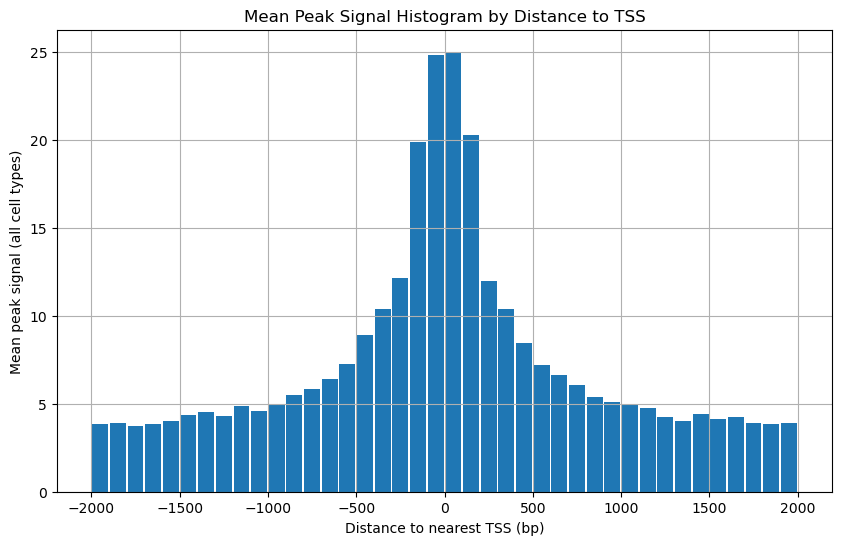

In [181]:
bins = np.arange(-2000, 2001, 100)

ATAC_regiontype['distance_bin'] = pd.cut(ATAC_regiontype['distance_to_nearest_TSS'], bins)

mean_signal_per_bin = ATAC_regiontype.groupby('distance_bin')['mean_signal_all_celltypes'].mean()

bin_centers = bins[:-1] + np.diff(bins) / 2

plt.figure(figsize=(10,6))
plt.bar(bin_centers, mean_signal_per_bin.values, width=90, align='center')
plt.xlabel('Distance to nearest TSS (bp)')
plt.ylabel('Mean peak signal (all cell types)')
plt.title('Mean Peak Signal Histogram by Distance to TSS')
plt.grid(True)
plt.savefig("figures/Histogramm_mean_per_TSS_distance", dpi=300, bbox_inches='tight')
plt.show()

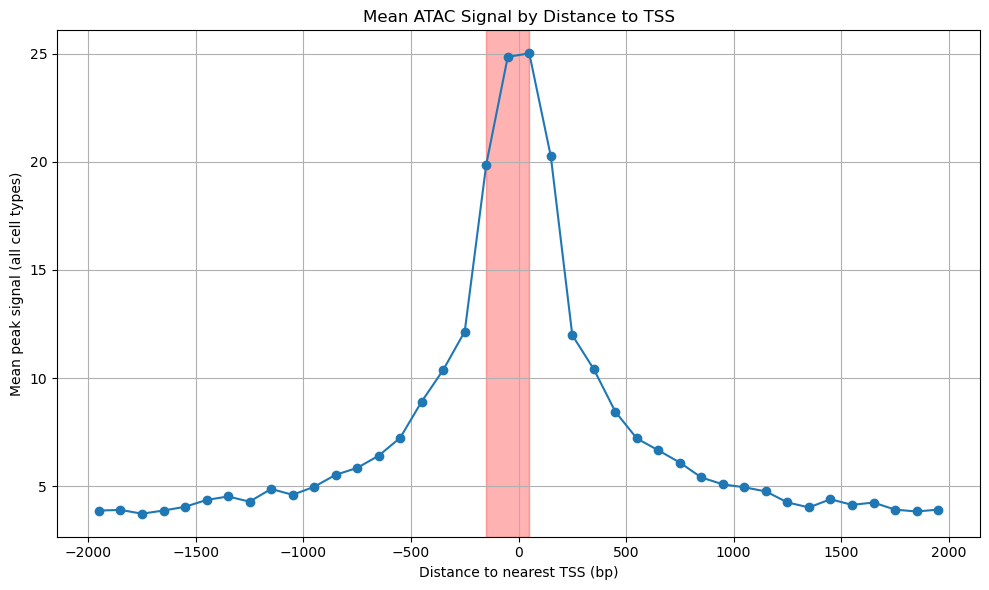

In [182]:
bins = np.arange(-2000, 2001, 100)
ATAC_regiontype['distance_bin'] = pd.cut(ATAC_regiontype['distance_to_nearest_TSS'], bins)

mean_signal_per_bin = ATAC_regiontype.groupby('distance_bin')['mean_signal_all_celltypes'].mean()

bin_centers = bins[:-1] + np.diff(bins) / 2

plt.figure(figsize=(10,6))
plt.plot(bin_centers, mean_signal_per_bin.values, marker='o')
plt.xlabel('Distance to nearest TSS (bp)')
plt.ylabel('Mean peak signal (all cell types)')
plt.title('Mean ATAC Signal by Distance to TSS')
plt.grid(True)
plt.tight_layout()
plt.axvspan(-150, 50, color='red', alpha=0.3, label='TSS window')
plt.savefig("figures/Lineplot_mean_signal_TSS_distance", dpi=300)
plt.show()

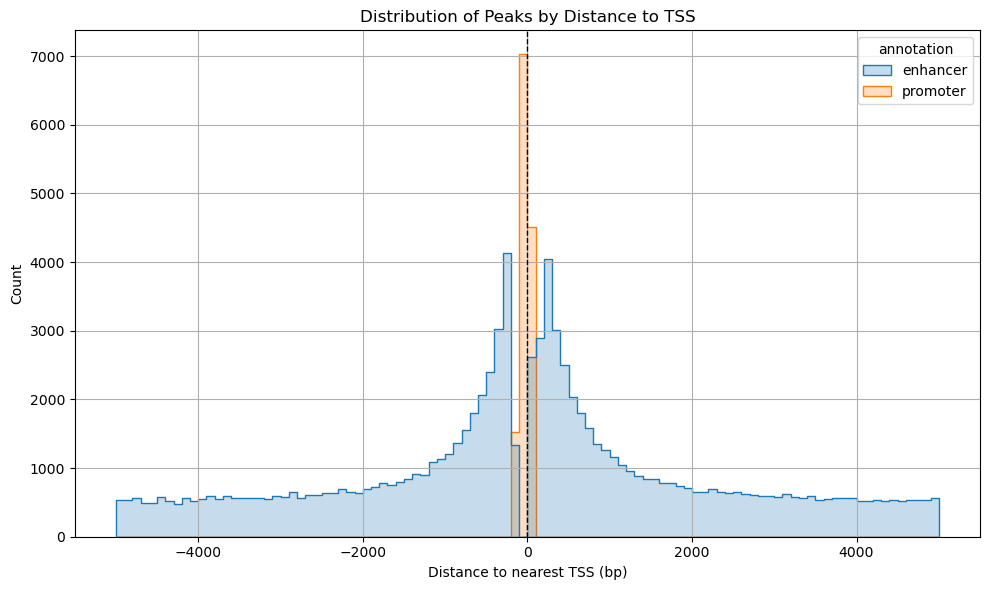

In [183]:
ATAC_rt_subset = ATAC_regiontype.query("distance_to_nearest_TSS >= -5000 and distance_to_nearest_TSS <= 5000")
plt.figure(figsize=(10, 6))
sns.histplot(
    data=ATAC_rt_subset,
    x="distance_to_nearest_TSS",
    hue="annotation",  
    bins=100,
    element="step",  
    stat="count",    
    common_norm=False)

plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel("Distance to nearest TSS (bp)")
plt.ylabel("Count")
plt.title("Distribution of Peaks by Distance to TSS")
plt.grid(True)
plt.tight_layout()
plt.savefig("figures/Histogramm_mean_per_TSS_distance_with_Annotation", dpi=300, bbox_inches='tight')
plt.show()

Boxplot

In [184]:
if 'chrom' in ATAC_regiontype.index.names:
    ATAC_regiontype = ATAC_regiontype.reset_index()

num_cols = ATAC_regiontype.select_dtypes(include=['float64', 'int64']).columns

ATAC_scaled_regiontype = ATAC_regiontype.copy()

ATAC_scaled_regiontype[num_cols] = ATAC_scaled_regiontype[num_cols].replace([np.inf, -np.inf], np.nan)
ATAC_scaled_regiontype = ATAC_scaled_regiontype.dropna(subset=num_cols)

scaler = StandardScaler()
ATAC_scaled_regiontype[num_cols] = scaler.fit_transform(ATAC_scaled_regiontype[num_cols])



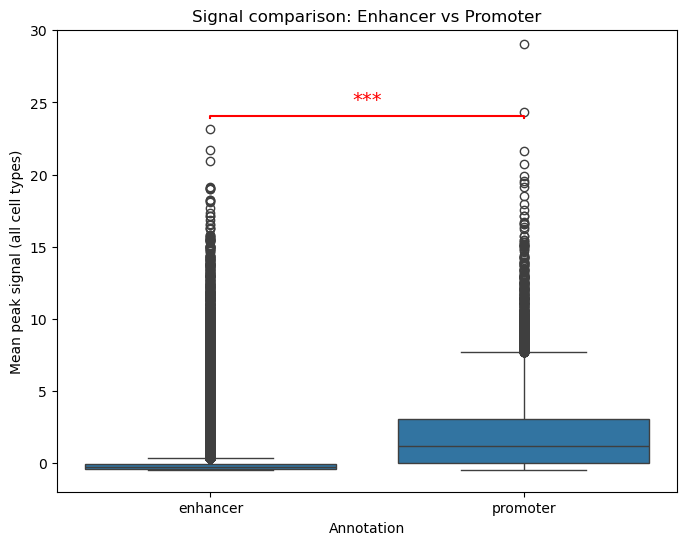

In [185]:
promoter_values_scaled = ATAC_scaled_regiontype[ATAC_scaled_regiontype['annotation'] == 'promoter']['mean_signal_all_celltypes'].dropna()
enhancer_values_scaled = ATAC_scaled_regiontype[ATAC_scaled_regiontype['annotation'] == 'enhancer']['mean_signal_all_celltypes'].dropna()

t_stat, p_value = ttest_ind(promoter_values_scaled, enhancer_values_scaled, equal_var=False)  

def significance_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'

stars = significance_stars(p_value)

plt.figure(figsize=(8,6))
sns.boxplot(x='annotation', y='mean_signal_all_celltypes', data=ATAC_scaled_regiontype)
plt.xlabel('Annotation')
plt.ylabel('Mean peak signal (all cell types)')
plt.title('Signal comparison: Enhancer vs Promoter')

y_max = ATAC_scaled_regiontype['mean_signal_all_celltypes'].max()
y_buffer = 0.5
plt.ylim(bottom=None, top=y_max + y_buffer + 0.5)

x1, x2 = 0, 1  
plt.plot([x1, x1, x2, x2], [y_max-5.1, y_max-5, y_max-5, y_max-5.1], lw=1.5, c='red')
plt.text((x1 + x2) * 0.5, y_max - 4.5, stars, ha='center', va='bottom', color='red', fontsize=14)


plt.savefig("figures/Boxplot_mean_per_Promotor_vs_Enhancer_scaled", dpi=300, bbox_inches='tight')
plt.show()

In [186]:
promoter_values_scaled = ATAC_scaled_regiontype[ATAC_scaled_regiontype['annotation'] == 'promoter']['mean_signal_all_celltypes'].dropna()
enhancer_values_scaled = ATAC_scaled_regiontype[ATAC_scaled_regiontype['annotation'] == 'enhancer']['mean_signal_all_celltypes'].dropna()

t_stat, p_value = ttest_ind(promoter_values_scaled, enhancer_values_scaled, equal_var=False)  

print(f"T-statistic: {t_stat:.3f}, p-value: {p_value:.3e}")

T-statistic: 87.445, p-value: 0.000e+00


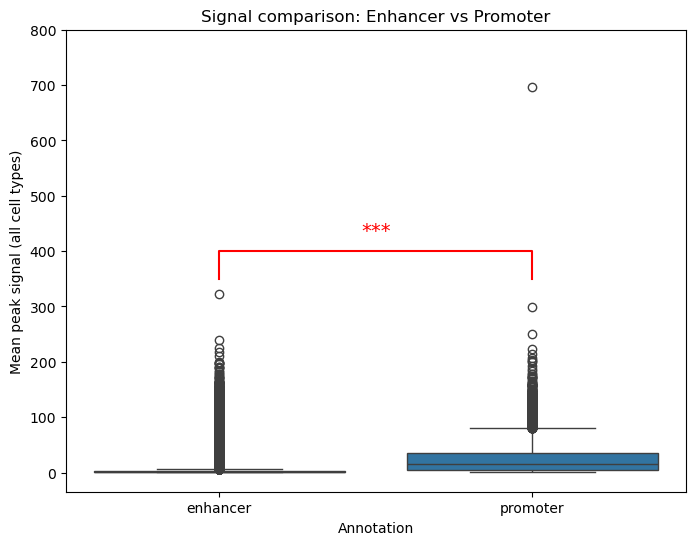

In [187]:
promoter_values = ATAC_regiontype[ATAC_regiontype['annotation'] == 'promoter']['mean_signal_all_celltypes'].dropna()
enhancer_values = ATAC_regiontype[ATAC_regiontype['annotation'] == 'enhancer']['mean_signal_all_celltypes'].dropna()

t_stat, p_value = ttest_ind(promoter_values, enhancer_values, equal_var=False)  

def get_significance_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'

stars = get_significance_stars(p_value)

plt.figure(figsize=(8,6))
sns.boxplot(x='annotation', y='mean_signal_all_celltypes', data=ATAC_regiontype)
plt.xlabel('Annotation')
plt.ylabel('Mean peak signal (all cell types)')
plt.title('Signal comparison: Enhancer vs Promoter')
plt.ylim(bottom=None, top=800)

x1, x2 = 0, 1

def get_whisker_top(data):
    q3 = np.percentile(data, 75)
    iqr = np.percentile(data, 75) - np.percentile(data, 25)
    whisker = min(np.max(data[data <= q3 + 1.5 * iqr]), np.max(data))
    return whisker

whisker_enhancer = get_whisker_top(enhancer_values)
whisker_promoter = get_whisker_top(promoter_values)
y = 300
offset = 100
plt.plot([x1, x1, x2, x2], [y + offset*0.5, y + offset, y + offset, y + offset*0.5], c='red', lw=1.5)
plt.text((x1 + x2) * 0.5, y + offset * 1.2 , stars, ha='center', va='bottom', fontsize=14, color='red')

plt.savefig("figures/Boxplot_mean_per_Promotor_vs_Enhancer_not_scaled", dpi=300, bbox_inches='tight')
plt.show()

In [188]:
promoter_values = ATAC_regiontype[ATAC_regiontype['annotation'] == 'promoter']['mean_signal_all_celltypes'].dropna()
enhancer_values = ATAC_regiontype[ATAC_regiontype['annotation'] == 'enhancer']['mean_signal_all_celltypes'].dropna()

t_stat, p_value = ttest_ind(promoter_values, enhancer_values, equal_var=False)  

print(f"T-statistic: {t_stat:.3f}, p-value: {p_value:.3e}")

T-statistic: 87.674, p-value: 0.000e+00


### c) Is there a relationship between the signal and the distance to the TSS?

To answer this we examined if peaks closer to the Transcription Start Site (TSS) have higher/lower ATAC-seq signals. 

In [189]:
ATAC_regiontype.head()

ImmGenATAC1219.peakID chrom   Summit  mm10.60way.phastCons_scores  \
0  ImmGenATAC1219.peak_1  chr1  3020786                         0.00   
1  ImmGenATAC1219.peak_2  chr1  3087226                         0.00   
2  ImmGenATAC1219.peak_3  chr1  3120109                         0.07   
3  ImmGenATAC1219.peak_4  chr1  3121485                         0.15   
4  ImmGenATAC1219.peak_5  chr1  3372787                         0.03   

   _-log10_bestPvalue  Included.in.systematic.analysis  TSS  \
0                0.56                              NaN  NaN   
1                0.50                              NaN  NaN   
2               10.80                              1.0  NaN   
3                3.02                              1.0  NaN   
4                1.31                              NaN  NaN   

  genes.within.100Kb  LTHSC.34-.BM  LTHSC.34+.BM  ...  DC.103+11b-.SI  \
0                NaN          0.41          0.71  ...            0.52   
1                NaN          0.41          1.64  ...            0.11   
2                NaN          2.36          0.10  ...            0.11   
3                NaN          0.41          0.10  ...            0.92   
4                NaN          0.41          0.10  ...            0.51   

   FRC.SLN  IAP.SLN  BEC.SLN  LEC.SLN  Ep.MEChi.Th  distance_to_nearest_TSS  \
0     1.27     0.10     0.57     3.27         1.41                -650712.0   
1     0.92     0.98     2.16     2.34         0.94                -584272.0   
2    63.38     8.92     1.33     1.04         0.11                -551389.0   
3    13.50     0.98     1.28     1.04         0.11                -550013.0   
4     0.92     0.75     1.33     1.61         4.50                -298711.0   

   annotation  mean_signal_all_celltypes  distance_bin  
0    enhancer                   1.053556           NaN  
1    enhancer                   0.929000           NaN  
2    enhancer                   1.521000           NaN  
3    enhancer                   0.874556           NaN  
4    enhancer                   0.882111           NaN  

[5 rows x 102 columns]

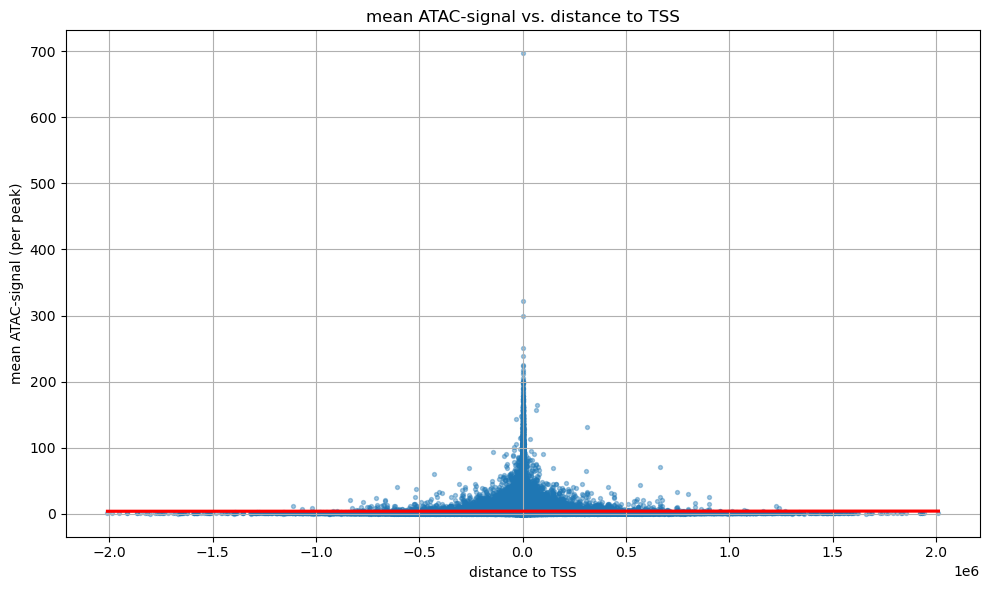

In [190]:
ATAC_rt_df = ATAC_regiontype[['distance_to_nearest_TSS', 'mean_signal_all_celltypes']].dropna()

plt.figure(figsize=(10, 6))
sns.regplot(data=ATAC_rt_df,x='distance_to_nearest_TSS',y='mean_signal_all_celltypes',scatter_kws={'s': 8, 'alpha': 0.4},line_kws={'color': 'red'})

plt.xlabel("distance to TSS")
plt.ylabel("mean ATAC-signal (per peak)")
plt.title("mean ATAC-signal vs. distance to TSS")
plt.grid(True)
plt.tight_layout()
plt.savefig("figures/scatterplot_peak_vs_TSS_distance", dpi=300, bbox_inches='tight')
plt.show()


In [191]:
#correlation
r, p = pearsonr(ATAC_rt_df['distance_to_nearest_TSS'], ATAC_rt_df['mean_signal_all_celltypes'])
print(f"Pearson r = {r:.3f}, p = {p:.2e}")

Pearson r = 0.001, p = 5.61e-01


### d) Are intronic enhancers different from enhancers outside the transcript.

To find out if whether intornic enhacners (inside of transcripts) are different from enhancers outside the transcript we first extracted the Transcript regions out of the Annotation data

In [192]:
ATAC_enhancer = ATAC_regiontype[ATAC_regiontype['annotation'] == 'enhancer'].copy()
ATAC_enhancer.head()

ImmGenATAC1219.peakID chrom   Summit  mm10.60way.phastCons_scores  \
0  ImmGenATAC1219.peak_1  chr1  3020786                         0.00   
1  ImmGenATAC1219.peak_2  chr1  3087226                         0.00   
2  ImmGenATAC1219.peak_3  chr1  3120109                         0.07   
3  ImmGenATAC1219.peak_4  chr1  3121485                         0.15   
4  ImmGenATAC1219.peak_5  chr1  3372787                         0.03   

   _-log10_bestPvalue  Included.in.systematic.analysis  TSS  \
0                0.56                              NaN  NaN   
1                0.50                              NaN  NaN   
2               10.80                              1.0  NaN   
3                3.02                              1.0  NaN   
4                1.31                              NaN  NaN   

  genes.within.100Kb  LTHSC.34-.BM  LTHSC.34+.BM  ...  DC.103+11b-.SI  \
0                NaN          0.41          0.71  ...            0.52   
1                NaN          0.41          1.64  ...            0.11   
2                NaN          2.36          0.10  ...            0.11   
3                NaN          0.41          0.10  ...            0.92   
4                NaN          0.41          0.10  ...            0.51   

   FRC.SLN  IAP.SLN  BEC.SLN  LEC.SLN  Ep.MEChi.Th  distance_to_nearest_TSS  \
0     1.27     0.10     0.57     3.27         1.41                -650712.0   
1     0.92     0.98     2.16     2.34         0.94                -584272.0   
2    63.38     8.92     1.33     1.04         0.11                -551389.0   
3    13.50     0.98     1.28     1.04         0.11                -550013.0   
4     0.92     0.75     1.33     1.61         4.50                -298711.0   

   annotation  mean_signal_all_celltypes  distance_bin  
0    enhancer                   1.053556           NaN  
1    enhancer                   0.929000           NaN  
2    enhancer                   1.521000           NaN  
3    enhancer                   0.874556           NaN  
4    enhancer                   0.882111           NaN  

[5 rows x 102 columns]

In [193]:
#only coloumns with needed information 
transcripts = Annotation[["Chromosome", "5' transcript Start", "3' Transcript Start ", "Gene Name", "Strand"]].copy()

#rename for similar names 
transcripts.columns = ["chr", "start", "end", "gene", "strand"]

#check:  start < end (no difference between +, - because we just want to know if its within)
transcripts["tx_start"] = transcripts[["start", "end"]].min(axis=1)
transcripts["tx_end"] = transcripts[["start", "end"]].max(axis=1)

#final data
transcripts = transcripts[["chr", "tx_start", "tx_end", "gene"]]
transcripts.head()


chr   tx_start     tx_end    gene
0  chr2   59855193   59882606  Wdsub1
1  chr2   36116078   36136704   Rbm18
2  chr2   32151147   32234537  Prrc2b
3  chr1  166254138  166316832   Ildr2
4  chr4  156215926  156221307   Perm1

In [194]:
#Tree per chromosome
trees = defaultdict(IntervalTree)

for _, row in transcripts.iterrows():
    trees[row["chr"]].add(Interval(row["tx_start"], row["tx_end"], data=row["gene"]))


In [195]:
#prep ATAC-Peaks
ATAC_enhancer["Start"] = ATAC_enhancer["Summit"]
ATAC_enhancer["End"] = ATAC_enhancer["Summit"] + 1

In [196]:
#classifiy: Intronic?
def is_intronic(row):
    chrom = row["chrom"]
    start = row["Start"]
    end = row["End"]
    return len(trees[chrom].overlap(start, end)) > 0

ATAC_enhancer["is_intronic"] = ATAC_enhancer.apply(is_intronic, axis=1)
ATAC_enhancer.head()


ImmGenATAC1219.peakID chrom   Summit  mm10.60way.phastCons_scores  \
0  ImmGenATAC1219.peak_1  chr1  3020786                         0.00   
1  ImmGenATAC1219.peak_2  chr1  3087226                         0.00   
2  ImmGenATAC1219.peak_3  chr1  3120109                         0.07   
3  ImmGenATAC1219.peak_4  chr1  3121485                         0.15   
4  ImmGenATAC1219.peak_5  chr1  3372787                         0.03   

   _-log10_bestPvalue  Included.in.systematic.analysis  TSS  \
0                0.56                              NaN  NaN   
1                0.50                              NaN  NaN   
2               10.80                              1.0  NaN   
3                3.02                              1.0  NaN   
4                1.31                              NaN  NaN   

  genes.within.100Kb  LTHSC.34-.BM  LTHSC.34+.BM  ...  BEC.SLN  LEC.SLN  \
0                NaN          0.41          0.71  ...     0.57     3.27   
1                NaN          0.41          1.64  ...     2.16     2.34   
2                NaN          2.36          0.10  ...     1.33     1.04   
3                NaN          0.41          0.10  ...     1.28     1.04   
4                NaN          0.41          0.10  ...     1.33     1.61   

   Ep.MEChi.Th  distance_to_nearest_TSS  annotation  \
0         1.41                -650712.0    enhancer   
1         0.94                -584272.0    enhancer   
2         0.11                -551389.0    enhancer   
3         0.11                -550013.0    enhancer   
4         4.50                -298711.0    enhancer   

   mean_signal_all_celltypes  distance_bin    Start      End  is_intronic  
0                   1.053556           NaN  3020786  3020787        False  
1                   0.929000           NaN  3087226  3087227        False  
2                   1.521000           NaN  3120109  3120110        False  
3                   0.874556           NaN  3121485  3121486        False  
4                   0.882111           NaN  3372787  3372788         True  

[5 rows x 105 columns]

In [197]:
#check for inf and replace 
np.isinf(ATAC_enhancer["mean_signal_all_celltypes"]).sum()
ATAC_enhancer["mean_signal_all_celltypes"] = ATAC_enhancer["mean_signal_all_celltypes"].replace([np.inf, -np.inf], np.nan)

In [198]:
# compare mean 
intronic_mean = ATAC_enhancer[ATAC_enhancer["is_intronic"]]["mean_signal_all_celltypes"].mean()
non_intronic_mean = ATAC_enhancer[~ATAC_enhancer["is_intronic"]]["mean_signal_all_celltypes"].mean()

print("Intronic Enhancer mean:", round(intronic_mean, 3))
print("Non-intronic Enhancer mean:", round(non_intronic_mean, 3))


Intronic Enhancer mean: 3.368
Non-intronic Enhancer mean: 3.543


In [199]:
ATAC_enhancer["Enhancer Type"] = ATAC_enhancer["is_intronic"].map({True: "Intronic", False: "Non-intronic"})

Text(0.5, 25, '***')

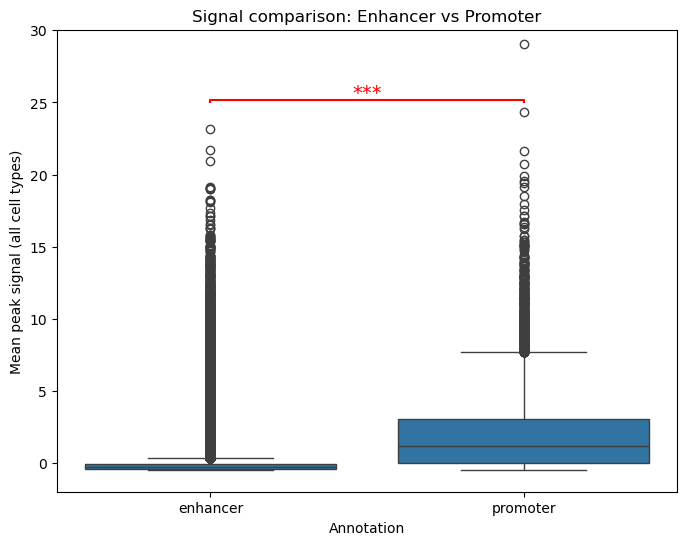

In [200]:
plt.figure(figsize=(8,6))
sns.boxplot(x='annotation', y='mean_signal_all_celltypes', data=ATAC_scaled_regiontype)
plt.xlabel('Annotation')
plt.ylabel('Mean peak signal (all cell types)')
plt.title('Signal comparison: Enhancer vs Promoter')

y_max = ATAC_scaled_regiontype['mean_signal_all_celltypes'].max()
y_buffer = 0.5
plt.ylim(bottom=None, top=y_max + y_buffer + 0.5)

x1, x2 = 0, 1  
plt.plot([x1, x1, x2, x2], [25, 25.2, 25.2, 25], lw=1.5, c='red')
plt.text((x1 + x2) * 0.5, 25, stars, ha='center', va='bottom', color='red', fontsize=14)



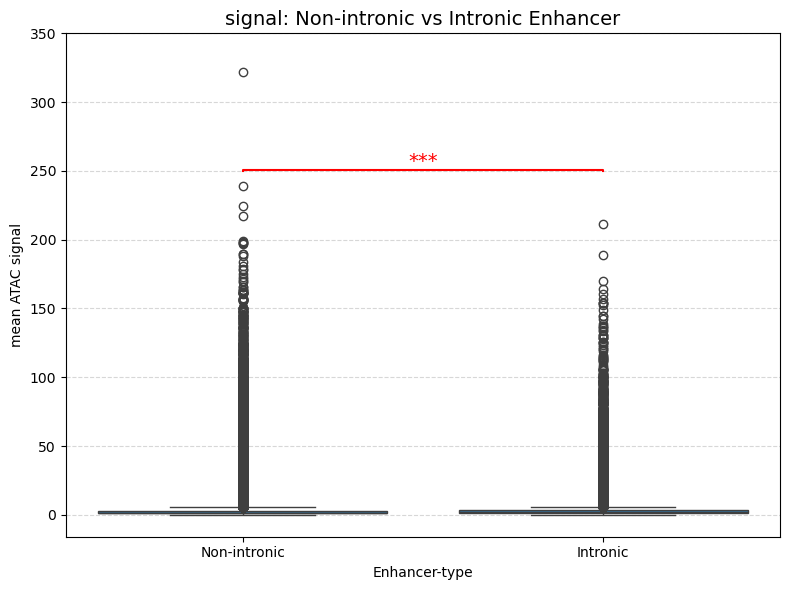

In [201]:
# Boxplot
intronic_values = ATAC_enhancer[ATAC_enhancer["Enhancer Type"] == 'Intronic']['mean_signal_all_celltypes'].dropna()
non_intronic_values = ATAC_enhancer[ATAC_enhancer["Enhancer Type"] == 'Non-intronic']['mean_signal_all_celltypes'].dropna()

t_stat, p_value = ttest_ind(intronic_values, non_intronic_values, equal_var=False)  

def significance_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'

stars = significance_stars(p_value)

plt.figure(figsize=(8, 6))
sns.boxplot(data=ATAC_enhancer, x="Enhancer Type", y="mean_signal_all_celltypes")

plt.title("signal: Non-intronic vs Intronic Enhancer", fontsize=14)
plt.xlabel("Enhancer-type")
plt.ylabel("mean ATAC signal")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.ylim(bottom=None, top=350)

x1, x2 = 0, 1

plt.plot([x1, x1, x2, x2], [250, 250.5, 250.5, 250], c='red', lw=1.5)
plt.text((x1 + x2) * 0.5, 250 , stars, ha='center', va='bottom', fontsize=14, color='red')

plt.savefig("figures/Boxplot_intronic_vs_non_intronic_enhancer.png", dpi=300)
plt.show()

In [202]:
intronic_values = ATAC_enhancer[ATAC_enhancer["Enhancer Type"] == 'Intronic']['mean_signal_all_celltypes'].dropna()
non_intronic_values = ATAC_enhancer[ATAC_enhancer["Enhancer Type"] == 'Non-intronic']['mean_signal_all_celltypes'].dropna()

print(f"T-statistic: {t_stat:.3f}, p-value: {p_value:.3e}")

T-statistic: -8.911, p-value: 5.087e-19


# Clustering with all lineages

In [203]:
K = range(8, 12)
a = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(ATAC_scaled)
    a.append(kmeans.inertia_)

kmeans_9_reduzed = KMeans(n_clusters=9, random_state=42, n_init=10)
kmeans_9_reduzed.fit(ATAC_scaled)

kmeans_10_reduzed = KMeans(n_clusters=10, random_state=42, n_init=10)
kmeans_10_reduzed.fit(ATAC_scaled)

kmeans_11_reduzed = KMeans(n_clusters=11, random_state=42, n_init=10)
kmeans_11_reduzed.fit(ATAC_scaled)

labels_9_reduzed = kmeans_9_reduzed.labels_ + 1
labels_10_reduzed = kmeans_10_reduzed.labels_ + 1
labels_11_reduzed = kmeans_11_reduzed.labels_ + 1

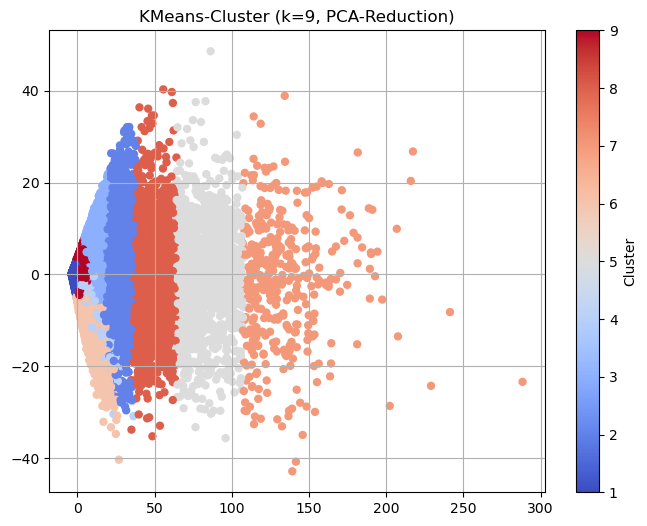

In [205]:
#for k=9
pca = PCA(n_components=2)
X_pca = pca.fit_transform(ATAC_scaled)
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_9_reduzed, cmap='coolwarm', s=25)
plt.title('KMeans-Cluster (k=9, PCA-Reduction)')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

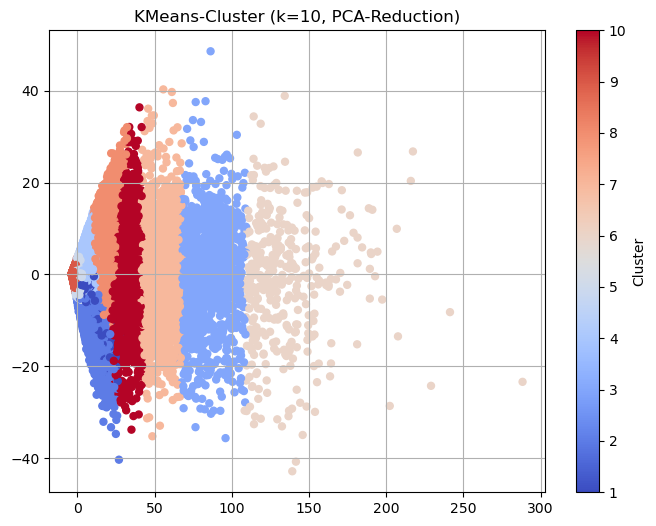

In [207]:
#for k=10
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_10_reduzed, cmap='coolwarm', s=25)
plt.title('KMeans-Cluster (k=10, PCA-Reduction)')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

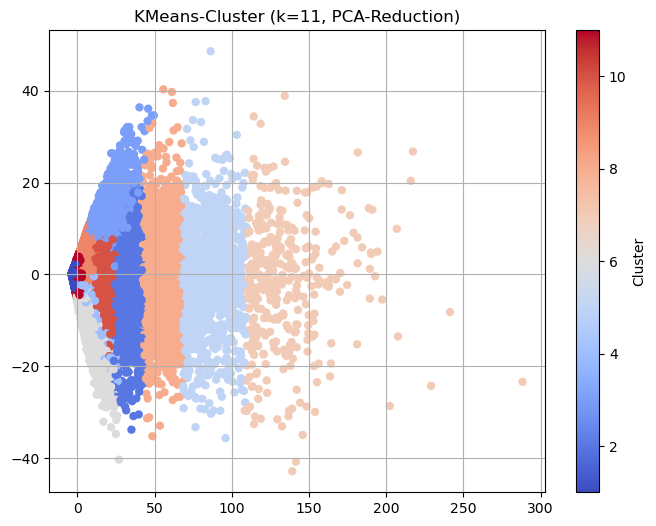

In [208]:
#for k=11
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_11_reduzed, cmap='coolwarm', s=25)
plt.title('KMeans-Cluster (k=11, PCA-Reduction)')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

Clustering with k = 10 yields a meaningful structure, which supports our hypothesis, as we are analyzing 10 distinct lineages. It was therefore expected that these lineages differ in their ATAC signal profiles. Based on this, we will incorporate the 10-cluster organization into the dataset.

In [210]:
# adding cluster label to dataset 
ATAC_scaled["cluster"] = labels_10_reduzed

Clustering the B cells with k = 8 yields meaningful substructure, indicating that not all B cells share the same ATAC signal profiles. Instead, they can be further subdivided into distinct clusters within the lineage.

In [ ]:
# adding cluster label to dataset 
ATAC_T_scaled_Bcells["cluster"] = labels_8_reduzed_Bcells

## iii. Do related cell types cluster together based on ATAC signal?

### a) Does clustering reproduce known relationship?

In [219]:
df_pca_input = ATAC_scaled

max_celltype = ATAC_scaled.idxmax(axis=1)

pca = PCA(n_components=10)
pca_result = pca.fit_transform(ATAC_scaled)

df_pca = pd.DataFrame(pca_result[:, :10], columns=["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10"])
df_pca.index = ATAC_scaled.index

qc = pd.read_csv("data/ATAC_QCmatric.csv", sep=";")
qc.columns = qc.columns.str.strip()
qc["CellType"] = qc["CellType"].str.strip()
qc["Lineage"] = qc["Lineage"].str.strip()

qc_unique = qc.drop_duplicates(subset="CellType", keep="first")
cell_to_lineage = qc_unique.set_index("CellType")["Lineage"]

peak_lineage = max_celltype.map(cell_to_lineage).fillna("Unassigned")
df_pca["Lineage"] = peak_lineage

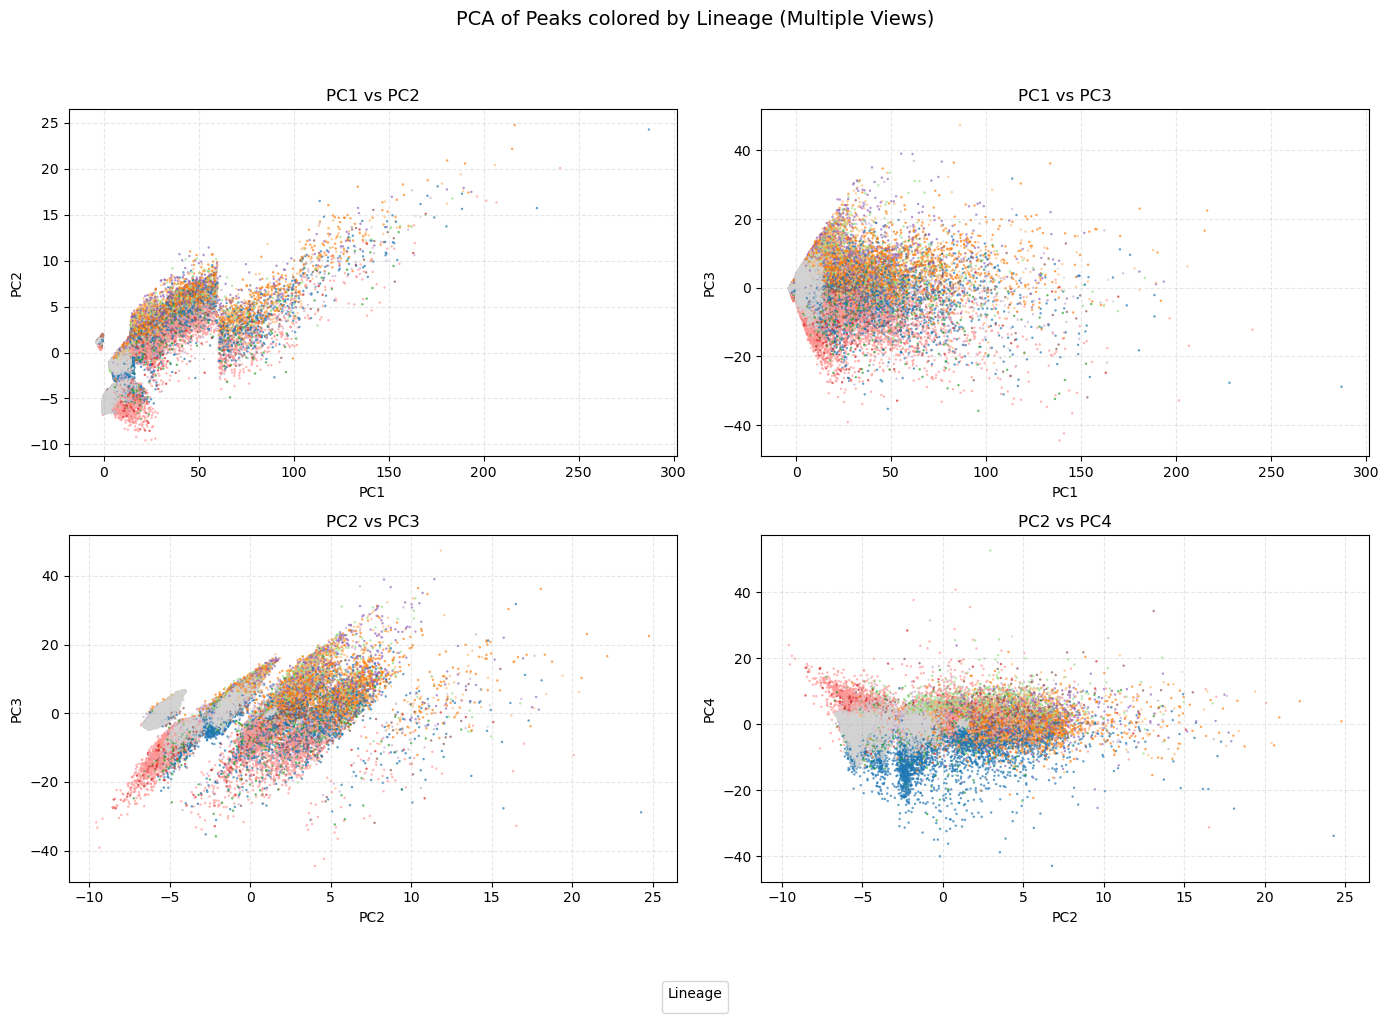

In [220]:
combinations = [("PC1", "PC2"), ("PC1", "PC3"), ("PC2", "PC3"), ("PC2", "PC4")]

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=False, sharey=False)

axes = axes.flatten()

# Plot for each PCA combination
for ax, (x_pc, y_pc) in zip(axes, combinations):
    sns.scatterplot(
        data=df_pca,
        x=x_pc,
        y=y_pc,
        hue="Lineage",
        palette=lineage_colors,
        s=3,
        alpha=0.7,
        linewidth=0,
        ax=ax,
        legend=False  
    )
    ax.set_title(f"{x_pc} vs {y_pc}")
    ax.grid(True, linestyle="--", alpha=0.3)

# legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.03),
    ncol=4,
    title="Lineage"
)

plt.suptitle("PCA of Peaks colored by Lineage (Multiple Views)", fontsize=14)
plt.tight_layout(rect=[0, 0.05, 1, 0.95]) 
plt.savefig("figures/PCA_peaks_multi.png", dpi=300, bbox_inches="tight")
plt.show()


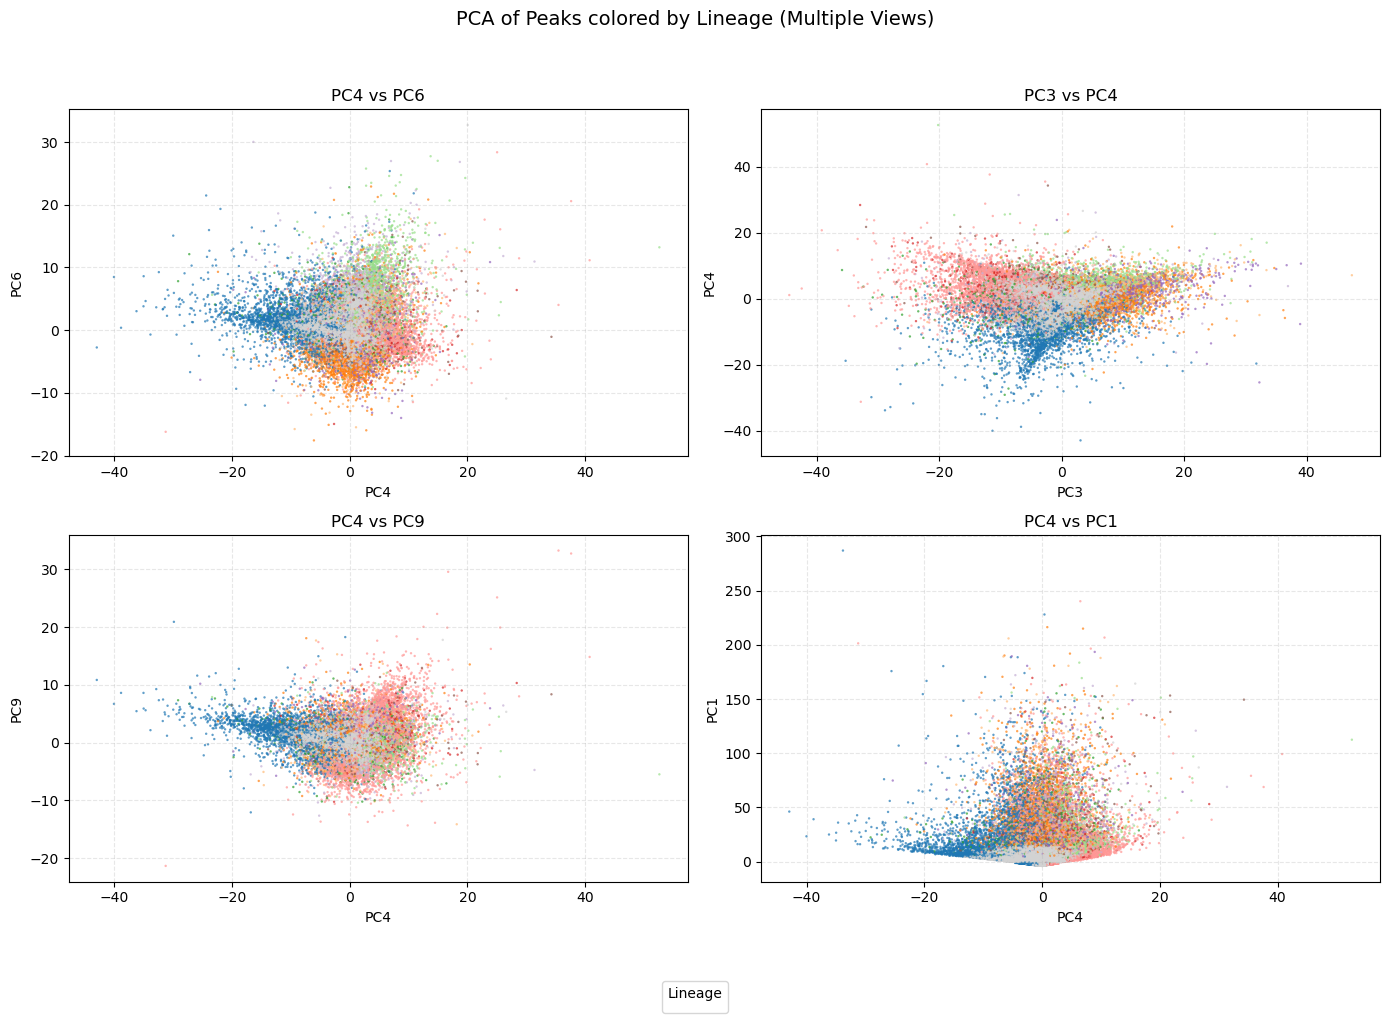

In [221]:
combinations = [("PC4", "PC6"), ("PC3", "PC4"), ("PC4", "PC9"), ("PC4", "PC1")]

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=False, sharey=False)

axes = axes.flatten()

# Plot for each PCA combination
for ax, (x_pc, y_pc) in zip(axes, combinations):
    sns.scatterplot(
        data=df_pca,
        x=x_pc,
        y=y_pc,
        hue="Lineage",
        palette=lineage_colors,
        s=3,
        alpha=0.7,
        linewidth=0,
        ax=ax,
        legend=False  
    )
    ax.set_title(f"{x_pc} vs {y_pc}")
    ax.grid(True, linestyle="--", alpha=0.3)

# legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.03),
    ncol=4,
    title="Lineage"
)

plt.suptitle("PCA of Peaks colored by Lineage (Multiple Views)", fontsize=14)
plt.tight_layout(rect=[0, 0.05, 1, 0.95]) 
plt.savefig("figures/PCA_peaks_multi_2.png", dpi=300, bbox_inches="tight")
plt.show()


C:\Users\annal\AppData\Local\Temp\ipykernel_34796\1221471777.py:35: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


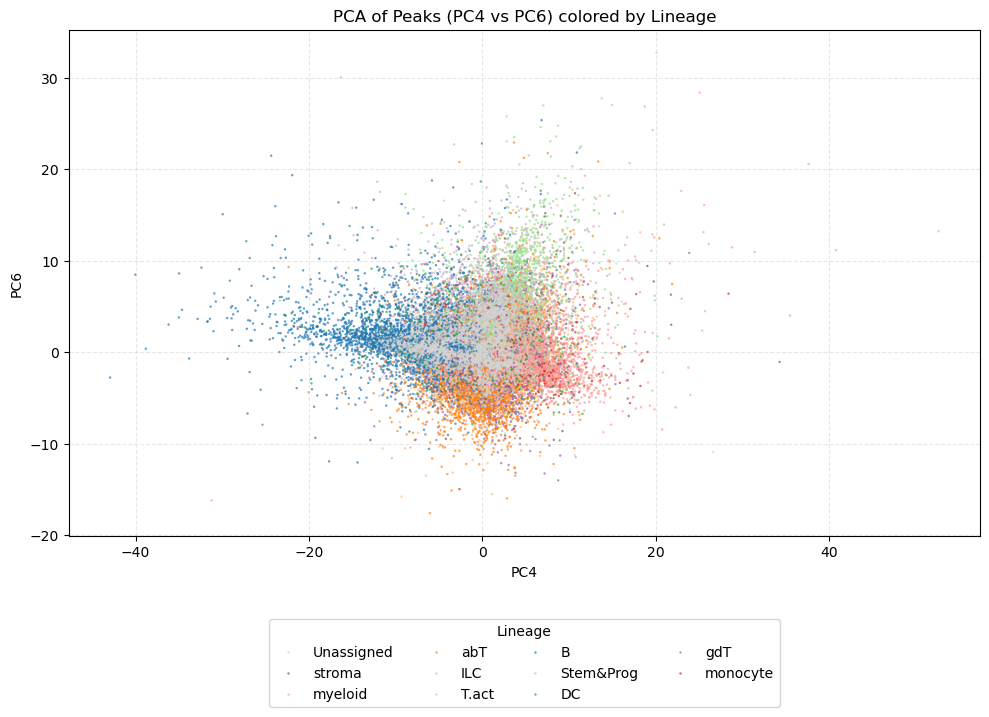

In [224]:
df_pca_input = ATAC_scaled
max_celltype = ATAC_scaled.idxmax(axis=1)

pca = PCA(n_components=10)
pca_result = pca.fit_transform(ATAC_scaled)

df_pca = pd.DataFrame(pca_result[:, :10], columns=["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10"])
df_pca.index = ATAC_scaled.index

qc = pd.read_csv("data/ATAC_QCmatric.csv", sep=";")
qc.columns = qc.columns.str.strip()
qc["CellType"] = qc["CellType"].str.strip()
qc["Lineage"] = qc["Lineage"].str.strip()

qc_unique = qc.drop_duplicates(subset="CellType", keep="first")
cell_to_lineage = qc_unique.set_index("CellType")["Lineage"]

peak_lineage = max_celltype.map(cell_to_lineage).fillna("Unassigned")
df_pca["Lineage"] = peak_lineage

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_pca,
    x="PC4", y="PC6", 
    hue="Lineage",
    palette=lineage_colors,
    s=3,
    alpha=0.7,
    linewidth=0
)
plt.title("PCA of Peaks (PC4 vs PC6) colored by Lineage")
plt.xlabel("PC4")
plt.ylabel("PC6")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, title="Lineage")
plt.savefig("figures/PCA_peaks_PC4_vs_PC6.png", dpi=300)
plt.show()

c:\Users\annal\miniconda3\envs\envBCells1\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\annal\AppData\Local\Temp\ipykernel_34796\841574377.py:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("tab10", k)


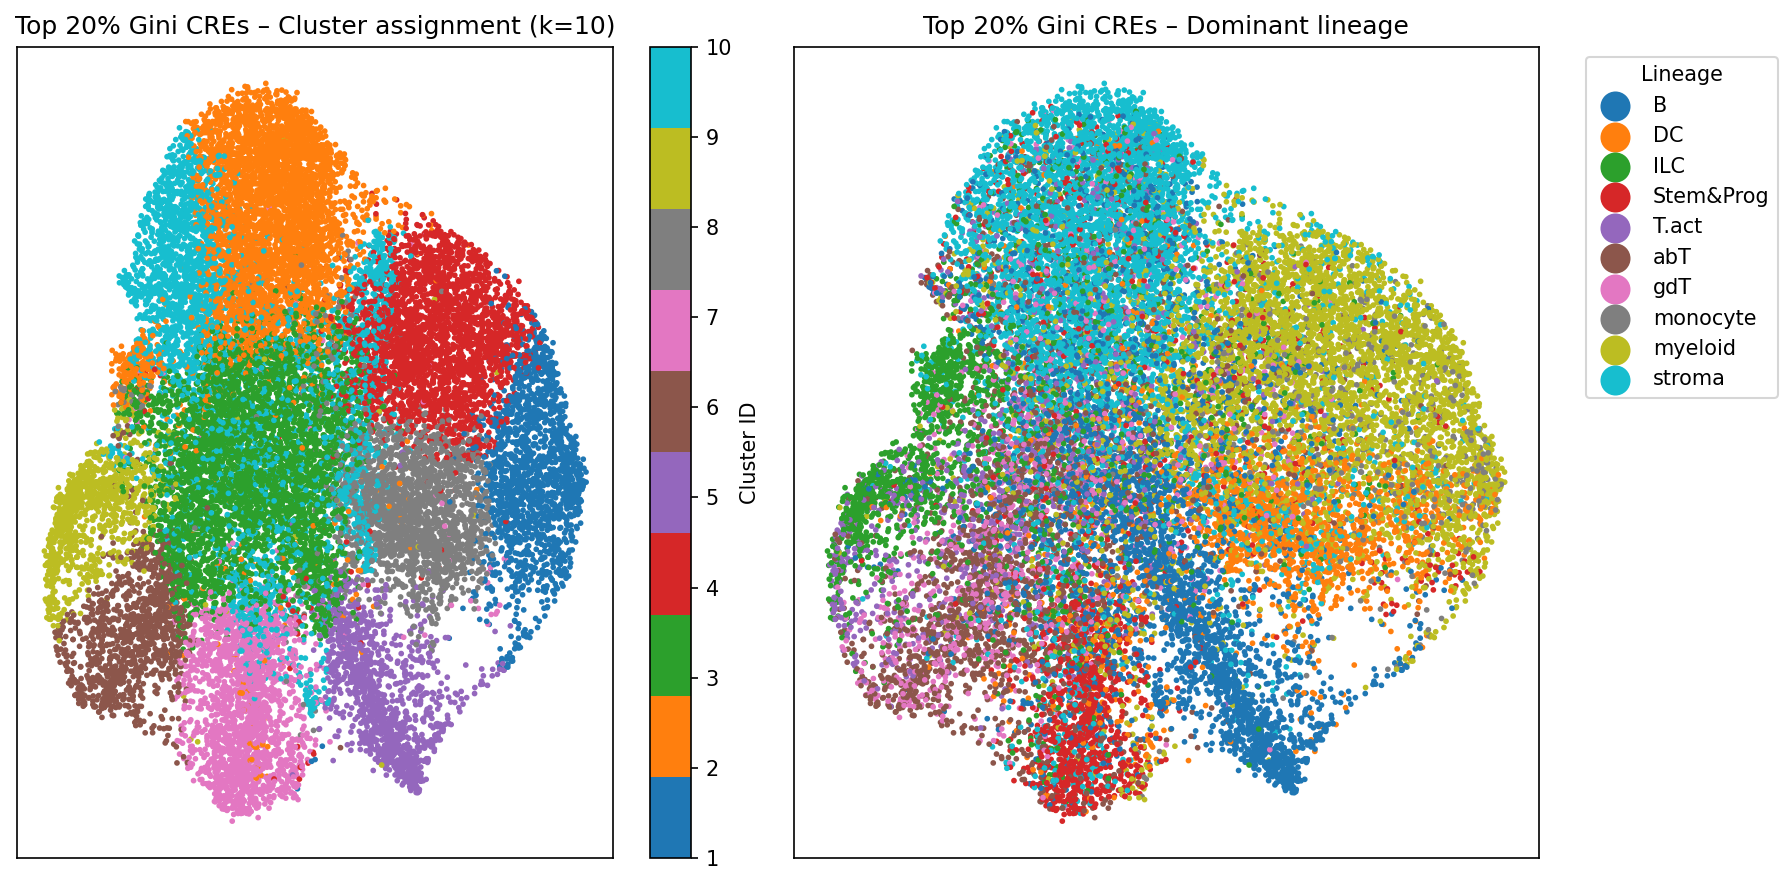

In [225]:
# data
ATAC_MATRIX = pathlib.Path(r"data/converted_ATAC_seq_info.CSV")
QC_TABLE    = pathlib.Path(r"data/ATAC_QCmatric.csv")

try:
    mat = pd.read_csv(ATAC_MATRIX, sep=";", index_col=0, low_memory=False)
except pd.errors.ParserError:
    mat = pd.read_csv(ATAC_MATRIX, sep=";", index_col=0, engine="python")

mat = mat.loc[:, ~mat.columns.str.startswith("Unnamed")]
mat = (
    mat.apply(pd.to_numeric, errors="coerce")
       .replace([np.inf, -np.inf], np.nan)
       .fillna(0.0)
       .astype(np.float64)
)

# normalisation
mat = np.log2(mat + 0.1)
mat_qnorm = (mat.rank(axis=0) / (len(mat) - 1)).astype(np.float32)

# gini score
def gini(row):
    x = np.sort(row.values)
    i = np.arange(1, x.size + 1)
    return ((2 * i - x.size - 1) * x).sum() / (x.size * x.sum())

MAX_PTS = 120_000
if len(mat_qnorm) > MAX_PTS:
    rng = np.random.default_rng(0)
    keep = rng.choice(mat_qnorm.index, size=MAX_PTS, replace=False)
    mat_s = mat_qnorm.loc[keep]
else:
    mat_s = mat_qnorm

gini_scores = mat_s.apply(gini, axis=1)

# filtering top 5% Gini CREs
top10_mask = gini_scores >= gini_scores.quantile(0.80)
top10_index = gini_scores.loc[top10_mask].index
mat_cre_top10 = mat_qnorm.loc[top10_index].copy()

# PCA, clustering and UMAP
pca_top10 = PCA(n_components=10, random_state=42)
mat_pca_top10 = pca_top10.fit_transform(mat_cre_top10)

k = 10
kmeans_top10 = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels_top10 = kmeans_top10.fit_predict(mat_pca_top10)
cluster_labels_top10 += 1
mat_cre_top10["cluster"] = cluster_labels_top10

umap_coords_top10 = umap.UMAP(n_neighbors=30, min_dist=0.3, random_state=42).fit_transform(mat_pca_top10)

# lineage per CRE
signal_top10 = mat_cre_top10.drop(columns="cluster")
valid_columns_top10 = signal_top10.columns.intersection(celltype_to_lineage.index)
signal_top10 = signal_top10[valid_columns_top10]
max_celltype_top10 = signal_top10.idxmax(axis=1)
dominant_lineage_top10 = max_celltype_top10.map(celltype_to_lineage)

# UMAP side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=150)

# UMAP colored by cluster
cmap = cm.get_cmap("tab10", k)
sc1 = axes[0].scatter(umap_coords_top10[:, 0], umap_coords_top10[:, 1],
                      c=cluster_labels_top10, cmap=cmap, s=3)
axes[0].set_title(f"Top 20% Gini CREs – Cluster assignment (k={k})")
axes[0].set_xticks([]); axes[0].set_yticks([])
cbar = fig.colorbar(sc1, ax=axes[0], ticks=range(1, k + 1))
cbar.set_label("Cluster ID")

# UMAP colored by dominant lineage
unique_lineages = sorted(dominant_lineage_top10.dropna().unique())
palette = sns.color_palette("tab10", n_colors=len(unique_lineages))
lineage_to_color = dict(zip(unique_lineages, palette))
colors = dominant_lineage_top10.map(lineage_to_color)

axes[1].scatter(umap_coords_top10[:, 0], umap_coords_top10[:, 1], c=colors, s=3)
axes[1].set_title("Top 20% Gini CREs – Dominant lineage")
axes[1].set_xticks([]); axes[1].set_yticks([])

for lineage, color in lineage_to_color.items():
    axes[1].scatter([], [], c=[color], label=lineage, s=20)
axes[1].legend(markerscale=3, title="Lineage", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


The UMAP on the left shows CREs colored by their KMeans cluster assignment, while the UMAP on the right displays CREs colored by their dominant lineage. Since the lineage-colored UMAP does not show a clear separation between lineages, we generated an additional plot to analyze the lineages individually.

c:\Users\annal\miniconda3\envs\envBCells1\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(
c:\Users\annal\miniconda3\envs\envBCells1\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\annal\AppData\Local\Temp\ipykernel_34796\1575033624.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("tab10", k)
C:\Users\annal\AppData\Local\Temp\ipykernel_34796\1575033624.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tig

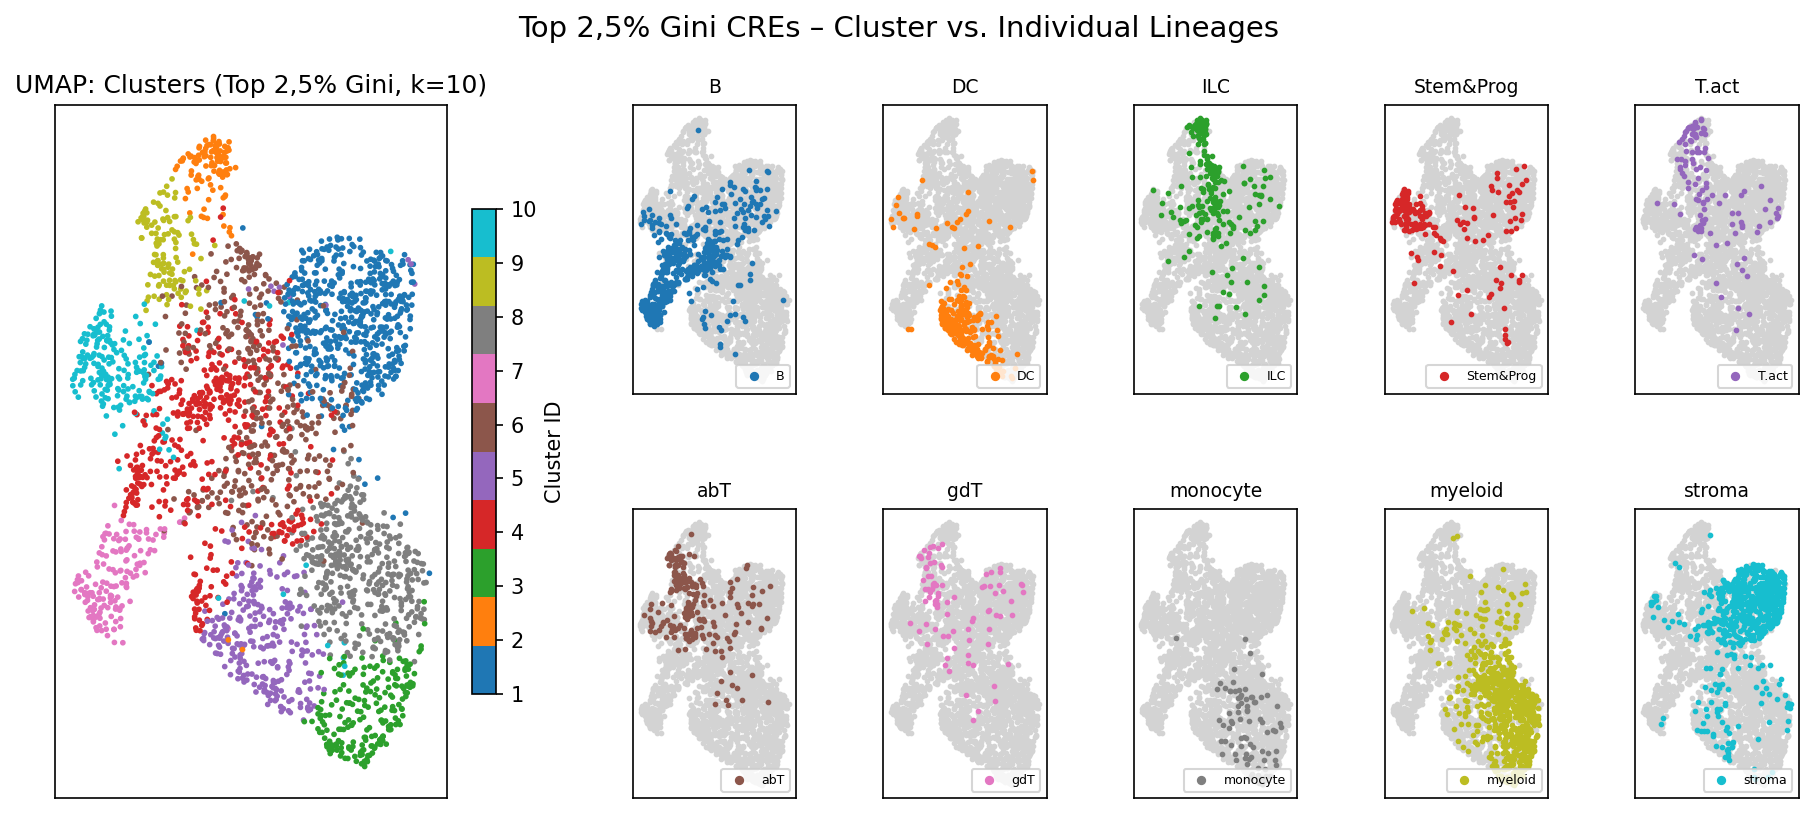

In [226]:
# filterg top 2,5% Gini CREs
top2_5_mask = gini_scores >= gini_scores.quantile(0.975)
top2_5_index = gini_scores.loc[top2_5_mask].index
mat_cre_top10 = mat_qnorm.loc[top2_5_index].copy()

# PCA, clustering and UMAP
pca_top10 = PCA(n_components=10, random_state=42)
mat_pca_top10 = pca_top10.fit_transform(mat_cre_top10)
k = 10
kmeans_top10 = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels_top10 = kmeans_top10.fit_predict(mat_pca_top10)
cluster_labels_top10 += 1
mat_cre_top10["cluster"] = cluster_labels_top10
umap_coords_top10 = umap.UMAP(n_neighbors=30, min_dist=0.3, random_state=42).fit_transform(mat_pca_top10)

# determing dominant lineage
signal_top10 = mat_cre_top10.drop(columns="cluster")
valid_columns_top10 = signal_top10.columns.intersection(celltype_to_lineage.index)
signal_top10 = signal_top10[valid_columns_top10]
max_celltype_top10 = signal_top10.idxmax(axis=1)
dominant_lineage_top10 = max_celltype_top10.map(celltype_to_lineage)

# defining unique lineages and their colors
unique_lineages = sorted(dominant_lineage_top10.dropna().unique())
palette = sns.color_palette("tab10", n_colors=len(unique_lineages))
lineage_to_color = dict(zip(unique_lineages, palette))

# figure
fig = plt.figure(figsize=(15, 6), dpi=150)
gs = fig.add_gridspec(2, 6, width_ratios=[3, 1, 1, 1, 1, 1], wspace=0.4, hspace=0.4)

# UMAP colored by cluster
ax0 = fig.add_subplot(gs[:, 0])
cmap = cm.get_cmap("tab10", k)
sc = ax0.scatter(umap_coords_top10[:, 0], umap_coords_top10[:, 1], c=cluster_labels_top10, cmap=cmap, s=3)
ax0.set_title(f"UMAP: Clusters (Top 2,5% Gini, k={k})")
ax0.set_xticks([]); ax0.set_yticks([])
cbar = fig.colorbar(sc, ax=ax0, ticks=range(1, k + 1), shrink=0.7)
cbar.set_label("Cluster ID")

# One UMAP per lineage
for i, lineage in enumerate(unique_lineages):
    row = i // 5
    col = i % 5 + 1
    ax = fig.add_subplot(gs[row, col])
    
    highlight_mask = dominant_lineage_top10 == lineage
    gray_mask = ~highlight_mask

    ax.scatter(umap_coords_top10[gray_mask, 0], umap_coords_top10[gray_mask, 1], color="lightgray", s=3)
    ax.scatter(umap_coords_top10[highlight_mask, 0], umap_coords_top10[highlight_mask, 1], 
               color=lineage_to_color[lineage], s=3, label=lineage)

    ax.set_title(lineage, fontsize=9)
    ax.set_xticks([]); ax.set_yticks([])
    ax.legend(loc="lower right", fontsize=6, markerscale=2)

plt.suptitle("Top 2,5% Gini CREs – Cluster vs. Individual Lineages", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("figures/UMAP_Gini_CREs_cluster_vs_each_lineage_top2,5percent.png", dpi=300, bbox_inches="tight")
plt.show()


The UMAP on the left shows CREs colored by their KMeans cluster assignment, while the 10 UMAPs on the right display CREs associated with each of the 10 analyzed lineages. However, the KMeans clustering does not accurately capture known relationships between lineages, as most lineage-specific CREs — including those from B cells — are dispersed throughout the entire UMAP space.

### b) Can one quantify the similarity of cell types in a sorted matrix?

c:\Users\annal\miniconda3\envs\envBCells1\Lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


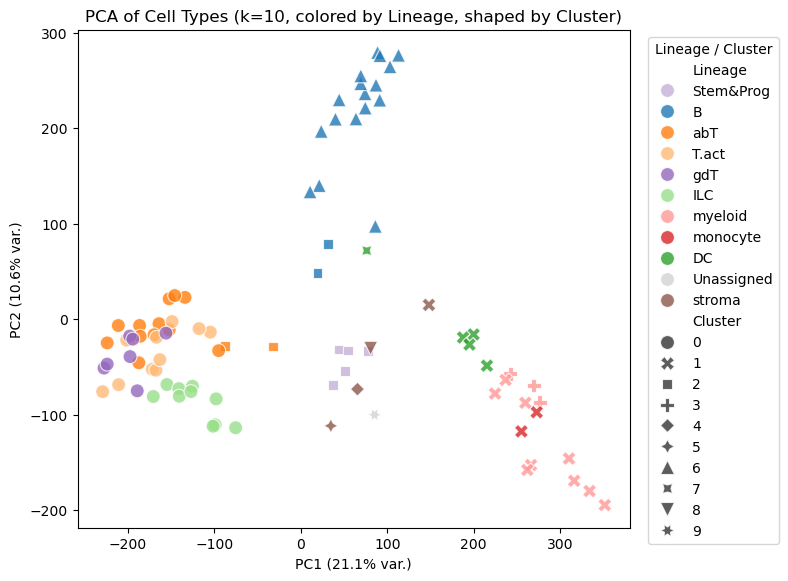

In [228]:
mat = ATAC_scaled_ct.copy()

# 2) Berechne Distanz-Matrix (hier: correlation)
D = pairwise_distances(mat.T, metric='correlation')

# 3) Agglomerative Clustering mit deinem best_k (hier 5)
best_k = 10
clust = AgglomerativeClustering(
    n_clusters=best_k,
    affinity='precomputed',
    linkage='average'
)
cluster_labels = clust.fit_predict(D)

# 4) PCA für die Zelltypen
pca = PCA(n_components=2)
proj = pca.fit_transform(mat.T)

df_pca = pd.DataFrame(proj, columns=['PC1','PC2'], index=mat.columns).reset_index()
df_pca = df_pca.rename(columns={'index':'CellType'})

# 5) Lineage aus QC mappen
qc = pd.read_csv("data/ATAC_QCmatric.csv", sep=';')
qc['CellType'] = qc['CellType'].str.strip()
qc['Lineage']  = qc['Lineage'].str.strip()
qc_unique = qc.drop_duplicates(subset='CellType', keep='first')

df_pca = df_pca.merge(
    qc_unique[['CellType','Lineage']],
    on='CellType',
    how='left'
).fillna({'Lineage':'Unassigned'})

# 6) Cluster-Labels in df_pca übernehmen
#    Hier mappt der i-te Label dem i-ten CellType in mat.columns
df_pca['Cluster'] = cluster_labels

# 7) Plot: Farbe = Lineage, Form = Cluster
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_pca,
    x='PC1', y='PC2',
    hue='Lineage',
    style='Cluster',
    palette=lineage_colors,
    markers=True,
    s=100,
    alpha=0.8
)
plt.title(f'PCA of Cell Types (k={best_k}, colored by Lineage, shaped by Cluster)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var.)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var.)')
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left', title='Lineage / Cluster')
plt.tight_layout()
plt.savefig("figures/PCA_k10_ct_clusters.png", dpi=300, bbox_inches="tight")
plt.show()

## iv. Define different classes of peaks based on signal + variation

### a) Can one cluster CREs based on their ATAC-signal?

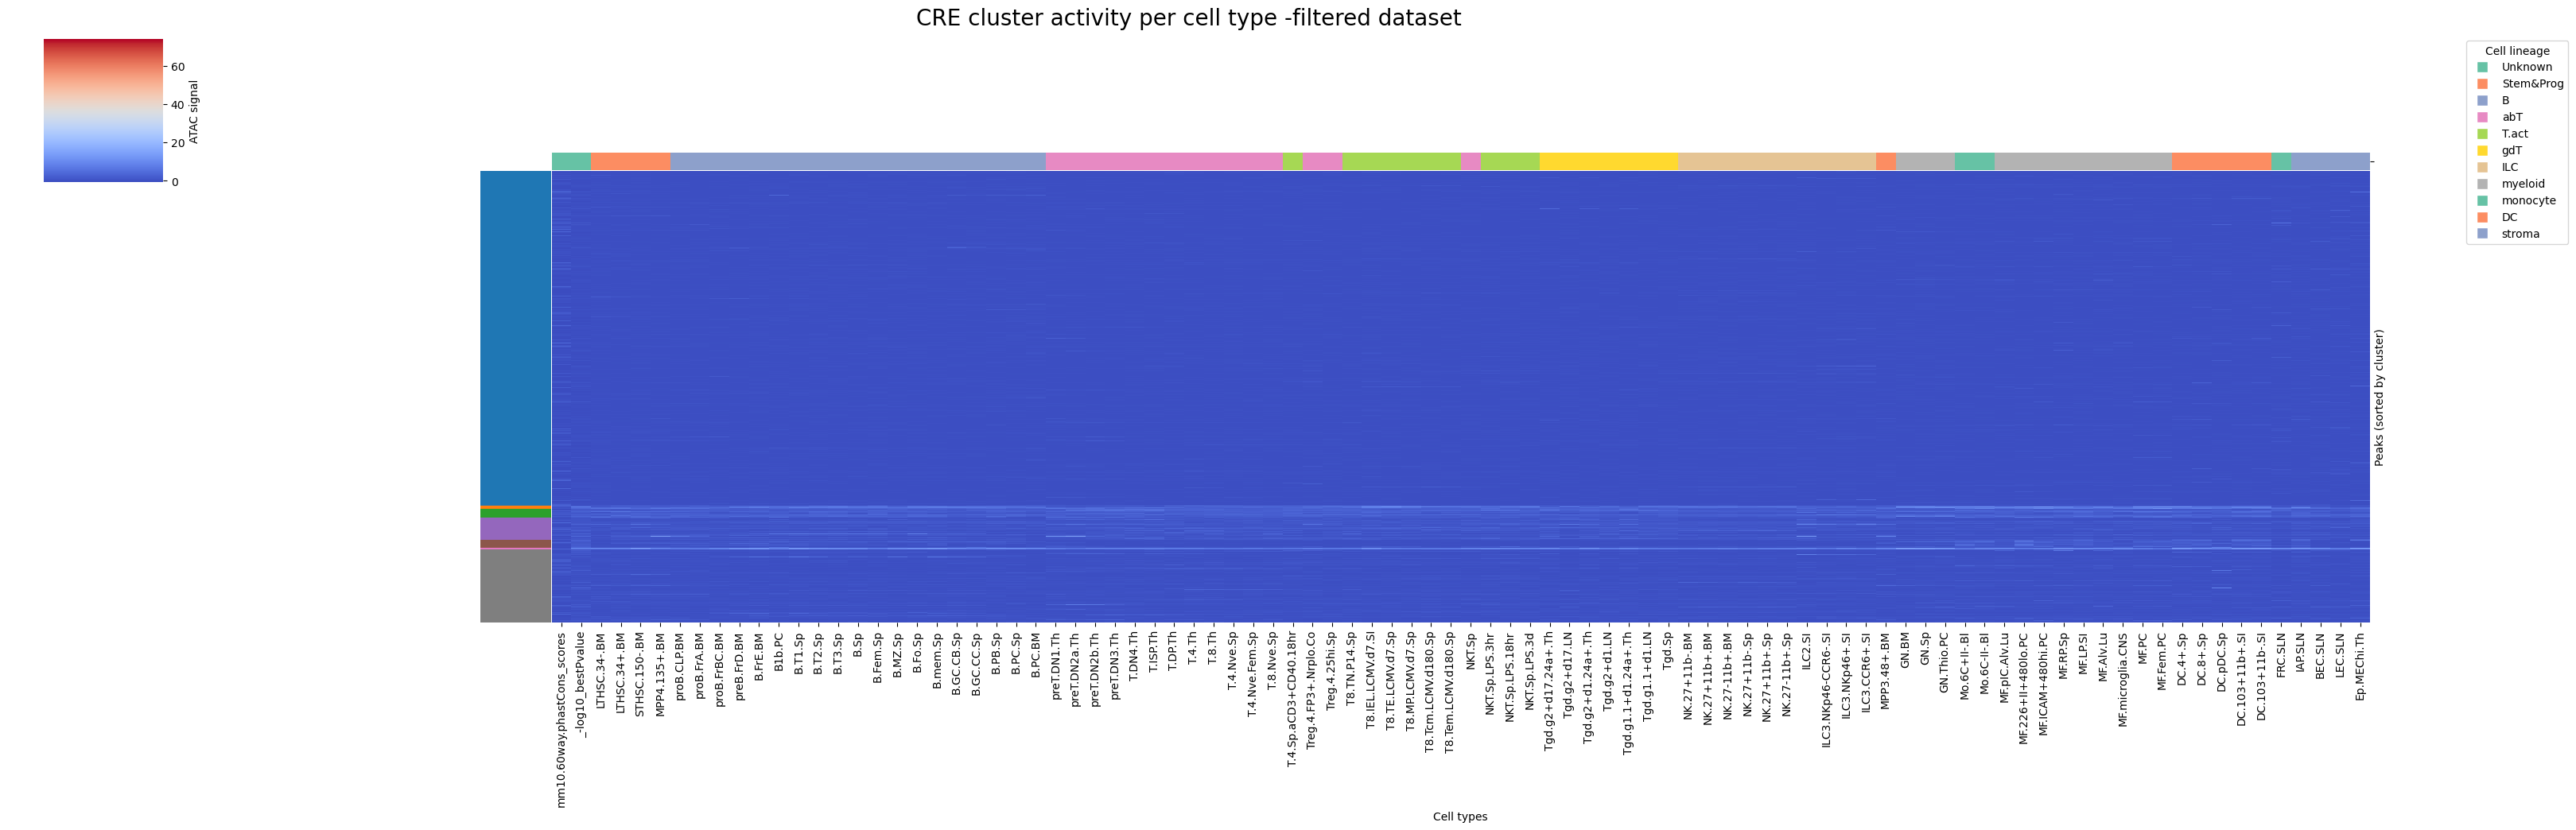

In [229]:
# sorting peaks by cluster
ATAC_clusters = ATAC_scaled.sort_values("cluster")

# cluster colors 
cluster_colors = sns.color_palette("tab10", 10)
row_colors = [cluster_colors[i - 1] for i in ATAC_clusters["cluster"]]

# removing 'cluster' column for the heatmap itself
heatmap_data = ATAC_clusters.drop(columns="cluster")

# lineage info
QC = pd.read_csv("data/ATAC_QCmatric.csv", sep=";")
QC.columns = QC.columns.str.strip()
QC["CellType"] = QC["CellType"].str.strip()
QC["Lineage"] = QC["Lineage"].str.strip()

# mapping from cell type to lineage 
celltype_to_lineage = QC.drop_duplicates("CellType").set_index("CellType")["Lineage"]
cell_types = heatmap_data.columns.tolist()

# column colors: each cell type to its lineage color
lineages = [celltype_to_lineage.get(ct, "Unknown") for ct in cell_types]
unique_lineages = pd.unique(lineages)
palette = dict(zip(unique_lineages, sns.color_palette("Set2", len(unique_lineages))))
col_colors = pd.Series(lineages, index=cell_types).map(palette)

# Heatmap
g = sns.clustermap(heatmap_data, cmap="coolwarm", yticklabels=False, row_colors=row_colors, col_colors=col_colors, col_cluster=False, row_cluster=False,  figsize=(30, 10),  cbar_kws={'label': 'ATAC signal'})
plt.suptitle("CRE cluster activity per cell type -filtered dataset", y=1.02, fontsize=20)
g.ax_heatmap.set_xlabel("Cell types")
g.ax_heatmap.set_ylabel("Peaks (sorted by cluster)")
g.ax_col_dendrogram.legend(
    handles=[plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=col, markersize=10, label=lab)
             for lab, col in palette.items()],
    title="Cell lineage",
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

plt.show()

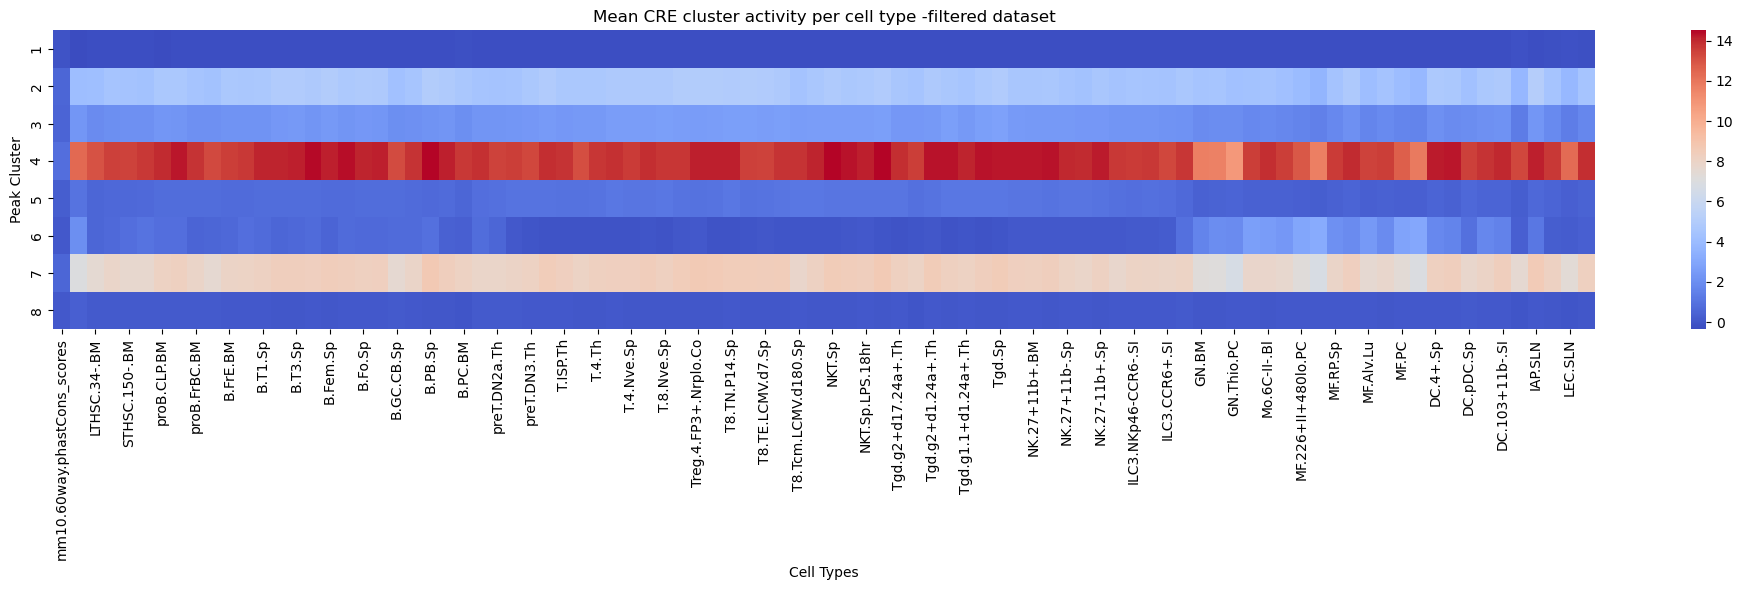

In [234]:
# preparing mean of the ATAC signals 
mean_ATAC_stat_high_signal_peaks_scaled_columns = ATAC_scaled.groupby('cluster').mean()

# Heatmap
plt.figure(figsize=(20, 6))
sns.heatmap(mean_ATAC_stat_high_signal_peaks_scaled_columns, cmap="coolwarm")
plt.title("Mean CRE cluster activity per cell type -filtered dataset")
plt.xlabel("Cell Types")
plt.ylabel("Peak Cluster")
plt.tight_layout()
plt.savefig("figures/Correlation_Peak-Clusters_CellTypes.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# 1lineage info
QC = pd.read_csv("data/ATAC_QCmatric.csv", sep=";")
QC.columns = QC.columns.str.strip()
QC["CellType"] = QC["CellType"].str.strip()
QC["Lineage"] = QC["Lineage"].str.strip()

celltype_to_lineage = QC.drop_duplicates("CellType").set_index("CellType")["Lineage"]

# clustering
signal_data = ATAC_scaled.drop(columns="cluster")
clusters = ATAC_stat_high_signal_peaks_scaled_columns["cluster"]
lineage_per_column = signal_data.columns.map(celltype_to_lineage)

# removing cell types not in QC 
valid_columns = ~lineage_per_column.isna()
signal_data = signal_data.loc[:, valid_columns]
lineage_per_column = lineage_per_column[valid_columns]

# renaming columns to lineage
signal_data.columns = lineage_per_column

#  mean signal per lineage
lineage_means = signal_data.groupby(signal_data.columns, axis=1).mean()

# cluster labels back
lineage_means["cluster"] = clusters.values

# average signal per cluster across lineages
cluster_lineage_activity = lineage_means.groupby("cluster").mean()

# order of lineages 
lineage_order = QC.drop_duplicates("Lineage")["Lineage"].tolist()
lineage_order = [l for l in lineage_order if l in cluster_lineage_activity.columns]
cluster_lineage_activity = cluster_lineage_activity[lineage_order]

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_lineage_activity, cmap="coolwarm", annot=True)
plt.title("CRE cluster activity per lineage - fitered dataset")
plt.xlabel("Lineage")
plt.ylabel("Cluster")
plt.tight_layout()
plt.savefig("figures/Correlation_Peak-Clusters_Lineages_filtered_dataset.png", dpi=300, bbox_inches="tight")
plt.show()

KeyError: 'cluster'

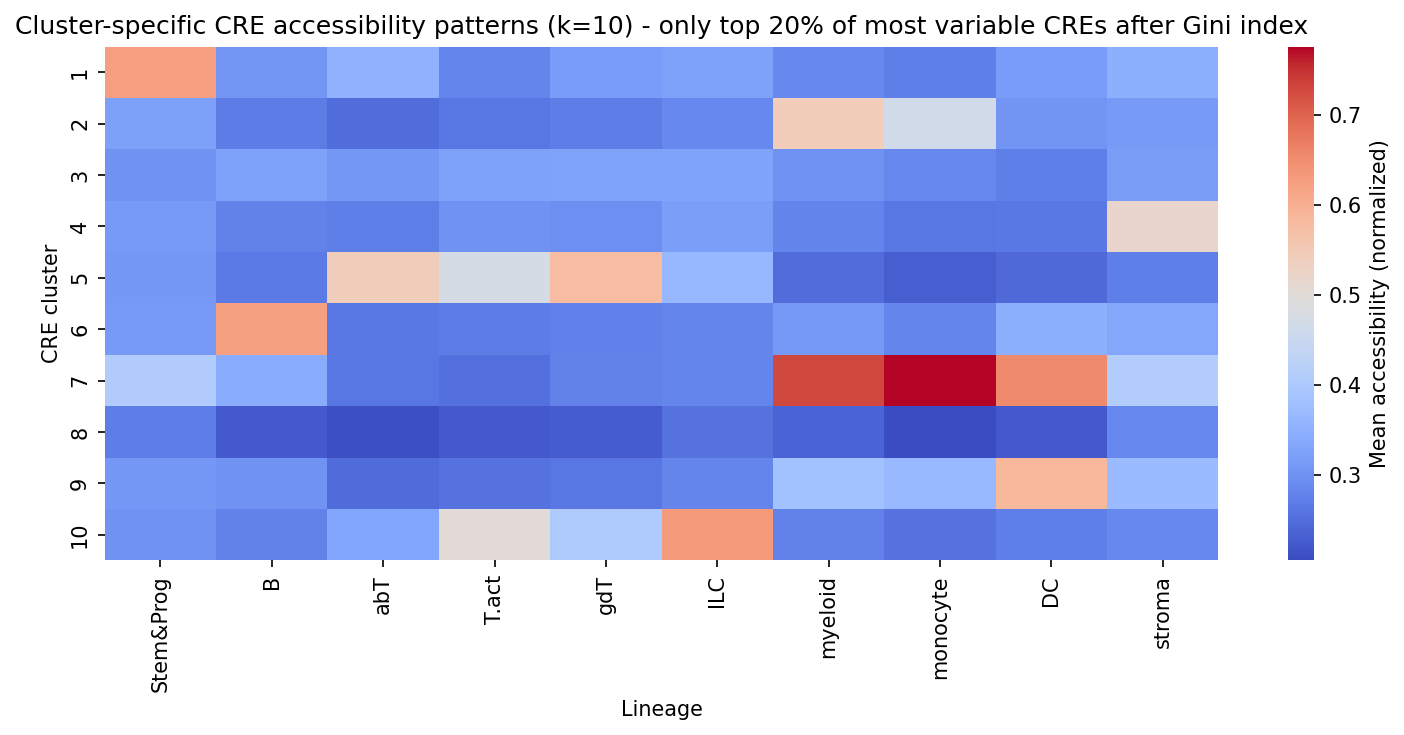

In [237]:
ATAC_MATRIX = pathlib.Path(r"data/converted_ATAC_seq_info.CSV")
mat = pd.read_csv(ATAC_MATRIX, sep=";", index_col=0)
mat = mat.loc[:, ~mat.columns.str.startswith("Unnamed")]
mat = mat.apply(pd.to_numeric, errors="coerce").fillna(0.0)
mat_log = np.log2(mat + 0.1)
mat_qnorm = (mat_log.rank(axis=0) / (len(mat_log) - 1)).astype(np.float32)

# Gini index function
def gini(row):
    x = np.sort(row.values)
    i = np.arange(1, x.size + 1)
    return ((2 * i - x.size - 1) * x).sum() / (x.size * x.sum())

# Gini for each row 
gini_scores = mat_qnorm.apply(gini, axis=1)
top_gini_mask = gini_scores >= gini_scores.quantile(0.80)
mat_cre = mat_qnorm.loc[top_gini_mask].copy() 

# PCA
pca = PCA(n_components=10, random_state=42)
mat_pca = pca.fit_transform(mat_cre)

# KMeans clustering 
k = 10  
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(mat_pca)
cluster_labels += 1
mat_cre["cluster"] = cluster_labels

# lineage info
QC = pd.read_csv("data/ATAC_QCmatric.csv", sep=";")
QC.columns = QC.columns.str.strip()
QC["CellType"] = QC["CellType"].str.strip()
QC["Lineage"] = QC["Lineage"].str.strip()

celltype_to_lineage = QC.drop_duplicates("CellType").set_index("CellType")["Lineage"]

# columns (cell types) to lineages
signal_data = mat_cre.drop(columns="cluster")
clusters = mat_cre["cluster"]
lineage_per_column = signal_data.columns.map(celltype_to_lineage)
valid_columns = ~lineage_per_column.isna()
signal_data = signal_data.loc[:, valid_columns]
lineage_per_column = lineage_per_column[valid_columns]
signal_data.columns = lineage_per_column

# mean signal per lineage
lineage_means = signal_data.groupby(signal_data.columns, axis=1).mean()
lineage_means["cluster"] = clusters.values

# mean per cluster across lineages
cluster_lineage_activity = lineage_means.groupby("cluster").mean()

# Reordering lineages according to QC matrix
lineage_order = QC.drop_duplicates("Lineage")["Lineage"].tolist()
lineage_order = [l for l in lineage_order if l in cluster_lineage_activity.columns]
cluster_lineage_activity = cluster_lineage_activity[lineage_order]

# Heatmap
plt.figure(figsize=(10, 5), dpi=150)
ax = sns.heatmap(cluster_lineage_activity, cmap="coolwarm", xticklabels=True,
                 cbar_kws={"label": "Mean accessibility (normalized)"})
plt.title(f"Cluster-specific CRE accessibility patterns (k={k}) - only top 20% of most variable CREs after Gini index")
plt.xlabel("Lineage")
plt.ylabel("CRE cluster")
plt.tight_layout()
plt.savefig("figures/Cluster-specific CRE accessibility patterns.png", dpi=300, bbox_inches="tight")
plt.show()

c:\Users\annal\miniconda3\envs\envBCells1\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\annal\AppData\Local\Temp\ipykernel_34796\1428895996.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("tab10", k)  # Only k colors!


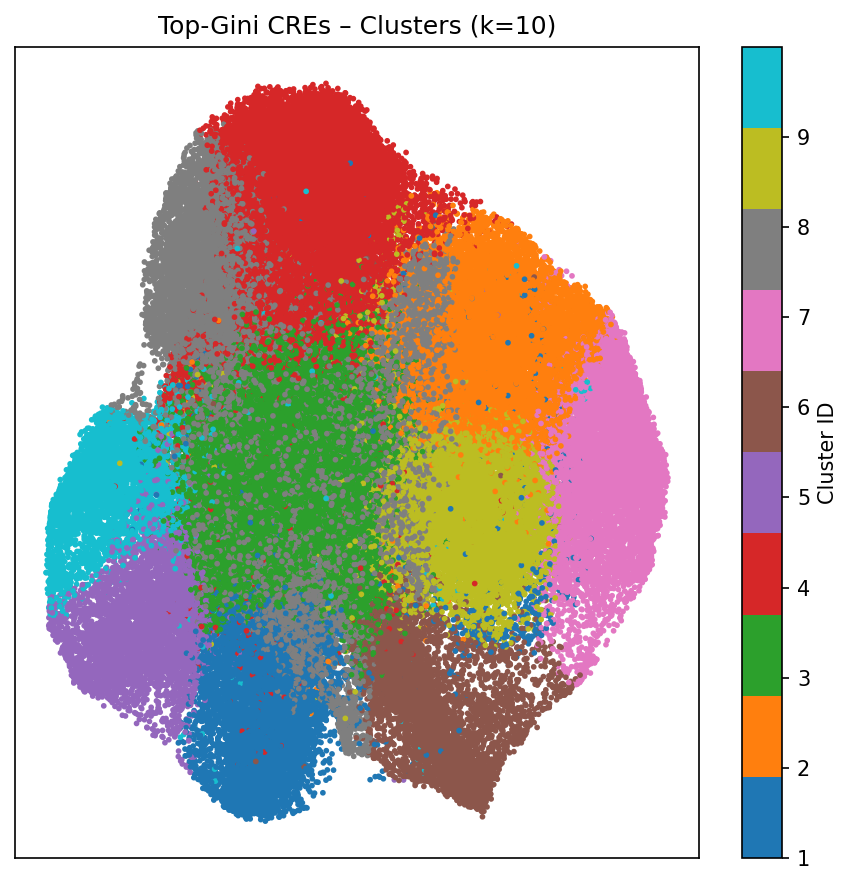

In [238]:
# UMAP 
umap_coords = umap.UMAP(n_neighbors=30, min_dist=0.3, random_state=42).fit_transform(mat_pca)
cmap = cm.get_cmap("tab10", k)  

plt.figure(figsize=(6, 6), dpi=150)
sc = plt.scatter(umap_coords[:, 0], umap_coords[:, 1], c=cluster_labels, cmap=cmap, s=3)
plt.title(f"Top-Gini CREs – Clusters (k={k})")
plt.xticks([]); plt.yticks([])
cbar = plt.colorbar(sc, ticks=range(k))
cbar.set_label("Cluster ID")
plt.tight_layout()
plt.savefig("figures/Top-Gini CRE- Cluster_ UMAP.png", dpi=300, bbox_inches="tight")
plt.show()

CREs can be clustered based on their ATAC signal. Clustering into 10 groups yields a clear structure, which supports our initial hypothesis, as we are analyzing 10 distinct lineages.

### b) Can one visualize the behaviour of clustered regions?

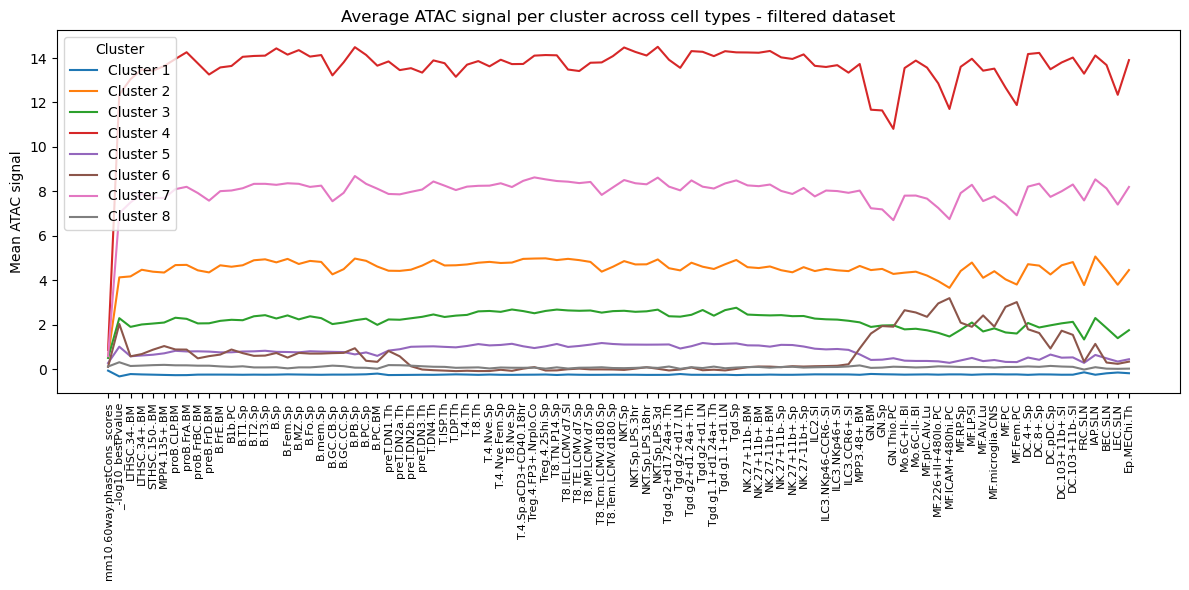

In [240]:
# peaks by cluster, mean per cell type 
mean_ATAC_stat_high_signal_peaks_scaled_columns = ATAC_scaled.groupby('cluster').mean()

# Line plot
plt.figure(figsize=(12, 6))
for i in mean_ATAC_stat_high_signal_peaks_scaled_columns.index:
    plt.plot(mean_ATAC_stat_high_signal_peaks_scaled_columns.columns, mean_ATAC_stat_high_signal_peaks_scaled_columns.loc[i], label=f'Cluster {i}')
plt.legend(title="Cluster")
plt.title("Average ATAC signal per cluster across cell types - filtered dataset")
plt.ylabel("Mean ATAC signal")
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.savefig("figures/Line_plot_of_clustered_regions.png", dpi=300, bbox_inches="tight")
plt.show()

Here you can see the average ATAC signal for each cluster, aggregated across all cell types. The clusters clearly differ in their "Mean ATAC singal" ranges.

### c) Can one define B-cell specific CRE clusters?

As shown in the heatmap in the heatmap of iv. a), only cluster 6 is B cell-specific, as the mean accessibility is high exclusively in B cells. Cluster 9 does not show lineage specificity but B cells, gdT cells, and myeloid cells all exhibit similarly high mean accessibility.

### d) When and how long is the B-cell specific CRE active?

The UMAP of iii. a) shows that cluster 6 is overlapping in B-cells and Stem&Prog-cells.